## Soiling Intervals Detection

This data set of current-voltage (I-V) curves and associated meteorological data for photovoltaic (PV) modules representing a flat-plate PV for one-year period. These publicly available data are intended to facilitate the validation of existing models for predicting the performance of PV modules and for the development of new and improved models. The data include a wide range of irradiance and temperature conditions representing each season.

The data include the following periods:

• Eugene – December 20, 2012, through January 20, 2014

• Cocoa – January 21, 2011, through March 4, 2012

• Golden – August 14, 2012, through September 24, 2013

In this notebook we are going to study the aforementioned dataset in order to identify periods of underperfoming due to soiling.

#### Loading Libraries

In [1]:
%matplotlib inline
import os,sys
import warnings
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
# from genmod.solarpaper import parse_csv
# from genmod.popu import *
# from genmod.procedure_fitness import *
# from genmod.listes import *
# from genmod.plot_eval import *
from genlib import *


#### Loading dataset

We denote the variables we extract from our datasets.

**poa**: The amount of solar irradiance in watts per square meter received on the PV module surface at the time indicated.

**mod_temp**: PV module back-surface temperature in degrees Celsius at the time indicated, measured behind center of cell near center of PV module.

**power**: Maximum power of PV module in watts at the time indicated.

**humidity**: Relative humidity at the site in percent, nearest 5-second average to the time indicated.

**precipitation**: Accumulated daily total precipitation in millimeters at the time indicated.

**soiling_derate**: Normalized metric comparing daily performance of a PV module to an identical PV module that is cleaned during daily maintenance.

In [2]:
import pandas as pd
filename ='golden.csv'

df=pd.read_csv(filename)
df['timestamp']=pd.to_datetime(df['timestamp'])
df=df.set_index('timestamp')
if filename=='golden.csv':
  df=df.loc[:'2013-06-24']


print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
# print(f'The Features of are set are {df.columns}')
print(f'Shape of our Timeseries: {df.shape}')
df


We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (207, 7)


,poa,mod_temp,power,humidity,precipitation,div,soiling_derate
timestamp,,,,,,,
2012-08-14,0.702845,0.900660,0.612522,0.138939,0.0,0.248621,0.994
2012-08-15,0.460646,0.814200,0.408669,0.094540,0.0,0.335704,0.995
2012-08-16,0.509351,0.695448,0.459634,0.505782,0.0,0.358148,0.995
2012-08-17,0.728656,0.832355,0.650592,0.394974,0.0,0.332674,0.993
2012-08-18,0.798300,0.859112,0.712263,0.222876,0.0,0.305808,0.993
...,...,...,...,...,...,...,...
2013-06-20,0.702163,0.853479,0.615004,0.096175,0.0,0.211933,0.987
2013-06-21,0.440595,0.786854,0.379020,0.091091,0.0,0.198195,0.986
2013-06-22,0.466936,0.744031,0.410957,0.278472,0.0,0.220976,0.990


In [3]:
# df2 = pd.DataFrame(index = pd.date_range('2014-01-21','2014-02-4', freq='D'))
# # df=pd.concat([df,df[:15].reset_index(drop=True).set_index(df2.index)])
# df=pd.concat([df,df2])
# df.soiling_derate=df.soiling_derate.fillna(1)
# df=df.interpolate(method='linear')
df_old=df

In the next cell we are taking advantage of the soiling_derate variable which we can distinguish soiling periods in our sets to create a groundtruth. We filter those periods with **soiling_dates(y=0.991)** function. As **y** goes to 1 the output becomes more sensitive so more periods will be return.

We found 9 Soiling Events with decay less than 0.989 
The indication of the start of a Soil is presented with Bold line
The indication of the end of a Soil is presented with Uncontinious line


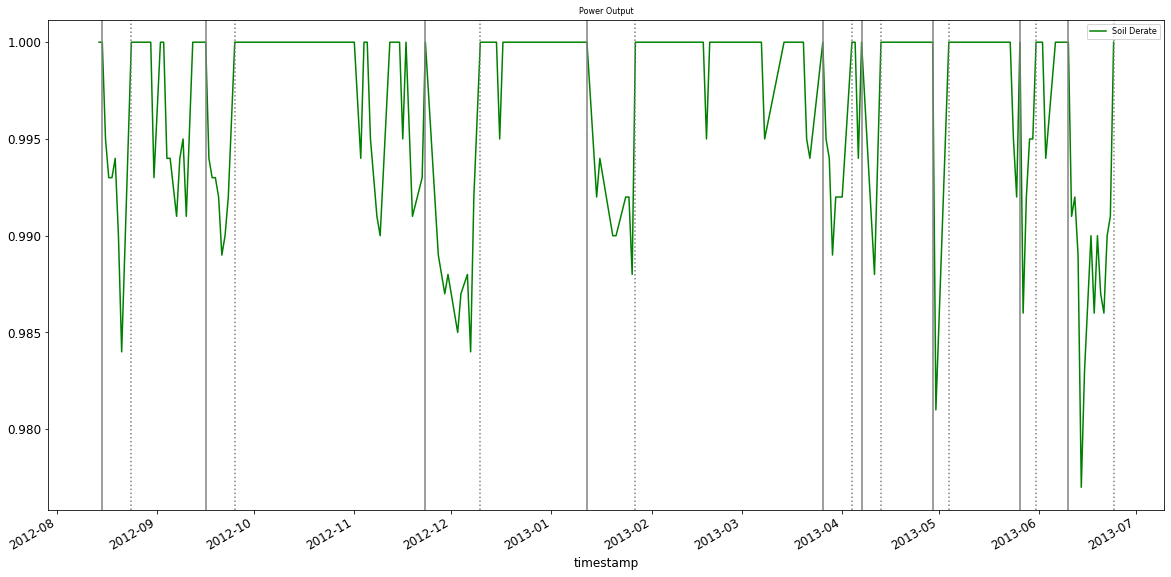

In [4]:
x=0.989
df.soiling_derate[-1]=1
if filename=='golden.csv':
    df.soiling_derate[0]=1
    df.soiling_derate[1]=1
df.soiling_derate[-1]=1
df_soil_output=soiling_dates(df,y=x,plot=True)
# print(f'Here we observe the exact dates which a soiling interval starts and stops')
# print(df_soil_output)

#### Motifs and Genetic algorithm

We rest on the matrixprofile algortihm and more specifically in the motif calculation algorithm by creating a domain of the several parameters it holds. On top of that we use a genetic algorithm in order to optimize the aforementioned
parameters which result into fiding soiling patterns(motifs).
To evaluate our approach, we use as training/testing data any of the Eugene, Cocoa, Golden panels.

### Parameters Initialization

In the next cell we initialize our parameters for a complete genetic run.

**col**: Columns which the matrix profile will be executed

**pop_size**: Population size. In our setting we create individuals (as many as the pop_size) which consist of 6 chromosomes. Namely those chromosomes are:

*min_neighbors*: The minimum number of similar matches a subsequence needs to have in order to be considered a motif.

*max_distance*: For a candidate motif,max_distance is the maximum distance allowed between the motif and the subsequence in order to be considered as a match.

*cutoff*: The largest matrix profile value (distance) that a candidate motif is allowed to have.

*max_matches*: The maximum amount of similar matches of a motif representative to be returned.

*max_motifs*: The maximum number of motifs to return.

*matrix_profile_windows*: Window size to perform the matrix profile.

**num_parents_mating**: Selects the parents using a user defined selection technique. Later, these parents will mate to produce the offspring. The techniques offered are: Selection Mating Pool, Steady State, Rank, Random, Tournament, Roulette Wheel Selection. (num_parents_mating must be always stricter less than pop_size)

**crossover**: Applies the  crossover. It randomly selects a gene at which crossover takes place between the pairs of parents through various techniques. The techniques offered are: Single_point, Two_points, Uniform, Scatter crossover.

**num_mutations**: Mutation changes a number of genes as defined by the num_mutations argument.The changes are random. More techniques to be **updated**.

**num_generations**: Number of genereations(loops) of the algorithm.

**mix_up**: True/False If true in each loop the pareting and crossover techniques are changing randomly.



In [5]:
col=['power']
pop_size = 300
num_parents_mating = 200
num_generations = 300
num_mutations=6
days=0
mix_up=True
#parenting=[smp,sss,ranks,randoms,tournament,rws,sus]
parenting='tournament'
#crossover=[single,twopoint,uni,scatter,old]
crossover='twopoint'
events=len(df_soil_output)

The goal of the procedure is to optimize the starting population through some steps.
1. Initialazing of the starting population.
2. Calculate a fitness function. We create a binary set of soiling & motif periods. In this setting we optimize the recall function from sklearn. We denote with class "1" the soiling and the motif periods, with class "0" when we have no soiling, motif period.

3. For the best output of fitness population we create the parents
4. From parents through crossover function we create the offspring (kids)
5. In order to avoid many identical solutions we mutate the offspring
6. Last step is to pass the offspring in the population for the next generation


#### Train Step

In [6]:
new_population,best_outputs,end_df,alles_df=procedure(df,df_soil_output,pop_size,days,
                                                      num_generations,num_parents_mating,
                                                      num_mutations,col,events,parenting,
                                                      crossover,mix_up)

Features: ['power']
Chromosomes: 6
Soiling Events: 9
Generations: 300
Population :300
Parents: 200


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:15<1:17:04, 15.47s/it]

  1%|          | 2/300 [00:38<1:39:10, 19.97s/it]

  1%|          | 3/300 [01:01<1:45:18, 21.27s/it]

  1%|▏         | 4/300 [01:25<1:50:28, 22.39s/it]

  2%|▏         | 5/300 [01:48<1:51:29, 22.68s/it]

  2%|▏         | 6/300 [02:10<1:50:27, 22.54s/it]

  2%|▏         | 7/300 [02:32<1:48:54, 22.30s/it]

  3%|▎         | 8/300 [02:56<1:50:37, 22.73s/it]

  3%|▎         | 9/300 [03:18<1:49:41, 22.62s/it]

  3%|▎         | 10/300 [03:40<1:48:22, 22.42s/it]

  4%|▎         | 11/300 [04:02<1:47:17, 22.27s/it]

  4%|▍         | 12/300 [04:25<1:48:14, 22.55s/it]

  4%|▍         | 13/300 [04:48<1:48:17, 22.64s/it]

  5%|▍         | 14/300 [05:12<1:49:10, 22.90s/it]

  5%|▌         | 15/300 [05:35<1:49:28, 23.05s/it]

  5%|▌         | 16/300 [06:01<1:53:37, 24.01s/it]

  6%|▌         | 17/300 [06:29<1:58:55, 25.21s/it]

  6%|▌         | 18/300 [06:58<2:03:04, 26.18s/it]

  6%|▋         | 19/300 [07:26<2:05:04, 26.71s/it]

  7%|▋         | 20/300 [07:52<2:04:03, 26.58s/it]

  7%|▋         | 21/300 [08:20<2:05:50, 27.06s/it]

  7%|▋         | 22/300 [08:48<2:06:07, 27.22s/it]

  8%|▊         | 23/300 [09:16<2:06:33, 27.41s/it]

  8%|▊         | 24/300 [09:43<2:05:38, 27.31s/it]

  8%|▊         | 25/300 [10:09<2:04:14, 27.11s/it]

  9%|▊         | 26/300 [10:36<2:03:45, 27.10s/it]

  9%|▉         | 27/300 [11:06<2:06:21, 27.77s/it]

  9%|▉         | 28/300 [11:35<2:07:34, 28.14s/it]

 10%|▉         | 29/300 [12:04<2:08:21, 28.42s/it]

 10%|█         | 30/300 [12:32<2:07:03, 28.23s/it]

 10%|█         | 31/300 [13:00<2:06:33, 28.23s/it]

 11%|█         | 32/300 [13:28<2:06:08, 28.24s/it]

 11%|█         | 33/300 [13:57<2:06:14, 28.37s/it]

 11%|█▏        | 34/300 [14:26<2:06:14, 28.48s/it]

 12%|█▏        | 35/300 [14:53<2:04:22, 28.16s/it]

 12%|█▏        | 36/300 [15:21<2:03:35, 28.09s/it]

 12%|█▏        | 37/300 [15:50<2:03:54, 28.27s/it]

 13%|█▎        | 38/300 [16:18<2:03:24, 28.26s/it]

 13%|█▎        | 39/300 [16:47<2:04:15, 28.57s/it]

 13%|█▎        | 40/300 [17:16<2:04:38, 28.76s/it]

 14%|█▎        | 41/300 [17:46<2:04:51, 28.92s/it]

 14%|█▍        | 42/300 [18:15<2:05:03, 29.08s/it]

 14%|█▍        | 43/300 [18:45<2:05:10, 29.22s/it]

 15%|█▍        | 44/300 [19:13<2:03:49, 29.02s/it]

 15%|█▌        | 45/300 [19:42<2:03:06, 28.97s/it]

 15%|█▌        | 46/300 [20:11<2:03:10, 29.10s/it]

 16%|█▌        | 47/300 [20:41<2:03:03, 29.18s/it]

 16%|█▌        | 48/300 [21:09<2:01:38, 28.96s/it]

 16%|█▋        | 49/300 [21:37<1:59:02, 28.46s/it]

 17%|█▋        | 50/300 [22:05<1:58:12, 28.37s/it]

 17%|█▋        | 51/300 [22:31<1:55:43, 27.89s/it]

 17%|█▋        | 52/300 [23:00<1:55:36, 27.97s/it]

 18%|█▊        | 53/300 [23:28<1:55:04, 27.95s/it]

 18%|█▊        | 54/300 [23:56<1:54:47, 28.00s/it]

 18%|█▊        | 55/300 [24:24<1:54:59, 28.16s/it]

 19%|█▊        | 56/300 [24:52<1:53:31, 27.92s/it]

 19%|█▉        | 57/300 [25:20<1:54:18, 28.22s/it]

 19%|█▉        | 58/300 [25:49<1:54:09, 28.30s/it]

 20%|█▉        | 59/300 [26:17<1:53:31, 28.26s/it]

 20%|██        | 60/300 [26:46<1:53:22, 28.34s/it]

 20%|██        | 61/300 [27:14<1:53:23, 28.47s/it]

 21%|██        | 62/300 [27:43<1:52:27, 28.35s/it]

 21%|██        | 63/300 [28:12<1:53:41, 28.78s/it]

 21%|██▏       | 64/300 [28:42<1:54:34, 29.13s/it]

 22%|██▏       | 65/300 [29:10<1:52:23, 28.70s/it]

 22%|██▏       | 66/300 [29:39<1:52:10, 28.76s/it]

 22%|██▏       | 67/300 [30:08<1:52:03, 28.86s/it]

 23%|██▎       | 68/300 [30:37<1:51:48, 28.92s/it]

 23%|██▎       | 69/300 [31:06<1:51:47, 29.04s/it]

 23%|██▎       | 70/300 [31:36<1:51:34, 29.11s/it]

 24%|██▎       | 71/300 [32:05<1:51:16, 29.15s/it]

 24%|██▍       | 72/300 [32:33<1:49:44, 28.88s/it]

 24%|██▍       | 73/300 [33:02<1:49:00, 28.81s/it]

 25%|██▍       | 74/300 [33:33<1:51:20, 29.56s/it]

 25%|██▌       | 75/300 [34:03<1:51:40, 29.78s/it]

 25%|██▌       | 76/300 [34:33<1:51:01, 29.74s/it]

 26%|██▌       | 77/300 [35:03<1:50:47, 29.81s/it]

 26%|██▌       | 78/300 [35:33<1:50:56, 29.98s/it]

 26%|██▋       | 79/300 [36:03<1:49:53, 29.84s/it]

 27%|██▋       | 80/300 [36:34<1:50:25, 30.12s/it]

 27%|██▋       | 81/300 [37:03<1:49:07, 29.90s/it]

 27%|██▋       | 82/300 [37:33<1:48:50, 29.96s/it]

 28%|██▊       | 83/300 [38:01<1:46:07, 29.35s/it]

 28%|██▊       | 84/300 [38:30<1:44:58, 29.16s/it]

 28%|██▊       | 85/300 [38:59<1:44:11, 29.08s/it]

 29%|██▊       | 86/300 [39:27<1:43:18, 28.96s/it]

 29%|██▉       | 87/300 [39:57<1:43:23, 29.13s/it]

 29%|██▉       | 88/300 [40:26<1:42:57, 29.14s/it]

 30%|██▉       | 89/300 [40:55<1:42:41, 29.20s/it]

 30%|███       | 90/300 [41:24<1:41:17, 28.94s/it]

 30%|███       | 91/300 [41:52<1:40:20, 28.81s/it]

 31%|███       | 92/300 [42:21<1:39:35, 28.73s/it]

 31%|███       | 93/300 [42:49<1:38:55, 28.67s/it]

 31%|███▏      | 94/300 [43:18<1:38:56, 28.82s/it]

 32%|███▏      | 95/300 [43:46<1:37:35, 28.56s/it]

 32%|███▏      | 96/300 [44:14<1:35:38, 28.13s/it]

 32%|███▏      | 97/300 [44:41<1:34:14, 27.86s/it]

 33%|███▎      | 98/300 [45:08<1:33:26, 27.76s/it]

 33%|███▎      | 99/300 [45:36<1:32:32, 27.62s/it]

 33%|███▎      | 100/300 [46:03<1:32:10, 27.65s/it]

 34%|███▎      | 101/300 [46:32<1:32:23, 27.86s/it]

 34%|███▍      | 102/300 [46:59<1:31:54, 27.85s/it]

 34%|███▍      | 103/300 [47:28<1:32:32, 28.18s/it]

 35%|███▍      | 104/300 [47:57<1:32:19, 28.26s/it]

 35%|███▌      | 105/300 [48:23<1:30:03, 27.71s/it]

 35%|███▌      | 106/300 [48:50<1:29:07, 27.56s/it]

 36%|███▌      | 107/300 [49:18<1:28:13, 27.42s/it]

 36%|███▌      | 108/300 [49:44<1:26:56, 27.17s/it]

 36%|███▋      | 109/300 [50:11<1:26:05, 27.04s/it]

 37%|███▋      | 110/300 [50:39<1:26:16, 27.24s/it]

 37%|███▋      | 111/300 [51:05<1:25:21, 27.10s/it]

 37%|███▋      | 112/300 [51:32<1:23:59, 26.81s/it]

 38%|███▊      | 113/300 [51:58<1:23:18, 26.73s/it]

 38%|███▊      | 114/300 [52:26<1:23:36, 26.97s/it]

 38%|███▊      | 115/300 [52:52<1:22:12, 26.66s/it]

 39%|███▊      | 116/300 [53:19<1:22:49, 27.01s/it]

 39%|███▉      | 117/300 [53:47<1:22:38, 27.10s/it]

 39%|███▉      | 118/300 [54:13<1:21:39, 26.92s/it]

 40%|███▉      | 119/300 [54:39<1:20:08, 26.57s/it]

 40%|████      | 120/300 [55:04<1:18:01, 26.01s/it]

 40%|████      | 121/300 [55:30<1:17:38, 26.03s/it]

 41%|████      | 122/300 [55:56<1:17:42, 26.19s/it]

 41%|████      | 123/300 [56:25<1:19:38, 27.00s/it]

 41%|████▏     | 124/300 [56:52<1:19:16, 27.03s/it]

 42%|████▏     | 125/300 [57:21<1:19:57, 27.41s/it]

 42%|████▏     | 126/300 [57:48<1:19:52, 27.54s/it]

 42%|████▏     | 127/300 [58:17<1:19:55, 27.72s/it]

 43%|████▎     | 128/300 [58:44<1:19:13, 27.64s/it]

 43%|████▎     | 129/300 [59:12<1:18:56, 27.70s/it]

 43%|████▎     | 130/300 [59:40<1:19:18, 27.99s/it]

 44%|████▎     | 131/300 [1:00:09<1:19:06, 28.08s/it]

 44%|████▍     | 132/300 [1:00:38<1:19:37, 28.44s/it]

 44%|████▍     | 133/300 [1:01:07<1:19:12, 28.46s/it]

 45%|████▍     | 134/300 [1:01:35<1:19:02, 28.57s/it]

 45%|████▌     | 135/300 [1:02:03<1:17:28, 28.17s/it]

 45%|████▌     | 136/300 [1:02:30<1:16:44, 28.08s/it]

 46%|████▌     | 137/300 [1:02:58<1:16:04, 28.00s/it]

 46%|████▌     | 138/300 [1:03:27<1:16:29, 28.33s/it]

 46%|████▋     | 139/300 [1:03:55<1:15:07, 28.00s/it]

 47%|████▋     | 140/300 [1:04:22<1:14:00, 27.75s/it]

 47%|████▋     | 141/300 [1:04:50<1:13:59, 27.92s/it]

 47%|████▋     | 142/300 [1:05:18<1:13:34, 27.94s/it]

 48%|████▊     | 143/300 [1:05:44<1:11:41, 27.40s/it]

 48%|████▊     | 144/300 [1:06:10<1:10:09, 26.98s/it]

 48%|████▊     | 145/300 [1:06:37<1:09:31, 26.91s/it]

 49%|████▊     | 146/300 [1:07:04<1:09:19, 27.01s/it]

 49%|████▉     | 147/300 [1:07:31<1:08:50, 27.00s/it]

 49%|████▉     | 148/300 [1:07:59<1:08:53, 27.19s/it]

 50%|████▉     | 149/300 [1:08:25<1:07:17, 26.74s/it]

 50%|█████     | 150/300 [1:08:50<1:06:02, 26.42s/it]

 50%|█████     | 151/300 [1:09:16<1:05:30, 26.38s/it]

 51%|█████     | 152/300 [1:09:43<1:05:01, 26.36s/it]

 51%|█████     | 153/300 [1:10:11<1:05:50, 26.87s/it]

 51%|█████▏    | 154/300 [1:10:40<1:06:48, 27.45s/it]

 52%|█████▏    | 155/300 [1:11:08<1:06:42, 27.60s/it]

 52%|█████▏    | 156/300 [1:11:36<1:06:40, 27.78s/it]

 52%|█████▏    | 157/300 [1:12:03<1:05:44, 27.59s/it]

 53%|█████▎    | 158/300 [1:12:31<1:05:38, 27.74s/it]

 53%|█████▎    | 159/300 [1:12:58<1:04:27, 27.43s/it]

 53%|█████▎    | 160/300 [1:13:25<1:03:37, 27.27s/it]

 54%|█████▎    | 161/300 [1:13:52<1:03:14, 27.30s/it]

 54%|█████▍    | 162/300 [1:14:20<1:03:09, 27.46s/it]

 54%|█████▍    | 163/300 [1:14:48<1:03:12, 27.69s/it]

 55%|█████▍    | 164/300 [1:15:15<1:02:09, 27.42s/it]

 55%|█████▌    | 165/300 [1:15:41<1:00:50, 27.04s/it]

 55%|█████▌    | 166/300 [1:16:08<1:00:27, 27.07s/it]

 56%|█████▌    | 167/300 [1:16:35<59:48, 26.98s/it]  

 56%|█████▌    | 168/300 [1:17:02<59:30, 27.05s/it]

 56%|█████▋    | 169/300 [1:17:33<1:01:22, 28.11s/it]

 57%|█████▋    | 170/300 [1:18:02<1:01:39, 28.46s/it]

 57%|█████▋    | 171/300 [1:18:32<1:02:16, 28.97s/it]

 57%|█████▋    | 172/300 [1:19:03<1:02:46, 29.42s/it]

 58%|█████▊    | 173/300 [1:19:32<1:02:29, 29.53s/it]

 58%|█████▊    | 174/300 [1:20:02<1:02:17, 29.67s/it]

 58%|█████▊    | 175/300 [1:20:32<1:01:29, 29.51s/it]

 59%|█████▊    | 176/300 [1:21:01<1:00:59, 29.51s/it]

 59%|█████▉    | 177/300 [1:21:31<1:00:42, 29.61s/it]

 59%|█████▉    | 178/300 [1:22:01<1:00:30, 29.76s/it]

 60%|█████▉    | 179/300 [1:22:31<1:00:07, 29.82s/it]

 60%|██████    | 180/300 [1:23:02<1:00:15, 30.13s/it]

 60%|██████    | 181/300 [1:23:32<59:47, 30.15s/it]  

 61%|██████    | 182/300 [1:24:03<59:31, 30.26s/it]

 61%|██████    | 183/300 [1:24:32<58:49, 30.16s/it]

 61%|██████▏   | 184/300 [1:25:02<58:07, 30.07s/it]

 62%|██████▏   | 185/300 [1:25:32<57:28, 29.99s/it]

 62%|██████▏   | 186/300 [1:26:02<56:49, 29.91s/it]

 62%|██████▏   | 187/300 [1:26:32<56:35, 30.05s/it]

 63%|██████▎   | 188/300 [1:27:03<56:22, 30.20s/it]

 63%|██████▎   | 189/300 [1:27:33<56:01, 30.29s/it]

 63%|██████▎   | 190/300 [1:28:02<54:46, 29.88s/it]

 64%|██████▎   | 191/300 [1:28:32<54:23, 29.94s/it]

 64%|██████▍   | 192/300 [1:29:02<53:39, 29.81s/it]

 64%|██████▍   | 193/300 [1:29:32<53:19, 29.90s/it]

 65%|██████▍   | 194/300 [1:30:02<52:48, 29.89s/it]

 65%|██████▌   | 195/300 [1:30:33<52:45, 30.14s/it]

 65%|██████▌   | 196/300 [1:31:02<51:56, 29.97s/it]

 66%|██████▌   | 197/300 [1:31:32<51:35, 30.06s/it]

 66%|██████▌   | 198/300 [1:32:03<51:10, 30.10s/it]

 66%|██████▋   | 199/300 [1:32:33<50:51, 30.21s/it]

 67%|██████▋   | 200/300 [1:33:02<49:57, 29.97s/it]

 67%|██████▋   | 201/300 [1:33:32<49:19, 29.89s/it]

 67%|██████▋   | 202/300 [1:34:02<48:36, 29.76s/it]

 68%|██████▊   | 203/300 [1:34:31<48:11, 29.80s/it]

 68%|██████▊   | 204/300 [1:35:01<47:36, 29.75s/it]

 68%|██████▊   | 205/300 [1:35:31<46:57, 29.66s/it]

 69%|██████▊   | 206/300 [1:36:00<46:15, 29.52s/it]

 69%|██████▉   | 207/300 [1:36:29<45:51, 29.58s/it]

 69%|██████▉   | 208/300 [1:36:59<45:18, 29.55s/it]

 70%|██████▉   | 209/300 [1:37:28<44:46, 29.52s/it]

 70%|███████   | 210/300 [1:37:58<44:31, 29.69s/it]

 70%|███████   | 211/300 [1:38:29<44:23, 29.93s/it]

 71%|███████   | 212/300 [1:39:00<44:12, 30.15s/it]

 71%|███████   | 213/300 [1:39:30<43:46, 30.18s/it]

 71%|███████▏  | 214/300 [1:40:01<43:33, 30.39s/it]

 72%|███████▏  | 215/300 [1:40:31<42:50, 30.24s/it]

 72%|███████▏  | 216/300 [1:41:01<42:32, 30.39s/it]

 72%|███████▏  | 217/300 [1:41:32<42:07, 30.46s/it]

 73%|███████▎  | 218/300 [1:42:02<41:37, 30.46s/it]

 73%|███████▎  | 219/300 [1:42:33<41:01, 30.38s/it]

 73%|███████▎  | 220/300 [1:43:02<40:07, 30.10s/it]

 74%|███████▎  | 221/300 [1:43:31<39:13, 29.79s/it]

 74%|███████▍  | 222/300 [1:44:01<38:48, 29.86s/it]

 74%|███████▍  | 223/300 [1:44:31<38:18, 29.85s/it]

 75%|███████▍  | 224/300 [1:45:01<37:49, 29.86s/it]

 75%|███████▌  | 225/300 [1:45:32<37:41, 30.15s/it]

 75%|███████▌  | 226/300 [1:46:02<37:15, 30.21s/it]

 76%|███████▌  | 227/300 [1:46:33<36:59, 30.40s/it]

 76%|███████▌  | 228/300 [1:47:04<36:45, 30.63s/it]

 76%|███████▋  | 229/300 [1:47:34<36:09, 30.55s/it]

 77%|███████▋  | 230/300 [1:48:05<35:29, 30.43s/it]

 77%|███████▋  | 231/300 [1:48:35<35:05, 30.51s/it]

 77%|███████▋  | 232/300 [1:49:05<34:23, 30.35s/it]

 78%|███████▊  | 233/300 [1:49:35<33:44, 30.22s/it]

 78%|███████▊  | 234/300 [1:50:06<33:20, 30.31s/it]

 78%|███████▊  | 235/300 [1:50:38<33:26, 30.87s/it]

 79%|███████▊  | 236/300 [1:51:10<33:15, 31.18s/it]

 79%|███████▉  | 237/300 [1:51:42<32:57, 31.39s/it]

 79%|███████▉  | 238/300 [1:52:14<32:44, 31.68s/it]

 80%|███████▉  | 239/300 [1:52:45<32:06, 31.58s/it]

 80%|████████  | 240/300 [1:53:16<31:14, 31.24s/it]

 80%|████████  | 241/300 [1:53:47<30:41, 31.21s/it]

 81%|████████  | 242/300 [1:54:19<30:30, 31.56s/it]

 81%|████████  | 243/300 [1:54:51<29:54, 31.49s/it]

 81%|████████▏ | 244/300 [1:55:21<29:09, 31.25s/it]

 82%|████████▏ | 245/300 [1:55:52<28:36, 31.21s/it]

 82%|████████▏ | 246/300 [1:56:23<27:56, 31.05s/it]

 82%|████████▏ | 247/300 [1:56:54<27:21, 30.97s/it]

 83%|████████▎ | 248/300 [1:57:25<26:46, 30.90s/it]

 83%|████████▎ | 249/300 [1:57:55<26:14, 30.88s/it]

 83%|████████▎ | 250/300 [1:58:26<25:33, 30.66s/it]

 84%|████████▎ | 251/300 [1:58:56<24:58, 30.58s/it]

 84%|████████▍ | 252/300 [1:59:26<24:25, 30.54s/it]

 84%|████████▍ | 253/300 [1:59:57<23:53, 30.51s/it]

 85%|████████▍ | 254/300 [2:00:27<23:13, 30.30s/it]

 85%|████████▌ | 255/300 [2:00:58<23:00, 30.68s/it]

 85%|████████▌ | 256/300 [2:01:29<22:31, 30.72s/it]

 86%|████████▌ | 257/300 [2:01:59<21:47, 30.41s/it]

 86%|████████▌ | 258/300 [2:02:29<21:18, 30.45s/it]

 86%|████████▋ | 259/300 [2:02:59<20:37, 30.18s/it]

 87%|████████▋ | 260/300 [2:03:30<20:19, 30.49s/it]

 87%|████████▋ | 261/300 [2:04:01<19:52, 30.59s/it]

 87%|████████▋ | 262/300 [2:04:32<19:26, 30.70s/it]

 88%|████████▊ | 263/300 [2:05:04<19:06, 30.99s/it]

 88%|████████▊ | 264/300 [2:05:34<18:30, 30.84s/it]

 88%|████████▊ | 265/300 [2:06:05<18:01, 30.90s/it]

 89%|████████▊ | 266/300 [2:06:35<17:25, 30.76s/it]

 89%|████████▉ | 267/300 [2:07:06<16:49, 30.58s/it]

 89%|████████▉ | 268/300 [2:07:36<16:19, 30.60s/it]

 90%|████████▉ | 269/300 [2:08:09<16:05, 31.15s/it]

 90%|█████████ | 270/300 [2:08:40<15:39, 31.32s/it]

 90%|█████████ | 271/300 [2:09:12<15:06, 31.28s/it]

 91%|█████████ | 272/300 [2:09:44<14:42, 31.52s/it]

 91%|█████████ | 273/300 [2:10:15<14:07, 31.38s/it]

 91%|█████████▏| 274/300 [2:10:47<13:38, 31.49s/it]

 92%|█████████▏| 275/300 [2:11:18<13:05, 31.41s/it]

 92%|█████████▏| 276/300 [2:11:50<12:38, 31.61s/it]

 92%|█████████▏| 277/300 [2:12:22<12:13, 31.88s/it]

 93%|█████████▎| 278/300 [2:12:54<11:39, 31.80s/it]

 93%|█████████▎| 279/300 [2:13:25<11:03, 31.60s/it]

 93%|█████████▎| 280/300 [2:13:56<10:28, 31.45s/it]

 94%|█████████▎| 281/300 [2:14:27<09:56, 31.40s/it]

 94%|█████████▍| 282/300 [2:15:00<09:29, 31.62s/it]

 94%|█████████▍| 283/300 [2:15:31<08:55, 31.53s/it]

 95%|█████████▍| 284/300 [2:16:02<08:23, 31.48s/it]

 95%|█████████▌| 285/300 [2:16:34<07:51, 31.45s/it]

 95%|█████████▌| 286/300 [2:17:04<07:15, 31.08s/it]

 96%|█████████▌| 287/300 [2:17:35<06:44, 31.11s/it]

 96%|█████████▌| 288/300 [2:18:06<06:11, 31.00s/it]

 96%|█████████▋| 289/300 [2:18:38<05:44, 31.34s/it]

 97%|█████████▋| 290/300 [2:19:11<05:17, 31.79s/it]

 97%|█████████▋| 291/300 [2:19:43<04:46, 31.88s/it]

 97%|█████████▋| 292/300 [2:20:15<04:16, 32.07s/it]

 98%|█████████▊| 293/300 [2:20:47<03:43, 31.87s/it]

 98%|█████████▊| 294/300 [2:21:18<03:09, 31.66s/it]

 98%|█████████▊| 295/300 [2:21:50<02:39, 31.92s/it]

 99%|█████████▊| 296/300 [2:22:23<02:08, 32.11s/it]

 99%|█████████▉| 297/300 [2:22:56<01:36, 32.30s/it]

 99%|█████████▉| 298/300 [2:23:29<01:05, 32.70s/it]

100%|█████████▉| 299/300 [2:24:02<00:32, 32.75s/it]

100%|██████████| 300/300 [2:24:35<00:00, 32.88s/it]

100%|██████████| 300/300 [2:24:35<00:00, 28.92s/it]

Time to complete: 8675.92seconds


:The individual which max the F1 function is: 7
Best solution fitness :  0.5986394557823129


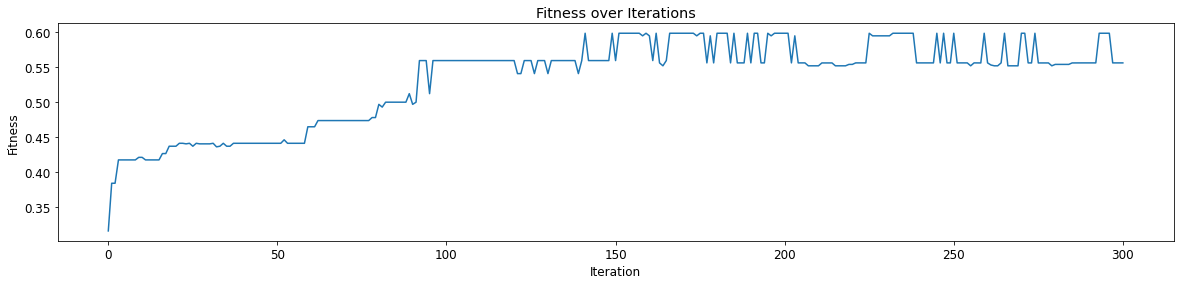

Shape of Result Frame
(1839, 17)


In [7]:
# print(best_outputs)
fitness,alles_df1 = fiteness_fun(df,df_soil_output,days,new_population,col)
best_outputs.extend([np.max(fitness)])
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))
print(f':The individual which max the F1 function is: {len(best_match_idx[0])}')
print("Best solution fitness : ", np.max(best_outputs))
import matplotlib.pyplot
matplotlib.pyplot.plot(best_outputs)
matplotlib.pyplot.title('Fitness over Iterations')
matplotlib.pyplot.xlabel("Iteration")
matplotlib.pyplot.ylabel("Fitness")
matplotlib.pyplot.show()
end_df=pd.concat([end_df,alles_df1])
end_df=end_df.reset_index(drop=True)
end_df=end_df.loc[end_df[['f1']].drop_duplicates(['f1']).index]
end_df=end_df.sort_values(by='f1',ascending=False)
end_df=end_df.reset_index(drop=True)
end_df.head(5)
print('Shape of Result Frame')
print(end_df.shape)

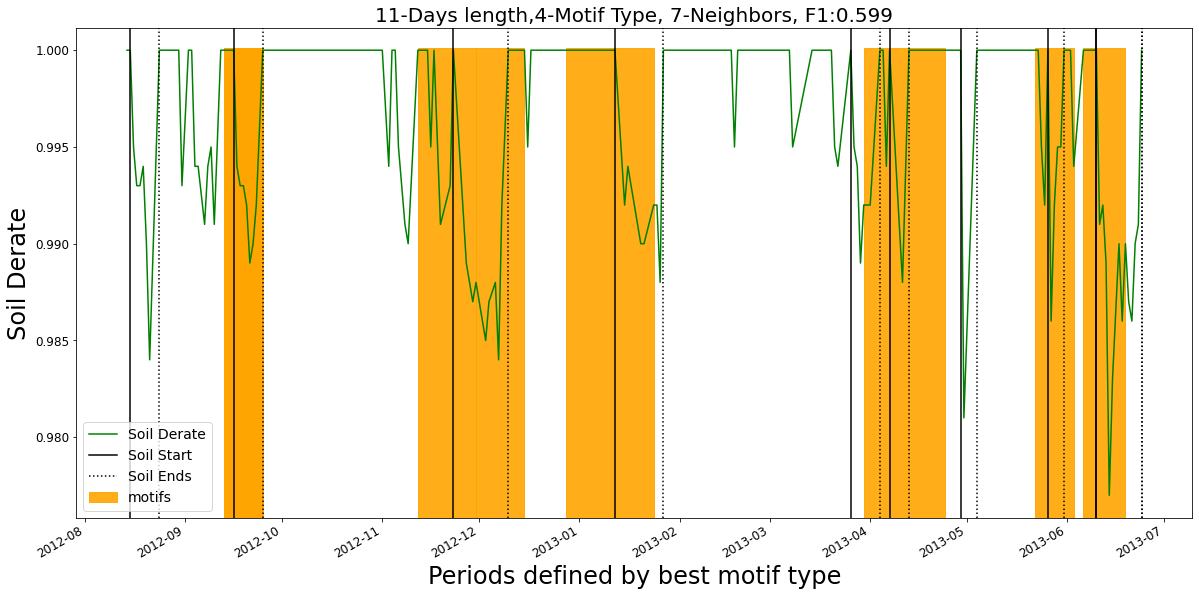

              precision    recall  f1-score   support

         0.0       0.80      0.76      0.78       137
         1.0       0.57      0.63      0.60        70

    accuracy                           0.71       207
   macro avg       0.69      0.69      0.69       207
weighted avg       0.72      0.71      0.72       207



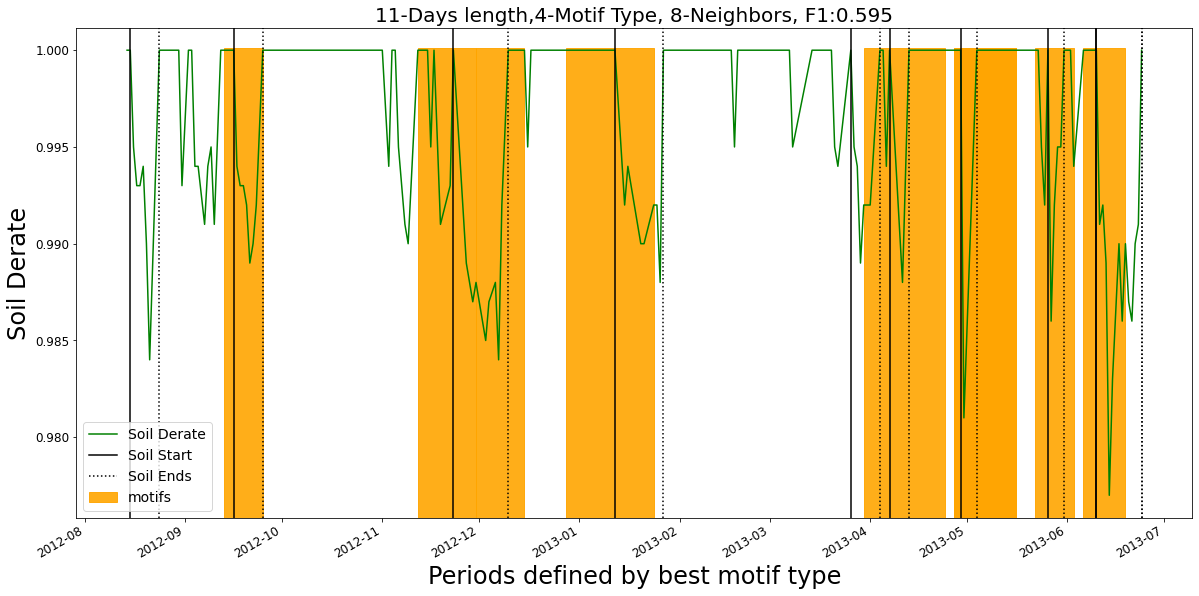

              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       137
         1.0       0.53      0.67      0.59        70

    accuracy                           0.69       207
   macro avg       0.67      0.69      0.67       207
weighted avg       0.71      0.69      0.70       207



In [8]:
motif_graph_multi_dim(col=col,df=df,
                  df_soil_output=df_soil_output,
                  alles_df=end_df,n=2,plot=True)

### Motif based pattern discovery 
Here we test the results of the the previous panel to the other two.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
1/2
eugene.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (355, 7)
We found 5 Soiling Events with decay less than 0.989 


  0%|          | 0/1082 [00:00<?, ?it/s]

  0%|          | 1/1082 [00:00<06:26,  2.79it/s]

  0%|          | 2/1082 [00:00<05:50,  3.08it/s]

  0%|          | 3/1082 [00:00<04:52,  3.69it/s]

  0%|          | 4/1082 [00:01<06:01,  2.98it/s]

  0%|          | 5/1082 [00:02<09:03,  1.98it/s]

  1%|          | 6/1082 [00:02<08:27,  2.12it/s]

  1%|          | 7/1082 [00:03<09:39,  1.86it/s]

  1%|          | 8/1082 [00:03<09:18,  1.92it/s]

  1%|          | 9/1082 [00:04<10:35,  1.69it/s]

  1%|          | 10/1082 [00:04<09:38,  1.85it/s]

  1%|          | 11/1082 [00:05<10:10,  1.75it/s]

  1%|          | 12/1082 [00:05<09:37,  1.85it/s]

  1%|          | 13/1082 [00:06<10:16,  1.73it/s]

  1%|▏         | 14/1082 [00:07<11:59,  1.48it/s]

  1%|▏         | 15/1082 [00:08<12:29,  1.42it/s]

  1%|▏         | 16/1082 [00:09<14:15,  1.25it/s]

  2%|▏         | 17/1082 [00:09<13:09,  1.35it/s]

  2%|▏         | 18/1082 [00:10<10:21,  1.71it/s]

  2%|▏         | 19/1082 [00:11<12:24,  1.43it/s]

  2%|▏         | 20/1082 [00:11<11:28,  1.54it/s]

  2%|▏         | 21/1082 [00:11<09:55,  1.78it/s]

  2%|▏         | 22/1082 [00:12<09:37,  1.84it/s]

  2%|▏         | 23/1082 [00:13<09:59,  1.77it/s]

  2%|▏         | 24/1082 [00:13<11:07,  1.58it/s]

  2%|▏         | 25/1082 [00:14<09:30,  1.85it/s]

  2%|▏         | 26/1082 [00:15<11:22,  1.55it/s]

  2%|▏         | 27/1082 [00:15<11:10,  1.57it/s]

  3%|▎         | 28/1082 [00:16<11:13,  1.57it/s]

  3%|▎         | 29/1082 [00:17<14:55,  1.18it/s]

  3%|▎         | 30/1082 [00:18<12:34,  1.39it/s]

  3%|▎         | 31/1082 [00:18<11:07,  1.58it/s]

  3%|▎         | 32/1082 [00:19<10:10,  1.72it/s]

  3%|▎         | 33/1082 [00:19<10:23,  1.68it/s]

  3%|▎         | 34/1082 [00:20<09:43,  1.80it/s]

  3%|▎         | 35/1082 [00:21<12:41,  1.37it/s]

  3%|▎         | 36/1082 [00:21<10:08,  1.72it/s]

  3%|▎         | 37/1082 [00:22<10:13,  1.70it/s]

  4%|▎         | 38/1082 [00:22<09:58,  1.74it/s]

  4%|▎         | 39/1082 [00:23<10:54,  1.59it/s]

  4%|▎         | 40/1082 [00:23<10:29,  1.65it/s]

  4%|▍         | 41/1082 [00:24<09:47,  1.77it/s]

  4%|▍         | 42/1082 [00:24<08:41,  1.99it/s]

  4%|▍         | 43/1082 [00:25<09:50,  1.76it/s]

  4%|▍         | 44/1082 [00:25<08:45,  1.97it/s]

  4%|▍         | 45/1082 [00:26<11:07,  1.55it/s]

  4%|▍         | 46/1082 [00:27<13:17,  1.30it/s]

  4%|▍         | 47/1082 [00:28<14:01,  1.23it/s]

  4%|▍         | 48/1082 [00:29<13:46,  1.25it/s]

  5%|▍         | 49/1082 [00:29<11:45,  1.46it/s]

  5%|▍         | 50/1082 [00:30<12:35,  1.37it/s]

  5%|▍         | 51/1082 [00:31<11:02,  1.56it/s]

  5%|▍         | 52/1082 [00:31<09:24,  1.83it/s]

  5%|▍         | 53/1082 [00:31<08:13,  2.09it/s]

  5%|▍         | 54/1082 [00:32<08:42,  1.97it/s]

  5%|▌         | 55/1082 [00:32<06:58,  2.46it/s]

  5%|▌         | 56/1082 [00:33<09:28,  1.80it/s]

  5%|▌         | 57/1082 [00:34<09:37,  1.77it/s]

  5%|▌         | 58/1082 [00:35<11:25,  1.49it/s]

  5%|▌         | 59/1082 [00:35<11:14,  1.52it/s]

  6%|▌         | 60/1082 [00:36<10:12,  1.67it/s]

  6%|▌         | 61/1082 [00:36<11:26,  1.49it/s]

  6%|▌         | 62/1082 [00:37<11:55,  1.43it/s]

  6%|▌         | 63/1082 [00:38<12:50,  1.32it/s]

  6%|▌         | 64/1082 [00:39<11:59,  1.41it/s]

  6%|▌         | 65/1082 [00:39<09:32,  1.78it/s]

  6%|▌         | 66/1082 [00:39<08:39,  1.95it/s]

  6%|▌         | 67/1082 [00:40<09:47,  1.73it/s]

  6%|▋         | 68/1082 [00:40<07:47,  2.17it/s]

  6%|▋         | 69/1082 [00:41<06:53,  2.45it/s]

  6%|▋         | 70/1082 [00:41<07:52,  2.14it/s]

  7%|▋         | 71/1082 [00:42<07:20,  2.30it/s]

  7%|▋         | 72/1082 [00:42<06:47,  2.48it/s]

  7%|▋         | 73/1082 [00:43<09:33,  1.76it/s]

  7%|▋         | 74/1082 [00:43<08:48,  1.91it/s]

  7%|▋         | 75/1082 [00:44<10:22,  1.62it/s]

  7%|▋         | 76/1082 [00:45<10:07,  1.65it/s]

  7%|▋         | 77/1082 [00:45<10:45,  1.56it/s]

  7%|▋         | 78/1082 [00:46<11:49,  1.41it/s]

  7%|▋         | 79/1082 [00:47<14:13,  1.18it/s]

  7%|▋         | 80/1082 [00:48<13:43,  1.22it/s]

  7%|▋         | 81/1082 [00:48<10:50,  1.54it/s]

  8%|▊         | 82/1082 [00:49<10:41,  1.56it/s]

  8%|▊         | 83/1082 [00:50<11:37,  1.43it/s]

  8%|▊         | 84/1082 [00:51<13:43,  1.21it/s]

  8%|▊         | 85/1082 [00:51<12:04,  1.38it/s]

  8%|▊         | 86/1082 [00:52<09:25,  1.76it/s]

  8%|▊         | 87/1082 [00:53<10:50,  1.53it/s]

  8%|▊         | 88/1082 [00:53<08:52,  1.87it/s]

  8%|▊         | 89/1082 [00:54<10:14,  1.61it/s]

  8%|▊         | 90/1082 [00:54<09:45,  1.70it/s]

  8%|▊         | 91/1082 [00:55<10:47,  1.53it/s]

  9%|▊         | 92/1082 [00:56<11:24,  1.45it/s]

  9%|▊         | 93/1082 [00:57<12:02,  1.37it/s]

  9%|▊         | 94/1082 [00:57<10:59,  1.50it/s]

  9%|▉         | 95/1082 [00:57<09:24,  1.75it/s]

  9%|▉         | 96/1082 [00:58<09:23,  1.75it/s]

  9%|▉         | 97/1082 [00:59<09:19,  1.76it/s]

  9%|▉         | 98/1082 [01:00<11:52,  1.38it/s]

  9%|▉         | 99/1082 [01:01<12:41,  1.29it/s]

  9%|▉         | 100/1082 [01:02<14:11,  1.15it/s]

  9%|▉         | 101/1082 [01:02<12:14,  1.34it/s]

  9%|▉         | 102/1082 [01:03<10:53,  1.50it/s]

 10%|▉         | 103/1082 [01:03<11:57,  1.36it/s]

 10%|▉         | 104/1082 [01:04<09:52,  1.65it/s]

 10%|▉         | 105/1082 [01:05<11:02,  1.48it/s]

 10%|▉         | 106/1082 [01:05<08:46,  1.85it/s]

 10%|▉         | 107/1082 [01:06<09:55,  1.64it/s]

 10%|▉         | 108/1082 [01:07<11:32,  1.41it/s]

 10%|█         | 109/1082 [01:07<11:03,  1.47it/s]

 10%|█         | 110/1082 [01:08<11:57,  1.35it/s]

 10%|█         | 111/1082 [01:09<11:30,  1.41it/s]

 10%|█         | 112/1082 [01:09<11:24,  1.42it/s]

 10%|█         | 113/1082 [01:10<08:58,  1.80it/s]

 11%|█         | 114/1082 [01:10<08:11,  1.97it/s]

 11%|█         | 115/1082 [01:11<08:26,  1.91it/s]

 11%|█         | 116/1082 [01:11<07:25,  2.17it/s]

 11%|█         | 117/1082 [01:12<09:21,  1.72it/s]

 11%|█         | 118/1082 [01:13<11:26,  1.41it/s]

 11%|█         | 119/1082 [01:13<09:09,  1.75it/s]

 11%|█         | 120/1082 [01:14<10:17,  1.56it/s]

 11%|█         | 121/1082 [01:14<10:45,  1.49it/s]

 11%|█▏        | 122/1082 [01:15<09:20,  1.71it/s]

 11%|█▏        | 123/1082 [01:15<08:33,  1.87it/s]

 11%|█▏        | 124/1082 [01:16<09:14,  1.73it/s]

 12%|█▏        | 125/1082 [01:17<11:43,  1.36it/s]

 12%|█▏        | 126/1082 [01:18<12:33,  1.27it/s]

 12%|█▏        | 127/1082 [01:19<13:10,  1.21it/s]

 12%|█▏        | 128/1082 [01:20<13:03,  1.22it/s]

 12%|█▏        | 129/1082 [01:20<11:32,  1.38it/s]

 12%|█▏        | 130/1082 [01:21<09:40,  1.64it/s]

 12%|█▏        | 131/1082 [01:21<10:35,  1.50it/s]

 12%|█▏        | 132/1082 [01:22<10:27,  1.52it/s]

 12%|█▏        | 133/1082 [01:23<10:22,  1.52it/s]

 12%|█▏        | 134/1082 [01:23<11:02,  1.43it/s]

 12%|█▏        | 135/1082 [01:24<11:47,  1.34it/s]

 13%|█▎        | 136/1082 [01:25<11:11,  1.41it/s]

 13%|█▎        | 137/1082 [01:26<11:30,  1.37it/s]

 13%|█▎        | 138/1082 [01:27<11:50,  1.33it/s]

 13%|█▎        | 139/1082 [01:28<13:34,  1.16it/s]

 13%|█▎        | 140/1082 [01:29<13:40,  1.15it/s]

 13%|█▎        | 141/1082 [01:29<11:19,  1.39it/s]

 13%|█▎        | 142/1082 [01:29<10:45,  1.46it/s]

 13%|█▎        | 143/1082 [01:30<11:30,  1.36it/s]

 13%|█▎        | 144/1082 [01:31<10:19,  1.51it/s]

 13%|█▎        | 145/1082 [01:31<09:58,  1.57it/s]

 13%|█▎        | 146/1082 [01:32<09:32,  1.64it/s]

 14%|█▎        | 147/1082 [01:33<09:27,  1.65it/s]

 14%|█▎        | 148/1082 [01:33<10:32,  1.48it/s]

 14%|█▍        | 149/1082 [01:34<09:43,  1.60it/s]

 14%|█▍        | 150/1082 [01:35<10:22,  1.50it/s]

 14%|█▍        | 151/1082 [01:35<08:57,  1.73it/s]

 14%|█▍        | 152/1082 [01:36<09:43,  1.59it/s]

 14%|█▍        | 153/1082 [01:37<11:39,  1.33it/s]

 14%|█▍        | 154/1082 [01:38<12:16,  1.26it/s]

 14%|█▍        | 155/1082 [01:38<11:58,  1.29it/s]

 14%|█▍        | 156/1082 [01:39<12:52,  1.20it/s]

 15%|█▍        | 157/1082 [01:40<11:58,  1.29it/s]

 15%|█▍        | 158/1082 [01:41<12:59,  1.18it/s]

 15%|█▍        | 159/1082 [01:41<10:13,  1.50it/s]

 15%|█▍        | 160/1082 [01:42<08:01,  1.91it/s]

 15%|█▍        | 161/1082 [01:42<08:21,  1.84it/s]

 15%|█▍        | 162/1082 [01:43<10:47,  1.42it/s]

 15%|█▌        | 163/1082 [01:44<11:02,  1.39it/s]

 15%|█▌        | 164/1082 [01:45<10:18,  1.48it/s]

 15%|█▌        | 165/1082 [01:45<11:20,  1.35it/s]

 15%|█▌        | 166/1082 [01:46<09:21,  1.63it/s]

 15%|█▌        | 167/1082 [01:46<08:22,  1.82it/s]

 16%|█▌        | 168/1082 [01:47<11:21,  1.34it/s]

 16%|█▌        | 169/1082 [01:48<11:20,  1.34it/s]

 16%|█▌        | 170/1082 [01:48<09:20,  1.63it/s]

 16%|█▌        | 171/1082 [01:49<09:09,  1.66it/s]

 16%|█▌        | 172/1082 [01:50<09:40,  1.57it/s]

 16%|█▌        | 173/1082 [01:50<09:17,  1.63it/s]

 16%|█▌        | 174/1082 [01:51<07:58,  1.90it/s]

 16%|█▌        | 175/1082 [01:51<09:45,  1.55it/s]

 16%|█▋        | 176/1082 [01:52<07:40,  1.97it/s]

 16%|█▋        | 177/1082 [01:52<07:18,  2.06it/s]

 16%|█▋        | 178/1082 [01:53<07:47,  1.93it/s]

 17%|█▋        | 179/1082 [01:54<09:45,  1.54it/s]

 17%|█▋        | 180/1082 [01:54<08:13,  1.83it/s]

 17%|█▋        | 181/1082 [01:54<08:11,  1.83it/s]

 17%|█▋        | 182/1082 [01:55<07:15,  2.07it/s]

 17%|█▋        | 183/1082 [01:56<08:14,  1.82it/s]

 17%|█▋        | 184/1082 [01:56<09:54,  1.51it/s]

 17%|█▋        | 185/1082 [01:58<11:37,  1.29it/s]

 17%|█▋        | 186/1082 [01:58<10:51,  1.37it/s]

 17%|█▋        | 187/1082 [01:59<09:53,  1.51it/s]

 17%|█▋        | 188/1082 [01:59<10:37,  1.40it/s]

 17%|█▋        | 189/1082 [02:00<11:34,  1.29it/s]

 18%|█▊        | 190/1082 [02:01<11:16,  1.32it/s]

 18%|█▊        | 191/1082 [02:02<11:44,  1.27it/s]

 18%|█▊        | 192/1082 [02:03<11:16,  1.32it/s]

 18%|█▊        | 193/1082 [02:03<08:58,  1.65it/s]

 18%|█▊        | 194/1082 [02:04<09:02,  1.64it/s]

 18%|█▊        | 195/1082 [02:04<06:53,  2.14it/s]

 18%|█▊        | 196/1082 [02:04<08:22,  1.76it/s]

 18%|█▊        | 197/1082 [02:05<07:57,  1.85it/s]

 18%|█▊        | 198/1082 [02:06<08:16,  1.78it/s]

 18%|█▊        | 199/1082 [02:06<08:47,  1.67it/s]

 18%|█▊        | 200/1082 [02:07<11:15,  1.31it/s]

 19%|█▊        | 201/1082 [02:08<09:58,  1.47it/s]

 19%|█▊        | 202/1082 [02:08<07:51,  1.87it/s]

 19%|█▉        | 203/1082 [02:09<07:42,  1.90it/s]

 19%|█▉        | 204/1082 [02:09<07:26,  1.97it/s]

 19%|█▉        | 205/1082 [02:09<07:07,  2.05it/s]

 19%|█▉        | 206/1082 [02:10<09:05,  1.61it/s]

 19%|█▉        | 207/1082 [02:11<07:22,  1.98it/s]

 19%|█▉        | 208/1082 [02:12<09:01,  1.62it/s]

 19%|█▉        | 209/1082 [02:12<08:19,  1.75it/s]

 19%|█▉        | 210/1082 [02:13<09:44,  1.49it/s]

 20%|█▉        | 211/1082 [02:13<08:23,  1.73it/s]

 20%|█▉        | 212/1082 [02:14<08:51,  1.64it/s]

 20%|█▉        | 213/1082 [02:14<08:15,  1.75it/s]

 20%|█▉        | 214/1082 [02:15<09:17,  1.56it/s]

 20%|█▉        | 215/1082 [02:15<07:40,  1.88it/s]

 20%|█▉        | 216/1082 [02:16<08:08,  1.77it/s]

 20%|██        | 217/1082 [02:17<11:20,  1.27it/s]

 20%|██        | 218/1082 [02:18<10:27,  1.38it/s]

 20%|██        | 219/1082 [02:19<09:30,  1.51it/s]

 20%|██        | 220/1082 [02:19<09:07,  1.58it/s]

 20%|██        | 221/1082 [02:20<10:17,  1.39it/s]

 21%|██        | 222/1082 [02:21<10:56,  1.31it/s]

 21%|██        | 223/1082 [02:21<10:05,  1.42it/s]

 21%|██        | 224/1082 [02:22<10:02,  1.42it/s]

 21%|██        | 225/1082 [02:23<10:27,  1.37it/s]

 21%|██        | 226/1082 [02:24<10:42,  1.33it/s]

 21%|██        | 227/1082 [02:24<09:43,  1.47it/s]

 21%|██        | 228/1082 [02:24<07:37,  1.87it/s]

 21%|██        | 229/1082 [02:25<06:57,  2.04it/s]

 21%|██▏       | 230/1082 [02:25<07:20,  1.93it/s]

 21%|██▏       | 231/1082 [02:26<08:25,  1.68it/s]

 21%|██▏       | 232/1082 [02:28<11:29,  1.23it/s]

 22%|██▏       | 233/1082 [02:29<12:19,  1.15it/s]

 22%|██▏       | 234/1082 [02:29<10:30,  1.34it/s]

 22%|██▏       | 235/1082 [02:29<08:39,  1.63it/s]

 22%|██▏       | 236/1082 [02:30<07:39,  1.84it/s]

 22%|██▏       | 237/1082 [02:30<07:46,  1.81it/s]

 22%|██▏       | 238/1082 [02:31<08:01,  1.75it/s]

 22%|██▏       | 239/1082 [02:32<09:23,  1.50it/s]

 22%|██▏       | 240/1082 [02:32<09:12,  1.52it/s]

 22%|██▏       | 241/1082 [02:33<07:58,  1.76it/s]

 22%|██▏       | 242/1082 [02:33<06:22,  2.20it/s]

 22%|██▏       | 243/1082 [02:34<08:32,  1.64it/s]

 23%|██▎       | 244/1082 [02:34<08:21,  1.67it/s]

 23%|██▎       | 245/1082 [02:35<08:13,  1.70it/s]

 23%|██▎       | 246/1082 [02:35<07:08,  1.95it/s]

 23%|██▎       | 247/1082 [02:36<08:04,  1.72it/s]

 23%|██▎       | 248/1082 [02:37<09:09,  1.52it/s]

 23%|██▎       | 249/1082 [02:38<09:50,  1.41it/s]

 23%|██▎       | 250/1082 [02:39<10:49,  1.28it/s]

 23%|██▎       | 251/1082 [02:39<10:12,  1.36it/s]

 23%|██▎       | 252/1082 [02:40<10:10,  1.36it/s]

 23%|██▎       | 253/1082 [02:40<08:35,  1.61it/s]

 23%|██▎       | 254/1082 [02:41<09:08,  1.51it/s]

 24%|██▎       | 255/1082 [02:42<09:52,  1.39it/s]

 24%|██▎       | 256/1082 [02:43<10:24,  1.32it/s]

 24%|██▍       | 257/1082 [02:44<10:20,  1.33it/s]

 24%|██▍       | 258/1082 [02:45<11:02,  1.24it/s]

 24%|██▍       | 259/1082 [02:45<09:44,  1.41it/s]

 24%|██▍       | 260/1082 [02:45<08:02,  1.70it/s]

 24%|██▍       | 261/1082 [02:46<07:00,  1.95it/s]

 24%|██▍       | 262/1082 [02:47<08:43,  1.57it/s]

 24%|██▍       | 263/1082 [02:48<10:17,  1.33it/s]

 24%|██▍       | 264/1082 [02:48<10:06,  1.35it/s]

 24%|██▍       | 265/1082 [02:49<07:52,  1.73it/s]

 25%|██▍       | 266/1082 [02:49<08:41,  1.56it/s]

 25%|██▍       | 267/1082 [02:50<09:37,  1.41it/s]

 25%|██▍       | 268/1082 [02:51<09:03,  1.50it/s]

 25%|██▍       | 269/1082 [02:51<08:14,  1.65it/s]

 25%|██▍       | 270/1082 [02:52<08:06,  1.67it/s]

 25%|██▌       | 271/1082 [02:53<09:07,  1.48it/s]

 25%|██▌       | 272/1082 [02:54<09:47,  1.38it/s]

 25%|██▌       | 273/1082 [02:54<08:17,  1.63it/s]

 25%|██▌       | 274/1082 [02:55<09:25,  1.43it/s]

 25%|██▌       | 275/1082 [02:55<08:46,  1.53it/s]

 26%|██▌       | 276/1082 [02:56<08:37,  1.56it/s]

 26%|██▌       | 277/1082 [02:57<10:53,  1.23it/s]

 26%|██▌       | 278/1082 [02:58<10:50,  1.24it/s]

 26%|██▌       | 279/1082 [02:59<10:23,  1.29it/s]

 26%|██▌       | 280/1082 [02:59<09:50,  1.36it/s]

 26%|██▌       | 281/1082 [03:00<09:22,  1.42it/s]

 26%|██▌       | 282/1082 [03:01<09:47,  1.36it/s]

 26%|██▌       | 283/1082 [03:01<08:42,  1.53it/s]

 26%|██▌       | 284/1082 [03:02<07:58,  1.67it/s]

 26%|██▋       | 285/1082 [03:02<07:37,  1.74it/s]

 26%|██▋       | 286/1082 [03:03<08:01,  1.65it/s]

 27%|██▋       | 287/1082 [03:04<08:47,  1.51it/s]

 27%|██▋       | 288/1082 [03:05<10:11,  1.30it/s]

 27%|██▋       | 289/1082 [03:05<09:53,  1.34it/s]

 27%|██▋       | 290/1082 [03:06<08:56,  1.48it/s]

 27%|██▋       | 291/1082 [03:07<10:36,  1.24it/s]

 27%|██▋       | 292/1082 [03:07<08:39,  1.52it/s]

 27%|██▋       | 293/1082 [03:08<08:50,  1.49it/s]

 27%|██▋       | 294/1082 [03:09<10:26,  1.26it/s]

 27%|██▋       | 295/1082 [03:09<08:35,  1.53it/s]

 27%|██▋       | 296/1082 [03:10<07:19,  1.79it/s]

 27%|██▋       | 297/1082 [03:11<08:39,  1.51it/s]

 28%|██▊       | 298/1082 [03:11<07:17,  1.79it/s]

 28%|██▊       | 299/1082 [03:12<08:30,  1.53it/s]

 28%|██▊       | 300/1082 [03:13<09:42,  1.34it/s]

 28%|██▊       | 301/1082 [03:13<08:21,  1.56it/s]

 28%|██▊       | 302/1082 [03:14<07:39,  1.70it/s]

 28%|██▊       | 303/1082 [03:15<08:34,  1.51it/s]

 28%|██▊       | 304/1082 [03:15<06:39,  1.95it/s]

 28%|██▊       | 305/1082 [03:15<07:43,  1.68it/s]

 28%|██▊       | 306/1082 [03:16<08:10,  1.58it/s]

 28%|██▊       | 307/1082 [03:17<09:40,  1.34it/s]

 28%|██▊       | 308/1082 [03:18<08:58,  1.44it/s]

 29%|██▊       | 309/1082 [03:18<08:00,  1.61it/s]

 29%|██▊       | 310/1082 [03:19<07:48,  1.65it/s]

 29%|██▊       | 311/1082 [03:19<07:51,  1.64it/s]

 29%|██▉       | 312/1082 [03:20<08:16,  1.55it/s]

 29%|██▉       | 313/1082 [03:21<08:14,  1.55it/s]

 29%|██▉       | 314/1082 [03:21<08:09,  1.57it/s]

 29%|██▉       | 315/1082 [03:22<08:46,  1.46it/s]

 29%|██▉       | 316/1082 [03:23<08:59,  1.42it/s]

 29%|██▉       | 317/1082 [03:23<07:05,  1.80it/s]

 29%|██▉       | 318/1082 [03:24<07:09,  1.78it/s]

 29%|██▉       | 319/1082 [03:25<08:03,  1.58it/s]

 30%|██▉       | 320/1082 [03:25<08:47,  1.44it/s]

 30%|██▉       | 321/1082 [03:26<08:19,  1.52it/s]

 30%|██▉       | 322/1082 [03:27<10:05,  1.26it/s]

 30%|██▉       | 323/1082 [03:28<09:42,  1.30it/s]

 30%|██▉       | 324/1082 [03:29<09:45,  1.29it/s]

 30%|███       | 325/1082 [03:29<07:55,  1.59it/s]

 30%|███       | 326/1082 [03:29<07:04,  1.78it/s]

 30%|███       | 327/1082 [03:30<07:12,  1.75it/s]

 30%|███       | 328/1082 [03:30<06:18,  1.99it/s]

 30%|███       | 329/1082 [03:31<07:11,  1.75it/s]

 30%|███       | 330/1082 [03:32<09:05,  1.38it/s]

 31%|███       | 331/1082 [03:33<08:33,  1.46it/s]

 31%|███       | 332/1082 [03:33<08:43,  1.43it/s]

 31%|███       | 333/1082 [03:34<06:54,  1.81it/s]

 31%|███       | 334/1082 [03:34<07:02,  1.77it/s]

 31%|███       | 335/1082 [03:35<07:15,  1.71it/s]

 31%|███       | 336/1082 [03:35<07:10,  1.73it/s]

 31%|███       | 337/1082 [03:36<08:04,  1.54it/s]

 31%|███       | 338/1082 [03:37<10:01,  1.24it/s]

 31%|███▏      | 339/1082 [03:38<09:20,  1.33it/s]

 31%|███▏      | 340/1082 [03:39<10:04,  1.23it/s]

 32%|███▏      | 341/1082 [03:40<09:59,  1.24it/s]

 32%|███▏      | 342/1082 [03:40<09:38,  1.28it/s]

 32%|███▏      | 343/1082 [03:41<08:28,  1.45it/s]

 32%|███▏      | 344/1082 [03:41<07:36,  1.62it/s]

 32%|███▏      | 345/1082 [03:42<07:35,  1.62it/s]

 32%|███▏      | 346/1082 [03:42<06:40,  1.84it/s]

 32%|███▏      | 347/1082 [03:43<06:33,  1.87it/s]

 32%|███▏      | 348/1082 [03:44<07:23,  1.66it/s]

 32%|███▏      | 349/1082 [03:44<07:30,  1.63it/s]

 32%|███▏      | 350/1082 [03:45<08:44,  1.40it/s]

 32%|███▏      | 351/1082 [03:46<09:01,  1.35it/s]

 33%|███▎      | 352/1082 [03:47<11:44,  1.04it/s]

 33%|███▎      | 353/1082 [03:48<11:39,  1.04it/s]

 33%|███▎      | 354/1082 [03:49<09:54,  1.22it/s]

 33%|███▎      | 355/1082 [03:50<10:12,  1.19it/s]

 33%|███▎      | 356/1082 [03:50<08:51,  1.37it/s]

 33%|███▎      | 357/1082 [03:51<08:53,  1.36it/s]

 33%|███▎      | 358/1082 [03:52<09:55,  1.22it/s]

 33%|███▎      | 359/1082 [03:53<08:39,  1.39it/s]

 33%|███▎      | 360/1082 [03:54<09:34,  1.26it/s]

 33%|███▎      | 361/1082 [03:54<08:45,  1.37it/s]

 33%|███▎      | 362/1082 [03:55<08:17,  1.45it/s]

 34%|███▎      | 363/1082 [03:56<09:05,  1.32it/s]

 34%|███▎      | 364/1082 [03:56<08:44,  1.37it/s]

 34%|███▎      | 365/1082 [03:57<07:56,  1.51it/s]

 34%|███▍      | 366/1082 [03:58<08:23,  1.42it/s]

 34%|███▍      | 367/1082 [03:59<09:47,  1.22it/s]

 34%|███▍      | 368/1082 [03:59<09:32,  1.25it/s]

 34%|███▍      | 369/1082 [04:00<09:38,  1.23it/s]

 34%|███▍      | 370/1082 [04:01<09:04,  1.31it/s]

 34%|███▍      | 371/1082 [04:02<09:04,  1.31it/s]

 34%|███▍      | 372/1082 [04:03<09:33,  1.24it/s]

 34%|███▍      | 373/1082 [04:03<08:58,  1.32it/s]

 35%|███▍      | 374/1082 [04:04<09:58,  1.18it/s]

 35%|███▍      | 375/1082 [04:05<09:12,  1.28it/s]

 35%|███▍      | 376/1082 [04:05<08:16,  1.42it/s]

 35%|███▍      | 377/1082 [04:06<09:09,  1.28it/s]

 35%|███▍      | 378/1082 [04:07<09:00,  1.30it/s]

 35%|███▌      | 379/1082 [04:08<07:57,  1.47it/s]

 35%|███▌      | 380/1082 [04:08<06:35,  1.77it/s]

 35%|███▌      | 381/1082 [04:08<06:16,  1.86it/s]

 35%|███▌      | 382/1082 [04:09<05:43,  2.04it/s]

 35%|███▌      | 383/1082 [04:09<05:15,  2.21it/s]

 35%|███▌      | 384/1082 [04:10<07:21,  1.58it/s]

 36%|███▌      | 385/1082 [04:11<06:48,  1.71it/s]

 36%|███▌      | 386/1082 [04:11<07:02,  1.65it/s]

 36%|███▌      | 387/1082 [04:12<07:34,  1.53it/s]

 36%|███▌      | 388/1082 [04:13<08:37,  1.34it/s]

 36%|███▌      | 389/1082 [04:13<06:35,  1.75it/s]

 36%|███▌      | 390/1082 [04:14<06:14,  1.85it/s]

 36%|███▌      | 391/1082 [04:14<06:52,  1.68it/s]

 36%|███▌      | 392/1082 [04:15<06:24,  1.79it/s]

 36%|███▋      | 393/1082 [04:16<07:01,  1.63it/s]

 36%|███▋      | 394/1082 [04:16<07:35,  1.51it/s]

 37%|███▋      | 395/1082 [04:17<08:21,  1.37it/s]

 37%|███▋      | 396/1082 [04:18<09:02,  1.26it/s]

 37%|███▋      | 397/1082 [04:19<07:35,  1.50it/s]

 37%|███▋      | 398/1082 [04:19<06:20,  1.80it/s]

 37%|███▋      | 399/1082 [04:20<06:42,  1.69it/s]

 37%|███▋      | 400/1082 [04:20<06:28,  1.75it/s]

 37%|███▋      | 401/1082 [04:21<07:36,  1.49it/s]

 37%|███▋      | 402/1082 [04:21<06:45,  1.68it/s]

 37%|███▋      | 403/1082 [04:22<06:43,  1.68it/s]

 37%|███▋      | 404/1082 [04:22<06:18,  1.79it/s]

 37%|███▋      | 405/1082 [04:23<06:32,  1.73it/s]

 38%|███▊      | 406/1082 [04:24<07:34,  1.49it/s]

 38%|███▊      | 407/1082 [04:25<07:24,  1.52it/s]

 38%|███▊      | 408/1082 [04:25<07:09,  1.57it/s]

 38%|███▊      | 409/1082 [04:26<06:34,  1.71it/s]

 38%|███▊      | 410/1082 [04:27<08:00,  1.40it/s]

 38%|███▊      | 411/1082 [04:27<07:39,  1.46it/s]

 38%|███▊      | 412/1082 [04:28<06:20,  1.76it/s]

 38%|███▊      | 413/1082 [04:28<07:20,  1.52it/s]

 38%|███▊      | 414/1082 [04:29<08:10,  1.36it/s]

 38%|███▊      | 415/1082 [04:30<07:12,  1.54it/s]

 38%|███▊      | 416/1082 [04:30<06:30,  1.70it/s]

 39%|███▊      | 417/1082 [04:31<05:47,  1.91it/s]

 39%|███▊      | 418/1082 [04:31<06:49,  1.62it/s]

 39%|███▊      | 419/1082 [04:32<08:08,  1.36it/s]

 39%|███▉      | 420/1082 [04:33<08:43,  1.27it/s]

 39%|███▉      | 421/1082 [04:34<08:08,  1.35it/s]

 39%|███▉      | 422/1082 [04:34<06:30,  1.69it/s]

 39%|███▉      | 423/1082 [04:35<06:23,  1.72it/s]

 39%|███▉      | 424/1082 [04:36<07:50,  1.40it/s]

 39%|███▉      | 425/1082 [04:36<06:56,  1.58it/s]

 39%|███▉      | 426/1082 [04:37<08:14,  1.33it/s]

 39%|███▉      | 427/1082 [04:38<08:58,  1.22it/s]

 40%|███▉      | 428/1082 [04:39<07:22,  1.48it/s]

 40%|███▉      | 429/1082 [04:39<07:37,  1.43it/s]

 40%|███▉      | 430/1082 [04:40<07:53,  1.38it/s]

 40%|███▉      | 431/1082 [04:41<08:52,  1.22it/s]

 40%|███▉      | 432/1082 [04:42<08:40,  1.25it/s]

 40%|████      | 433/1082 [04:42<07:32,  1.43it/s]

 40%|████      | 434/1082 [04:43<07:52,  1.37it/s]

 40%|████      | 435/1082 [04:44<07:20,  1.47it/s]

 40%|████      | 436/1082 [04:44<07:18,  1.47it/s]

 40%|████      | 437/1082 [04:45<06:26,  1.67it/s]

 40%|████      | 438/1082 [04:46<06:42,  1.60it/s]

 41%|████      | 439/1082 [04:46<06:24,  1.67it/s]

 41%|████      | 440/1082 [04:47<07:12,  1.49it/s]

 41%|████      | 441/1082 [04:47<05:56,  1.80it/s]

 41%|████      | 442/1082 [04:48<06:13,  1.71it/s]

 41%|████      | 443/1082 [04:48<05:19,  2.00it/s]

 41%|████      | 444/1082 [04:49<06:07,  1.74it/s]

 41%|████      | 445/1082 [04:50<06:06,  1.74it/s]

 41%|████      | 446/1082 [04:50<06:56,  1.53it/s]

 41%|████▏     | 447/1082 [04:51<07:14,  1.46it/s]

 41%|████▏     | 448/1082 [04:52<08:12,  1.29it/s]

 41%|████▏     | 449/1082 [04:53<08:18,  1.27it/s]

 42%|████▏     | 450/1082 [04:53<06:47,  1.55it/s]

 42%|████▏     | 451/1082 [04:54<07:44,  1.36it/s]

 42%|████▏     | 452/1082 [04:55<06:48,  1.54it/s]

 42%|████▏     | 453/1082 [04:55<06:04,  1.72it/s]

 42%|████▏     | 454/1082 [04:56<06:28,  1.62it/s]

 42%|████▏     | 455/1082 [04:57<07:12,  1.45it/s]

 42%|████▏     | 456/1082 [04:57<06:10,  1.69it/s]

 42%|████▏     | 457/1082 [04:58<07:27,  1.40it/s]

 42%|████▏     | 458/1082 [04:59<08:10,  1.27it/s]

 42%|████▏     | 459/1082 [04:59<07:00,  1.48it/s]

 43%|████▎     | 460/1082 [05:00<06:41,  1.55it/s]

 43%|████▎     | 461/1082 [05:01<06:35,  1.57it/s]

 43%|████▎     | 462/1082 [05:01<06:36,  1.56it/s]

 43%|████▎     | 463/1082 [05:01<05:09,  2.00it/s]

 43%|████▎     | 464/1082 [05:02<06:21,  1.62it/s]

 43%|████▎     | 465/1082 [05:03<07:15,  1.42it/s]

 43%|████▎     | 466/1082 [05:04<07:04,  1.45it/s]

 43%|████▎     | 467/1082 [05:05<07:22,  1.39it/s]

 43%|████▎     | 468/1082 [05:05<06:56,  1.47it/s]

 43%|████▎     | 469/1082 [05:06<06:05,  1.68it/s]

 43%|████▎     | 470/1082 [05:06<06:02,  1.69it/s]

 44%|████▎     | 471/1082 [05:07<07:59,  1.28it/s]

 44%|████▎     | 472/1082 [05:09<09:00,  1.13it/s]

 44%|████▎     | 473/1082 [05:09<08:14,  1.23it/s]

 44%|████▍     | 474/1082 [05:10<07:22,  1.37it/s]

 44%|████▍     | 475/1082 [05:10<06:11,  1.63it/s]

 44%|████▍     | 476/1082 [05:11<06:10,  1.63it/s]

 44%|████▍     | 477/1082 [05:11<06:10,  1.63it/s]

 44%|████▍     | 478/1082 [05:12<06:19,  1.59it/s]

 44%|████▍     | 479/1082 [05:13<06:06,  1.65it/s]

 44%|████▍     | 480/1082 [05:13<04:52,  2.06it/s]

 44%|████▍     | 481/1082 [05:13<04:06,  2.44it/s]

 45%|████▍     | 482/1082 [05:14<06:06,  1.64it/s]

 45%|████▍     | 483/1082 [05:15<07:06,  1.40it/s]

 45%|████▍     | 484/1082 [05:16<06:51,  1.45it/s]

 45%|████▍     | 485/1082 [05:16<07:02,  1.41it/s]

 45%|████▍     | 486/1082 [05:17<07:59,  1.24it/s]

 45%|████▌     | 487/1082 [05:18<06:53,  1.44it/s]

 45%|████▌     | 488/1082 [05:19<07:27,  1.33it/s]

 45%|████▌     | 489/1082 [05:20<07:49,  1.26it/s]

 45%|████▌     | 490/1082 [05:20<06:28,  1.52it/s]

 45%|████▌     | 491/1082 [05:20<05:58,  1.65it/s]

 45%|████▌     | 492/1082 [05:21<05:21,  1.84it/s]

 46%|████▌     | 493/1082 [05:21<04:51,  2.02it/s]

 46%|████▌     | 494/1082 [05:22<05:01,  1.95it/s]

 46%|████▌     | 495/1082 [05:22<04:26,  2.20it/s]

 46%|████▌     | 496/1082 [05:23<05:25,  1.80it/s]

 46%|████▌     | 497/1082 [05:23<05:29,  1.78it/s]

 46%|████▌     | 498/1082 [05:24<04:52,  1.99it/s]

 46%|████▌     | 499/1082 [05:25<05:46,  1.68it/s]

 46%|████▌     | 500/1082 [05:25<06:03,  1.60it/s]

 46%|████▋     | 501/1082 [05:26<06:22,  1.52it/s]

 46%|████▋     | 502/1082 [05:28<08:44,  1.11it/s]

 46%|████▋     | 503/1082 [05:28<08:18,  1.16it/s]

 47%|████▋     | 504/1082 [05:28<06:24,  1.50it/s]

 47%|████▋     | 505/1082 [05:29<05:57,  1.62it/s]

 47%|████▋     | 506/1082 [05:30<06:54,  1.39it/s]

 47%|████▋     | 507/1082 [05:31<07:31,  1.27it/s]

 47%|████▋     | 508/1082 [05:32<07:22,  1.30it/s]

 47%|████▋     | 509/1082 [05:32<06:46,  1.41it/s]

 47%|████▋     | 510/1082 [05:33<06:57,  1.37it/s]

 47%|████▋     | 511/1082 [05:33<06:11,  1.54it/s]

 47%|████▋     | 512/1082 [05:34<05:49,  1.63it/s]

 47%|████▋     | 513/1082 [05:34<05:08,  1.84it/s]

 48%|████▊     | 514/1082 [05:35<05:16,  1.79it/s]

 48%|████▊     | 515/1082 [05:35<04:37,  2.04it/s]

 48%|████▊     | 516/1082 [05:36<05:21,  1.76it/s]

 48%|████▊     | 517/1082 [05:37<07:45,  1.21it/s]

 48%|████▊     | 518/1082 [05:38<07:26,  1.26it/s]

 48%|████▊     | 519/1082 [05:39<06:57,  1.35it/s]

 48%|████▊     | 520/1082 [05:39<06:37,  1.42it/s]

 48%|████▊     | 521/1082 [05:40<07:30,  1.24it/s]

 48%|████▊     | 522/1082 [05:41<07:13,  1.29it/s]

 48%|████▊     | 523/1082 [05:42<08:14,  1.13it/s]

 48%|████▊     | 524/1082 [05:43<07:56,  1.17it/s]

 49%|████▊     | 525/1082 [05:44<08:20,  1.11it/s]

 49%|████▊     | 526/1082 [05:45<07:10,  1.29it/s]

 49%|████▊     | 527/1082 [05:45<06:35,  1.40it/s]

 49%|████▉     | 528/1082 [05:46<06:52,  1.34it/s]

 49%|████▉     | 529/1082 [05:47<08:48,  1.05it/s]

 49%|████▉     | 530/1082 [05:48<08:51,  1.04it/s]

 49%|████▉     | 531/1082 [05:49<07:55,  1.16it/s]

 49%|████▉     | 532/1082 [05:49<06:52,  1.33it/s]

 49%|████▉     | 533/1082 [05:50<07:10,  1.27it/s]

 49%|████▉     | 534/1082 [05:51<05:56,  1.54it/s]

 49%|████▉     | 535/1082 [05:51<06:09,  1.48it/s]

 50%|████▉     | 536/1082 [05:52<06:49,  1.33it/s]

 50%|████▉     | 537/1082 [05:53<06:22,  1.42it/s]

 50%|████▉     | 538/1082 [05:53<05:23,  1.68it/s]

 50%|████▉     | 539/1082 [05:54<05:17,  1.71it/s]

 50%|████▉     | 540/1082 [05:54<05:11,  1.74it/s]

 50%|█████     | 541/1082 [05:55<05:01,  1.79it/s]

 50%|█████     | 542/1082 [05:55<04:43,  1.91it/s]

 50%|█████     | 543/1082 [05:56<04:18,  2.09it/s]

 50%|█████     | 544/1082 [05:57<05:48,  1.54it/s]

 50%|█████     | 545/1082 [05:57<05:59,  1.50it/s]

 50%|█████     | 546/1082 [05:58<05:30,  1.62it/s]

 51%|█████     | 547/1082 [05:58<05:07,  1.74it/s]

 51%|█████     | 548/1082 [05:59<05:56,  1.50it/s]

 51%|█████     | 549/1082 [06:00<05:00,  1.77it/s]

 51%|█████     | 550/1082 [06:00<05:06,  1.74it/s]

 51%|█████     | 551/1082 [06:01<06:35,  1.34it/s]

 51%|█████     | 552/1082 [06:02<07:13,  1.22it/s]

 51%|█████     | 553/1082 [06:03<07:09,  1.23it/s]

 51%|█████     | 554/1082 [06:04<07:59,  1.10it/s]

 51%|█████▏    | 555/1082 [06:05<06:37,  1.33it/s]

 51%|█████▏    | 556/1082 [06:06<06:48,  1.29it/s]

 51%|█████▏    | 557/1082 [06:06<05:43,  1.53it/s]

 52%|█████▏    | 558/1082 [06:08<08:27,  1.03it/s]

 52%|█████▏    | 559/1082 [06:08<07:24,  1.18it/s]

 52%|█████▏    | 560/1082 [06:09<07:56,  1.10it/s]

 52%|█████▏    | 561/1082 [06:10<07:52,  1.10it/s]

 52%|█████▏    | 562/1082 [06:11<07:19,  1.18it/s]

 52%|█████▏    | 563/1082 [06:11<05:52,  1.47it/s]

 52%|█████▏    | 564/1082 [06:12<05:44,  1.50it/s]

 52%|█████▏    | 565/1082 [06:13<05:59,  1.44it/s]

 52%|█████▏    | 566/1082 [06:13<06:12,  1.39it/s]

 52%|█████▏    | 567/1082 [06:14<05:59,  1.43it/s]

 52%|█████▏    | 568/1082 [06:15<05:36,  1.53it/s]

 53%|█████▎    | 569/1082 [06:15<05:48,  1.47it/s]

 53%|█████▎    | 570/1082 [06:15<04:21,  1.96it/s]

 53%|█████▎    | 571/1082 [06:16<05:40,  1.50it/s]

 53%|█████▎    | 572/1082 [06:17<06:21,  1.34it/s]

 53%|█████▎    | 573/1082 [06:18<05:20,  1.59it/s]

 53%|█████▎    | 574/1082 [06:19<06:19,  1.34it/s]

 53%|█████▎    | 575/1082 [06:19<05:46,  1.46it/s]

 53%|█████▎    | 576/1082 [06:20<05:54,  1.43it/s]

 53%|█████▎    | 577/1082 [06:20<05:24,  1.56it/s]

 53%|█████▎    | 578/1082 [06:21<05:57,  1.41it/s]

 54%|█████▎    | 579/1082 [06:22<05:26,  1.54it/s]

 54%|█████▎    | 580/1082 [06:23<06:07,  1.37it/s]

 54%|█████▎    | 581/1082 [06:24<06:39,  1.25it/s]

 54%|█████▍    | 582/1082 [06:25<06:46,  1.23it/s]

 54%|█████▍    | 583/1082 [06:25<06:02,  1.38it/s]

 54%|█████▍    | 584/1082 [06:26<05:33,  1.49it/s]

 54%|█████▍    | 585/1082 [06:26<05:11,  1.59it/s]

 54%|█████▍    | 586/1082 [06:27<05:20,  1.55it/s]

 54%|█████▍    | 587/1082 [06:27<04:28,  1.84it/s]

 54%|█████▍    | 588/1082 [06:28<04:27,  1.84it/s]

 54%|█████▍    | 589/1082 [06:28<04:42,  1.75it/s]

 55%|█████▍    | 590/1082 [06:29<05:24,  1.52it/s]

 55%|█████▍    | 591/1082 [06:30<05:28,  1.49it/s]

 55%|█████▍    | 592/1082 [06:30<04:41,  1.74it/s]

 55%|█████▍    | 593/1082 [06:31<05:43,  1.43it/s]

 55%|█████▍    | 594/1082 [06:32<05:50,  1.39it/s]

 55%|█████▍    | 595/1082 [06:32<05:00,  1.62it/s]

 55%|█████▌    | 596/1082 [06:33<04:31,  1.79it/s]

 55%|█████▌    | 597/1082 [06:33<04:10,  1.94it/s]

 55%|█████▌    | 598/1082 [06:34<04:50,  1.66it/s]

 55%|█████▌    | 599/1082 [06:35<06:00,  1.34it/s]

 55%|█████▌    | 600/1082 [06:36<06:25,  1.25it/s]

 56%|█████▌    | 601/1082 [06:38<08:12,  1.02s/it]

 56%|█████▌    | 602/1082 [06:38<07:41,  1.04it/s]

 56%|█████▌    | 603/1082 [06:39<07:11,  1.11it/s]

 56%|█████▌    | 604/1082 [06:40<07:16,  1.10it/s]

 56%|█████▌    | 605/1082 [06:41<06:53,  1.15it/s]

 56%|█████▌    | 606/1082 [06:41<05:54,  1.34it/s]

 56%|█████▌    | 607/1082 [06:42<05:44,  1.38it/s]

 56%|█████▌    | 608/1082 [06:43<05:28,  1.44it/s]

 56%|█████▋    | 609/1082 [06:43<05:08,  1.53it/s]

 56%|█████▋    | 610/1082 [06:44<05:18,  1.48it/s]

 56%|█████▋    | 611/1082 [06:44<04:36,  1.70it/s]

 57%|█████▋    | 612/1082 [06:45<04:20,  1.80it/s]

 57%|█████▋    | 613/1082 [06:46<05:15,  1.48it/s]

 57%|█████▋    | 614/1082 [06:46<04:29,  1.74it/s]

 57%|█████▋    | 615/1082 [06:48<06:52,  1.13it/s]

 57%|█████▋    | 616/1082 [06:49<07:20,  1.06it/s]

 57%|█████▋    | 617/1082 [06:49<06:22,  1.22it/s]

 57%|█████▋    | 618/1082 [06:50<05:26,  1.42it/s]

 57%|█████▋    | 619/1082 [06:50<05:09,  1.50it/s]

 57%|█████▋    | 620/1082 [06:51<06:06,  1.26it/s]

 57%|█████▋    | 621/1082 [06:52<06:38,  1.16it/s]

 57%|█████▋    | 622/1082 [06:53<06:00,  1.27it/s]

 58%|█████▊    | 623/1082 [06:54<05:55,  1.29it/s]

 58%|█████▊    | 624/1082 [06:54<04:40,  1.63it/s]

 58%|█████▊    | 625/1082 [06:55<04:45,  1.60it/s]

 58%|█████▊    | 626/1082 [06:55<04:16,  1.78it/s]

 58%|█████▊    | 627/1082 [06:56<04:34,  1.66it/s]

 58%|█████▊    | 628/1082 [06:56<04:26,  1.70it/s]

 58%|█████▊    | 629/1082 [06:57<04:32,  1.66it/s]

 58%|█████▊    | 630/1082 [06:58<05:18,  1.42it/s]

 58%|█████▊    | 631/1082 [06:58<04:30,  1.67it/s]

 58%|█████▊    | 632/1082 [06:59<04:36,  1.63it/s]

 59%|█████▊    | 633/1082 [07:00<04:36,  1.62it/s]

 59%|█████▊    | 634/1082 [07:00<04:30,  1.65it/s]

 59%|█████▊    | 635/1082 [07:01<04:41,  1.59it/s]

 59%|█████▉    | 636/1082 [07:02<05:12,  1.43it/s]

 59%|█████▉    | 637/1082 [07:02<04:58,  1.49it/s]

 59%|█████▉    | 638/1082 [07:03<04:25,  1.67it/s]

 59%|█████▉    | 639/1082 [07:03<04:20,  1.70it/s]

 59%|█████▉    | 640/1082 [07:04<04:47,  1.54it/s]

 59%|█████▉    | 641/1082 [07:05<04:26,  1.66it/s]

 59%|█████▉    | 642/1082 [07:06<05:30,  1.33it/s]

 59%|█████▉    | 643/1082 [07:06<04:42,  1.55it/s]

 60%|█████▉    | 644/1082 [07:07<05:39,  1.29it/s]

 60%|█████▉    | 645/1082 [07:07<04:40,  1.56it/s]

 60%|█████▉    | 646/1082 [07:08<04:51,  1.49it/s]

 60%|█████▉    | 647/1082 [07:09<04:20,  1.67it/s]

 60%|█████▉    | 648/1082 [07:09<04:28,  1.61it/s]

 60%|█████▉    | 649/1082 [07:10<04:56,  1.46it/s]

 60%|██████    | 650/1082 [07:11<04:20,  1.66it/s]

 60%|██████    | 651/1082 [07:11<03:23,  2.12it/s]

 60%|██████    | 652/1082 [07:11<03:20,  2.14it/s]

 60%|██████    | 653/1082 [07:12<04:02,  1.77it/s]

 60%|██████    | 654/1082 [07:13<04:03,  1.76it/s]

 61%|██████    | 655/1082 [07:13<03:56,  1.80it/s]

 61%|██████    | 656/1082 [07:14<04:10,  1.70it/s]

 61%|██████    | 657/1082 [07:14<03:54,  1.81it/s]

 61%|██████    | 658/1082 [07:15<04:24,  1.60it/s]

 61%|██████    | 659/1082 [07:15<04:09,  1.70it/s]

 61%|██████    | 660/1082 [07:17<05:11,  1.35it/s]

 61%|██████    | 661/1082 [07:17<05:02,  1.39it/s]

 61%|██████    | 662/1082 [07:18<05:05,  1.37it/s]

 61%|██████▏   | 663/1082 [07:18<04:31,  1.55it/s]

 61%|██████▏   | 664/1082 [07:19<05:07,  1.36it/s]

 61%|██████▏   | 665/1082 [07:20<04:46,  1.45it/s]

 62%|██████▏   | 666/1082 [07:21<04:26,  1.56it/s]

 62%|██████▏   | 667/1082 [07:21<03:25,  2.02it/s]

 62%|██████▏   | 668/1082 [07:21<03:55,  1.76it/s]

 62%|██████▏   | 669/1082 [07:22<04:31,  1.52it/s]

 62%|██████▏   | 670/1082 [07:23<04:06,  1.67it/s]

 62%|██████▏   | 671/1082 [07:23<03:43,  1.84it/s]

 62%|██████▏   | 672/1082 [07:24<03:42,  1.84it/s]

 62%|██████▏   | 673/1082 [07:25<04:30,  1.51it/s]

 62%|██████▏   | 674/1082 [07:25<04:41,  1.45it/s]

 62%|██████▏   | 675/1082 [07:26<05:02,  1.35it/s]

 62%|██████▏   | 676/1082 [07:27<05:55,  1.14it/s]

 63%|██████▎   | 677/1082 [07:28<05:53,  1.15it/s]

 63%|██████▎   | 678/1082 [07:29<05:30,  1.22it/s]

 63%|██████▎   | 679/1082 [07:30<05:44,  1.17it/s]

 63%|██████▎   | 680/1082 [07:31<05:18,  1.26it/s]

 63%|██████▎   | 681/1082 [07:31<05:10,  1.29it/s]

 63%|██████▎   | 682/1082 [07:32<05:27,  1.22it/s]

 63%|██████▎   | 683/1082 [07:33<04:49,  1.38it/s]

 63%|██████▎   | 684/1082 [07:34<04:57,  1.34it/s]

 63%|██████▎   | 685/1082 [07:34<04:56,  1.34it/s]

 63%|██████▎   | 686/1082 [07:35<05:05,  1.30it/s]

 63%|██████▎   | 687/1082 [07:36<04:45,  1.38it/s]

 64%|██████▎   | 688/1082 [07:36<04:02,  1.62it/s]

 64%|██████▎   | 689/1082 [07:37<05:32,  1.18it/s]

 64%|██████▍   | 690/1082 [07:38<05:05,  1.28it/s]

 64%|██████▍   | 691/1082 [07:38<04:09,  1.56it/s]

 64%|██████▍   | 692/1082 [07:39<03:33,  1.83it/s]

 64%|██████▍   | 693/1082 [07:40<04:31,  1.43it/s]

 64%|██████▍   | 694/1082 [07:40<04:06,  1.57it/s]

 64%|██████▍   | 695/1082 [07:41<04:32,  1.42it/s]

 64%|██████▍   | 696/1082 [07:42<04:45,  1.35it/s]

 64%|██████▍   | 697/1082 [07:42<03:46,  1.70it/s]

 65%|██████▍   | 698/1082 [07:43<04:51,  1.32it/s]

 65%|██████▍   | 699/1082 [07:44<05:07,  1.24it/s]

 65%|██████▍   | 700/1082 [07:45<05:05,  1.25it/s]

 65%|██████▍   | 701/1082 [07:46<05:16,  1.20it/s]

 65%|██████▍   | 702/1082 [07:48<07:17,  1.15s/it]

 65%|██████▍   | 703/1082 [07:49<06:32,  1.04s/it]

 65%|██████▌   | 704/1082 [07:49<05:40,  1.11it/s]

 65%|██████▌   | 705/1082 [07:50<04:51,  1.30it/s]

 65%|██████▌   | 706/1082 [07:50<03:45,  1.67it/s]

 65%|██████▌   | 707/1082 [07:50<03:43,  1.68it/s]

 65%|██████▌   | 708/1082 [07:51<03:22,  1.85it/s]

 66%|██████▌   | 709/1082 [07:51<03:00,  2.07it/s]

 66%|██████▌   | 710/1082 [07:52<03:41,  1.68it/s]

 66%|██████▌   | 711/1082 [07:52<03:06,  1.99it/s]

 66%|██████▌   | 712/1082 [07:53<03:21,  1.84it/s]

 66%|██████▌   | 713/1082 [07:53<03:11,  1.93it/s]

 66%|██████▌   | 714/1082 [07:54<02:53,  2.12it/s]

 66%|██████▌   | 715/1082 [07:55<04:05,  1.49it/s]

 66%|██████▌   | 716/1082 [07:55<03:46,  1.61it/s]

 66%|██████▋   | 717/1082 [07:56<03:27,  1.76it/s]

 66%|██████▋   | 718/1082 [07:57<04:30,  1.34it/s]

 66%|██████▋   | 719/1082 [07:58<04:02,  1.50it/s]

 67%|██████▋   | 720/1082 [07:58<03:29,  1.73it/s]

 67%|██████▋   | 721/1082 [07:59<03:51,  1.56it/s]

 67%|██████▋   | 722/1082 [07:59<03:25,  1.75it/s]

 67%|██████▋   | 723/1082 [08:00<03:45,  1.59it/s]

 67%|██████▋   | 724/1082 [08:00<03:33,  1.68it/s]

 67%|██████▋   | 725/1082 [08:01<04:06,  1.45it/s]

 67%|██████▋   | 726/1082 [08:02<03:35,  1.65it/s]

 67%|██████▋   | 727/1082 [08:02<03:47,  1.56it/s]

 67%|██████▋   | 728/1082 [08:03<03:22,  1.74it/s]

 67%|██████▋   | 729/1082 [08:03<03:16,  1.79it/s]

 67%|██████▋   | 730/1082 [08:04<03:09,  1.86it/s]

 68%|██████▊   | 731/1082 [08:05<03:29,  1.67it/s]

 68%|██████▊   | 732/1082 [08:05<03:09,  1.85it/s]

 68%|██████▊   | 733/1082 [08:06<03:31,  1.65it/s]

 68%|██████▊   | 734/1082 [08:06<03:34,  1.62it/s]

 68%|██████▊   | 735/1082 [08:07<03:59,  1.45it/s]

 68%|██████▊   | 736/1082 [08:08<03:35,  1.61it/s]

 68%|██████▊   | 737/1082 [08:08<02:55,  1.97it/s]

 68%|██████▊   | 738/1082 [08:08<02:32,  2.25it/s]

 68%|██████▊   | 739/1082 [08:09<02:51,  2.00it/s]

 68%|██████▊   | 740/1082 [08:09<02:37,  2.18it/s]

 68%|██████▊   | 741/1082 [08:10<03:06,  1.82it/s]

 69%|██████▊   | 742/1082 [08:11<03:07,  1.81it/s]

 69%|██████▊   | 743/1082 [08:11<03:39,  1.55it/s]

 69%|██████▉   | 744/1082 [08:12<03:09,  1.78it/s]

 69%|██████▉   | 745/1082 [08:12<02:28,  2.27it/s]

 69%|██████▉   | 746/1082 [08:13<03:43,  1.50it/s]

 69%|██████▉   | 747/1082 [08:14<03:24,  1.64it/s]

 69%|██████▉   | 748/1082 [08:15<04:06,  1.36it/s]

 69%|██████▉   | 749/1082 [08:15<03:40,  1.51it/s]

 69%|██████▉   | 750/1082 [08:16<03:31,  1.57it/s]

 69%|██████▉   | 751/1082 [08:16<03:18,  1.67it/s]

 70%|██████▉   | 752/1082 [08:17<03:30,  1.56it/s]

 70%|██████▉   | 753/1082 [08:18<03:31,  1.55it/s]

 70%|██████▉   | 754/1082 [08:18<03:31,  1.55it/s]

 70%|██████▉   | 755/1082 [08:19<03:46,  1.44it/s]

 70%|██████▉   | 756/1082 [08:20<04:15,  1.28it/s]

 70%|██████▉   | 757/1082 [08:21<03:59,  1.36it/s]

 70%|███████   | 758/1082 [08:22<04:18,  1.25it/s]

 70%|███████   | 759/1082 [08:22<04:16,  1.26it/s]

 70%|███████   | 760/1082 [08:23<03:53,  1.38it/s]

 70%|███████   | 761/1082 [08:24<04:13,  1.27it/s]

 70%|███████   | 762/1082 [08:24<03:48,  1.40it/s]

 71%|███████   | 763/1082 [08:25<04:07,  1.29it/s]

 71%|███████   | 764/1082 [08:26<03:47,  1.40it/s]

 71%|███████   | 765/1082 [08:27<04:19,  1.22it/s]

 71%|███████   | 766/1082 [08:28<03:48,  1.38it/s]

 71%|███████   | 767/1082 [08:28<04:01,  1.30it/s]

 71%|███████   | 768/1082 [08:29<03:26,  1.52it/s]

 71%|███████   | 769/1082 [08:29<03:16,  1.59it/s]

 71%|███████   | 770/1082 [08:30<03:57,  1.31it/s]

 71%|███████▏  | 771/1082 [08:31<03:41,  1.41it/s]

 71%|███████▏  | 772/1082 [08:31<03:06,  1.66it/s]

 71%|███████▏  | 773/1082 [08:32<03:45,  1.37it/s]

 72%|███████▏  | 774/1082 [08:33<03:55,  1.31it/s]

 72%|███████▏  | 775/1082 [08:34<03:30,  1.46it/s]

 72%|███████▏  | 776/1082 [08:34<03:27,  1.47it/s]

 72%|███████▏  | 777/1082 [08:35<03:34,  1.42it/s]

 72%|███████▏  | 778/1082 [08:36<03:46,  1.34it/s]

 72%|███████▏  | 779/1082 [08:37<04:33,  1.11it/s]

 72%|███████▏  | 780/1082 [08:38<04:25,  1.14it/s]

 72%|███████▏  | 781/1082 [08:39<04:12,  1.19it/s]

 72%|███████▏  | 782/1082 [08:40<04:18,  1.16it/s]

 72%|███████▏  | 783/1082 [08:40<03:27,  1.44it/s]

 72%|███████▏  | 784/1082 [08:41<03:32,  1.40it/s]

 73%|███████▎  | 785/1082 [08:41<03:23,  1.46it/s]

 73%|███████▎  | 786/1082 [08:42<03:16,  1.51it/s]

 73%|███████▎  | 787/1082 [08:43<03:24,  1.44it/s]

 73%|███████▎  | 788/1082 [08:43<03:20,  1.47it/s]

 73%|███████▎  | 789/1082 [08:44<03:29,  1.40it/s]

 73%|███████▎  | 790/1082 [08:45<03:22,  1.44it/s]

 73%|███████▎  | 791/1082 [08:45<02:50,  1.71it/s]

 73%|███████▎  | 792/1082 [08:46<03:26,  1.40it/s]

 73%|███████▎  | 793/1082 [08:47<04:06,  1.17it/s]

 73%|███████▎  | 794/1082 [08:48<03:49,  1.25it/s]

 73%|███████▎  | 795/1082 [08:49<04:01,  1.19it/s]

 74%|███████▎  | 796/1082 [08:50<03:43,  1.28it/s]

 74%|███████▎  | 797/1082 [08:50<03:41,  1.29it/s]

 74%|███████▍  | 798/1082 [08:51<03:27,  1.37it/s]

 74%|███████▍  | 799/1082 [08:52<03:34,  1.32it/s]

 74%|███████▍  | 800/1082 [08:52<02:44,  1.72it/s]

 74%|███████▍  | 801/1082 [08:53<03:07,  1.50it/s]

 74%|███████▍  | 802/1082 [08:53<02:52,  1.62it/s]

 74%|███████▍  | 803/1082 [08:54<02:45,  1.68it/s]

 74%|███████▍  | 804/1082 [08:55<03:03,  1.52it/s]

 74%|███████▍  | 805/1082 [08:55<02:44,  1.68it/s]

 74%|███████▍  | 806/1082 [08:56<02:58,  1.55it/s]

 75%|███████▍  | 807/1082 [08:57<03:28,  1.32it/s]

 75%|███████▍  | 808/1082 [08:58<03:26,  1.33it/s]

 75%|███████▍  | 809/1082 [08:58<03:17,  1.38it/s]

 75%|███████▍  | 810/1082 [08:59<03:22,  1.35it/s]

 75%|███████▍  | 811/1082 [08:59<02:33,  1.76it/s]

 75%|███████▌  | 812/1082 [09:00<02:12,  2.04it/s]

 75%|███████▌  | 813/1082 [09:00<01:57,  2.28it/s]

 75%|███████▌  | 814/1082 [09:01<02:23,  1.87it/s]

 75%|███████▌  | 815/1082 [09:02<02:42,  1.64it/s]

 75%|███████▌  | 816/1082 [09:02<03:02,  1.46it/s]

 76%|███████▌  | 817/1082 [09:03<02:50,  1.56it/s]

 76%|███████▌  | 818/1082 [09:04<02:50,  1.55it/s]

 76%|███████▌  | 819/1082 [09:05<03:11,  1.37it/s]

 76%|███████▌  | 820/1082 [09:05<02:51,  1.53it/s]

 76%|███████▌  | 821/1082 [09:06<03:19,  1.31it/s]

 76%|███████▌  | 822/1082 [09:07<04:11,  1.03it/s]

 76%|███████▌  | 823/1082 [09:08<03:47,  1.14it/s]

 76%|███████▌  | 824/1082 [09:08<02:51,  1.51it/s]

 76%|███████▌  | 825/1082 [09:09<02:56,  1.45it/s]

 76%|███████▋  | 826/1082 [09:09<02:12,  1.93it/s]

 76%|███████▋  | 827/1082 [09:09<01:57,  2.18it/s]

 77%|███████▋  | 828/1082 [09:10<02:05,  2.02it/s]

 77%|███████▋  | 829/1082 [09:11<02:01,  2.08it/s]

 77%|███████▋  | 830/1082 [09:11<02:01,  2.08it/s]

 77%|███████▋  | 831/1082 [09:11<01:48,  2.30it/s]

 77%|███████▋  | 832/1082 [09:12<01:52,  2.21it/s]

 77%|███████▋  | 833/1082 [09:12<02:07,  1.96it/s]

 77%|███████▋  | 834/1082 [09:13<02:44,  1.50it/s]

 77%|███████▋  | 835/1082 [09:14<02:30,  1.64it/s]

 77%|███████▋  | 836/1082 [09:14<02:22,  1.72it/s]

 77%|███████▋  | 837/1082 [09:15<02:38,  1.55it/s]

 77%|███████▋  | 838/1082 [09:16<02:29,  1.63it/s]

 78%|███████▊  | 839/1082 [09:16<02:13,  1.82it/s]

 78%|███████▊  | 840/1082 [09:18<03:12,  1.25it/s]

 78%|███████▊  | 841/1082 [09:19<03:22,  1.19it/s]

 78%|███████▊  | 842/1082 [09:19<03:07,  1.28it/s]

 78%|███████▊  | 843/1082 [09:20<02:40,  1.49it/s]

 78%|███████▊  | 844/1082 [09:20<02:36,  1.52it/s]

 78%|███████▊  | 845/1082 [09:21<02:43,  1.45it/s]

 78%|███████▊  | 846/1082 [09:22<03:11,  1.23it/s]

 78%|███████▊  | 847/1082 [09:23<02:43,  1.44it/s]

 78%|███████▊  | 848/1082 [09:23<02:33,  1.53it/s]

 78%|███████▊  | 849/1082 [09:24<02:26,  1.60it/s]

 79%|███████▊  | 850/1082 [09:24<02:03,  1.87it/s]

 79%|███████▊  | 851/1082 [09:24<02:03,  1.87it/s]

 79%|███████▊  | 852/1082 [09:25<02:15,  1.70it/s]

 79%|███████▉  | 853/1082 [09:26<02:03,  1.85it/s]

 79%|███████▉  | 854/1082 [09:26<01:53,  2.01it/s]

 79%|███████▉  | 855/1082 [09:28<03:20,  1.13it/s]

 79%|███████▉  | 856/1082 [09:29<03:32,  1.06it/s]

 79%|███████▉  | 857/1082 [09:29<02:58,  1.26it/s]

 79%|███████▉  | 858/1082 [09:30<02:44,  1.37it/s]

 79%|███████▉  | 859/1082 [09:31<02:37,  1.41it/s]

 79%|███████▉  | 860/1082 [09:31<02:39,  1.39it/s]

 80%|███████▉  | 861/1082 [09:32<02:45,  1.33it/s]

 80%|███████▉  | 862/1082 [09:33<02:45,  1.33it/s]

 80%|███████▉  | 863/1082 [09:33<02:25,  1.50it/s]

 80%|███████▉  | 864/1082 [09:34<02:26,  1.48it/s]

 80%|███████▉  | 865/1082 [09:35<02:41,  1.34it/s]

 80%|████████  | 866/1082 [09:36<02:54,  1.24it/s]

 80%|████████  | 867/1082 [09:38<03:51,  1.08s/it]

 80%|████████  | 868/1082 [09:38<03:23,  1.05it/s]

 80%|████████  | 869/1082 [09:39<03:07,  1.13it/s]

 80%|████████  | 870/1082 [09:40<02:56,  1.20it/s]

 80%|████████  | 871/1082 [09:40<02:23,  1.47it/s]

 81%|████████  | 872/1082 [09:41<02:35,  1.35it/s]

 81%|████████  | 873/1082 [09:42<02:38,  1.32it/s]

 81%|████████  | 874/1082 [09:42<02:08,  1.62it/s]

 81%|████████  | 875/1082 [09:42<01:59,  1.73it/s]

 81%|████████  | 876/1082 [09:43<01:33,  2.19it/s]

 81%|████████  | 877/1082 [09:43<01:33,  2.20it/s]

 81%|████████  | 878/1082 [09:44<01:43,  1.97it/s]

 81%|████████  | 879/1082 [09:44<01:30,  2.24it/s]

 81%|████████▏ | 880/1082 [09:44<01:25,  2.37it/s]

 81%|████████▏ | 881/1082 [09:45<01:52,  1.79it/s]

 82%|████████▏ | 882/1082 [09:46<02:06,  1.58it/s]

 82%|████████▏ | 883/1082 [09:48<03:00,  1.10it/s]

 82%|████████▏ | 884/1082 [09:48<02:29,  1.33it/s]

 82%|████████▏ | 885/1082 [09:49<02:13,  1.48it/s]

 82%|████████▏ | 886/1082 [09:49<02:00,  1.63it/s]

 82%|████████▏ | 887/1082 [09:49<01:48,  1.80it/s]

 82%|████████▏ | 888/1082 [09:50<01:38,  1.97it/s]

 82%|████████▏ | 889/1082 [09:50<01:26,  2.24it/s]

 82%|████████▏ | 890/1082 [09:51<01:40,  1.90it/s]

 82%|████████▏ | 891/1082 [09:51<01:27,  2.17it/s]

 82%|████████▏ | 892/1082 [09:52<01:52,  1.68it/s]

 83%|████████▎ | 893/1082 [09:53<02:16,  1.38it/s]

 83%|████████▎ | 894/1082 [09:54<02:12,  1.41it/s]

 83%|████████▎ | 895/1082 [09:54<02:00,  1.55it/s]

 83%|████████▎ | 896/1082 [09:55<02:04,  1.49it/s]

 83%|████████▎ | 897/1082 [09:56<01:57,  1.58it/s]

 83%|████████▎ | 898/1082 [09:56<01:58,  1.55it/s]

 83%|████████▎ | 899/1082 [09:58<02:41,  1.13it/s]

 83%|████████▎ | 900/1082 [09:59<02:45,  1.10it/s]

 83%|████████▎ | 901/1082 [09:59<02:24,  1.25it/s]

 83%|████████▎ | 902/1082 [10:00<02:02,  1.47it/s]

 83%|████████▎ | 903/1082 [10:00<01:58,  1.51it/s]

 84%|████████▎ | 904/1082 [10:01<02:01,  1.47it/s]

 84%|████████▎ | 905/1082 [10:01<01:40,  1.76it/s]

 84%|████████▎ | 906/1082 [10:02<02:10,  1.35it/s]

 84%|████████▍ | 907/1082 [10:03<01:54,  1.52it/s]

 84%|████████▍ | 908/1082 [10:04<01:59,  1.46it/s]

 84%|████████▍ | 909/1082 [10:04<01:38,  1.75it/s]

 84%|████████▍ | 910/1082 [10:05<01:50,  1.56it/s]

 84%|████████▍ | 911/1082 [10:06<02:02,  1.40it/s]

 84%|████████▍ | 912/1082 [10:07<02:16,  1.25it/s]

 84%|████████▍ | 913/1082 [10:07<01:55,  1.47it/s]

 84%|████████▍ | 914/1082 [10:08<02:04,  1.35it/s]

 85%|████████▍ | 915/1082 [10:09<02:12,  1.26it/s]

 85%|████████▍ | 916/1082 [10:09<02:03,  1.34it/s]

 85%|████████▍ | 917/1082 [10:10<01:58,  1.40it/s]

 85%|████████▍ | 918/1082 [10:11<02:15,  1.21it/s]

 85%|████████▍ | 919/1082 [10:12<02:24,  1.13it/s]

 85%|████████▌ | 920/1082 [10:13<02:05,  1.29it/s]

 85%|████████▌ | 921/1082 [10:13<01:49,  1.47it/s]

 85%|████████▌ | 922/1082 [10:14<01:53,  1.40it/s]

 85%|████████▌ | 923/1082 [10:14<01:45,  1.51it/s]

 85%|████████▌ | 924/1082 [10:15<01:28,  1.78it/s]

 85%|████████▌ | 925/1082 [10:15<01:17,  2.01it/s]

 86%|████████▌ | 926/1082 [10:16<01:21,  1.92it/s]

 86%|████████▌ | 927/1082 [10:16<01:11,  2.16it/s]

 86%|████████▌ | 928/1082 [10:17<01:13,  2.10it/s]

 86%|████████▌ | 929/1082 [10:17<01:05,  2.32it/s]

 86%|████████▌ | 930/1082 [10:18<01:28,  1.72it/s]

 86%|████████▌ | 931/1082 [10:18<01:33,  1.62it/s]

 86%|████████▌ | 932/1082 [10:19<01:49,  1.37it/s]

 86%|████████▌ | 933/1082 [10:20<01:28,  1.68it/s]

 86%|████████▋ | 934/1082 [10:20<01:24,  1.75it/s]

 86%|████████▋ | 935/1082 [10:21<01:26,  1.69it/s]

 87%|████████▋ | 936/1082 [10:22<01:31,  1.59it/s]

 87%|████████▋ | 937/1082 [10:22<01:39,  1.46it/s]

 87%|████████▋ | 938/1082 [10:23<01:43,  1.39it/s]

 87%|████████▋ | 939/1082 [10:24<01:26,  1.66it/s]

 87%|████████▋ | 940/1082 [10:24<01:29,  1.59it/s]

 87%|████████▋ | 941/1082 [10:25<01:36,  1.45it/s]

 87%|████████▋ | 942/1082 [10:26<01:35,  1.46it/s]

 87%|████████▋ | 943/1082 [10:27<01:37,  1.43it/s]

 87%|████████▋ | 944/1082 [10:28<01:56,  1.19it/s]

 87%|████████▋ | 945/1082 [10:28<01:52,  1.22it/s]

 87%|████████▋ | 946/1082 [10:29<01:53,  1.20it/s]

 88%|████████▊ | 947/1082 [10:30<01:48,  1.24it/s]

 88%|████████▊ | 948/1082 [10:31<01:57,  1.14it/s]

 88%|████████▊ | 949/1082 [10:31<01:31,  1.45it/s]

 88%|████████▊ | 950/1082 [10:32<01:23,  1.59it/s]

 88%|████████▊ | 951/1082 [10:32<01:12,  1.81it/s]

 88%|████████▊ | 952/1082 [10:33<01:14,  1.74it/s]

 88%|████████▊ | 953/1082 [10:33<01:09,  1.87it/s]

 88%|████████▊ | 954/1082 [10:34<00:59,  2.13it/s]

 88%|████████▊ | 955/1082 [10:34<00:56,  2.27it/s]

 88%|████████▊ | 956/1082 [10:35<01:03,  1.98it/s]

 88%|████████▊ | 957/1082 [10:35<01:15,  1.65it/s]

 89%|████████▊ | 958/1082 [10:36<01:22,  1.49it/s]

 89%|████████▊ | 959/1082 [10:38<01:49,  1.13it/s]

 89%|████████▊ | 960/1082 [10:38<01:33,  1.30it/s]

 89%|████████▉ | 961/1082 [10:38<01:15,  1.60it/s]

 89%|████████▉ | 962/1082 [10:39<00:56,  2.11it/s]

 89%|████████▉ | 963/1082 [10:39<01:09,  1.72it/s]

 89%|████████▉ | 964/1082 [10:40<01:11,  1.66it/s]

 89%|████████▉ | 965/1082 [10:41<01:09,  1.69it/s]

 89%|████████▉ | 966/1082 [10:41<00:59,  1.95it/s]

 89%|████████▉ | 967/1082 [10:41<00:52,  2.17it/s]

 89%|████████▉ | 968/1082 [10:43<01:18,  1.45it/s]

 90%|████████▉ | 969/1082 [10:43<01:14,  1.52it/s]

 90%|████████▉ | 970/1082 [10:43<01:02,  1.78it/s]

 90%|████████▉ | 971/1082 [10:44<01:01,  1.81it/s]

 90%|████████▉ | 972/1082 [10:45<01:03,  1.74it/s]

 90%|████████▉ | 973/1082 [10:45<00:59,  1.83it/s]

 90%|█████████ | 974/1082 [10:45<00:48,  2.22it/s]

 90%|█████████ | 975/1082 [10:46<01:02,  1.70it/s]

 90%|█████████ | 976/1082 [10:47<01:15,  1.40it/s]

 90%|█████████ | 977/1082 [10:48<01:15,  1.39it/s]

 90%|█████████ | 978/1082 [10:48<01:07,  1.53it/s]

 90%|█████████ | 979/1082 [10:50<01:20,  1.27it/s]

 91%|█████████ | 980/1082 [10:50<01:08,  1.49it/s]

 91%|█████████ | 981/1082 [10:50<01:02,  1.61it/s]

 91%|█████████ | 982/1082 [10:51<00:52,  1.89it/s]

 91%|█████████ | 983/1082 [10:51<00:56,  1.76it/s]

 91%|█████████ | 984/1082 [10:52<00:51,  1.91it/s]

 91%|█████████ | 985/1082 [10:52<00:40,  2.41it/s]

 91%|█████████ | 986/1082 [10:53<00:45,  2.11it/s]

 91%|█████████ | 987/1082 [10:53<00:46,  2.05it/s]

 91%|█████████▏| 988/1082 [10:53<00:40,  2.30it/s]

 91%|█████████▏| 989/1082 [10:54<00:37,  2.48it/s]

 91%|█████████▏| 990/1082 [10:54<00:40,  2.25it/s]

 92%|█████████▏| 991/1082 [10:55<00:51,  1.78it/s]

 92%|█████████▏| 992/1082 [10:56<00:53,  1.68it/s]

 92%|█████████▏| 993/1082 [10:56<00:48,  1.82it/s]

 92%|█████████▏| 994/1082 [10:57<01:04,  1.36it/s]

 92%|█████████▏| 995/1082 [10:58<01:02,  1.40it/s]

 92%|█████████▏| 996/1082 [10:58<00:47,  1.81it/s]

 92%|█████████▏| 997/1082 [10:59<00:52,  1.63it/s]

 92%|█████████▏| 998/1082 [11:00<00:54,  1.54it/s]

 92%|█████████▏| 999/1082 [11:00<00:48,  1.71it/s]

 92%|█████████▏| 1000/1082 [11:01<00:46,  1.78it/s]

 93%|█████████▎| 1001/1082 [11:01<00:50,  1.62it/s]

 93%|█████████▎| 1002/1082 [11:02<00:45,  1.76it/s]

 93%|█████████▎| 1003/1082 [11:03<00:48,  1.62it/s]

 93%|█████████▎| 1004/1082 [11:04<00:54,  1.43it/s]

 93%|█████████▎| 1005/1082 [11:04<00:51,  1.50it/s]

 93%|█████████▎| 1006/1082 [11:05<00:50,  1.51it/s]

 93%|█████████▎| 1007/1082 [11:05<00:44,  1.69it/s]

 93%|█████████▎| 1008/1082 [11:06<00:43,  1.72it/s]

 93%|█████████▎| 1009/1082 [11:06<00:36,  2.02it/s]

 93%|█████████▎| 1010/1082 [11:07<00:51,  1.40it/s]

 93%|█████████▎| 1011/1082 [11:08<00:46,  1.52it/s]

 94%|█████████▎| 1012/1082 [11:08<00:45,  1.55it/s]

 94%|█████████▎| 1013/1082 [11:09<00:43,  1.59it/s]

 94%|█████████▎| 1014/1082 [11:10<00:44,  1.53it/s]

 94%|█████████▍| 1015/1082 [11:11<00:46,  1.43it/s]

 94%|█████████▍| 1016/1082 [11:11<00:41,  1.58it/s]

 94%|█████████▍| 1017/1082 [11:12<00:40,  1.61it/s]

 94%|█████████▍| 1018/1082 [11:12<00:41,  1.55it/s]

 94%|█████████▍| 1019/1082 [11:13<00:34,  1.85it/s]

 94%|█████████▍| 1020/1082 [11:13<00:32,  1.92it/s]

 94%|█████████▍| 1021/1082 [11:14<00:37,  1.65it/s]

 94%|█████████▍| 1022/1082 [11:15<00:41,  1.44it/s]

 95%|█████████▍| 1023/1082 [11:16<00:45,  1.29it/s]

 95%|█████████▍| 1024/1082 [11:16<00:40,  1.42it/s]

 95%|█████████▍| 1025/1082 [11:18<00:49,  1.15it/s]

 95%|█████████▍| 1026/1082 [11:18<00:38,  1.44it/s]

 95%|█████████▍| 1027/1082 [11:19<00:40,  1.37it/s]

 95%|█████████▌| 1028/1082 [11:19<00:39,  1.37it/s]

 95%|█████████▌| 1029/1082 [11:20<00:34,  1.53it/s]

 95%|█████████▌| 1030/1082 [11:20<00:28,  1.81it/s]

 95%|█████████▌| 1031/1082 [11:20<00:24,  2.12it/s]

 95%|█████████▌| 1032/1082 [11:21<00:21,  2.28it/s]

 95%|█████████▌| 1033/1082 [11:21<00:22,  2.18it/s]

 96%|█████████▌| 1034/1082 [11:22<00:24,  1.92it/s]

 96%|█████████▌| 1035/1082 [11:23<00:25,  1.82it/s]

 96%|█████████▌| 1036/1082 [11:23<00:23,  1.97it/s]

 96%|█████████▌| 1037/1082 [11:24<00:25,  1.80it/s]

 96%|█████████▌| 1038/1082 [11:24<00:23,  1.87it/s]

 96%|█████████▌| 1039/1082 [11:25<00:22,  1.95it/s]

 96%|█████████▌| 1040/1082 [11:25<00:24,  1.72it/s]

 96%|█████████▌| 1041/1082 [11:26<00:22,  1.79it/s]

 96%|█████████▋| 1042/1082 [11:27<00:31,  1.28it/s]

 96%|█████████▋| 1043/1082 [11:28<00:26,  1.46it/s]

 96%|█████████▋| 1044/1082 [11:28<00:24,  1.56it/s]

 97%|█████████▋| 1045/1082 [11:29<00:24,  1.51it/s]

 97%|█████████▋| 1046/1082 [11:29<00:19,  1.82it/s]

 97%|█████████▋| 1047/1082 [11:29<00:16,  2.09it/s]

 97%|█████████▋| 1048/1082 [11:30<00:16,  2.04it/s]

 97%|█████████▋| 1049/1082 [11:31<00:18,  1.83it/s]

 97%|█████████▋| 1050/1082 [11:31<00:17,  1.86it/s]

 97%|█████████▋| 1051/1082 [11:32<00:16,  1.91it/s]

 97%|█████████▋| 1052/1082 [11:32<00:16,  1.87it/s]

 97%|█████████▋| 1053/1082 [11:33<00:17,  1.70it/s]

 97%|█████████▋| 1054/1082 [11:33<00:12,  2.19it/s]

 98%|█████████▊| 1055/1082 [11:34<00:13,  2.05it/s]

 98%|█████████▊| 1056/1082 [11:34<00:13,  1.96it/s]

 98%|█████████▊| 1057/1082 [11:35<00:12,  2.01it/s]

 98%|█████████▊| 1058/1082 [11:35<00:10,  2.40it/s]

 98%|█████████▊| 1059/1082 [11:36<00:13,  1.67it/s]

 98%|█████████▊| 1060/1082 [11:37<00:18,  1.21it/s]

 98%|█████████▊| 1061/1082 [11:38<00:14,  1.43it/s]

 98%|█████████▊| 1062/1082 [11:38<00:12,  1.65it/s]

 98%|█████████▊| 1063/1082 [11:39<00:12,  1.50it/s]

 98%|█████████▊| 1064/1082 [11:40<00:13,  1.35it/s]

 98%|█████████▊| 1065/1082 [11:41<00:13,  1.28it/s]

 99%|█████████▊| 1066/1082 [11:42<00:13,  1.17it/s]

 99%|█████████▊| 1067/1082 [11:43<00:13,  1.13it/s]

 99%|█████████▊| 1068/1082 [11:43<00:11,  1.21it/s]

 99%|█████████▉| 1069/1082 [11:44<00:10,  1.24it/s]

 99%|█████████▉| 1070/1082 [11:44<00:07,  1.51it/s]

 99%|█████████▉| 1071/1082 [11:45<00:07,  1.50it/s]

 99%|█████████▉| 1072/1082 [11:46<00:05,  1.67it/s]

 99%|█████████▉| 1073/1082 [11:46<00:04,  1.91it/s]

 99%|█████████▉| 1074/1082 [11:47<00:06,  1.30it/s]

 99%|█████████▉| 1075/1082 [11:48<00:04,  1.54it/s]

 99%|█████████▉| 1076/1082 [11:49<00:04,  1.27it/s]

100%|█████████▉| 1077/1082 [11:50<00:04,  1.17it/s]

100%|█████████▉| 1078/1082 [11:50<00:02,  1.57it/s]

100%|█████████▉| 1079/1082 [11:50<00:01,  1.88it/s]

100%|█████████▉| 1080/1082 [11:51<00:01,  1.98it/s]

100%|█████████▉| 1081/1082 [11:51<00:00,  1.69it/s]

100%|██████████| 1082/1082 [11:52<00:00,  1.79it/s]

100%|██████████| 1082/1082 [11:52<00:00,  1.52it/s]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0            10             9.0           25          11           5   
1             9             6.0           25           7           5   
2            10             6.0           26           5           5   
3            10             1.0           26           3           5   
4             9             5.0           19           6           5   
5             9             5.0           26           7           5   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  \
0            11  0.60294  0.71304    0.87234  0.09296  0.55405  0.65977   
1             8  0.55882  0.68468    0.88372  0.09859  0.52055  0.62973   
2            11  0.55882  0.64957    0.77551  0.11549  0.48101  0.58260   
3             8  0.55882  0.64407    0.76000  0.11831  0.47500  0.57509   
4             9  0.48529  0.61111    0.82500  0.11831  0.44000  0.54681   
5             9  0.50000  0.60177    0.75556 

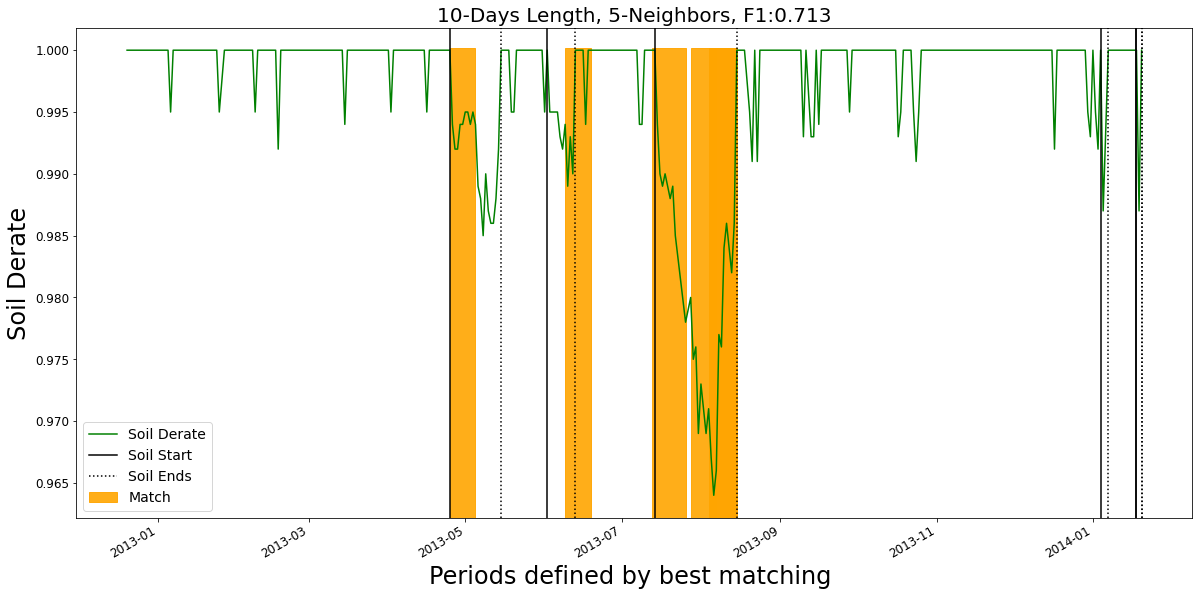

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       287
         1.0       0.87      0.60      0.71        68

    accuracy                           0.91       355
   macro avg       0.89      0.79      0.83       355
weighted avg       0.90      0.91      0.90       355



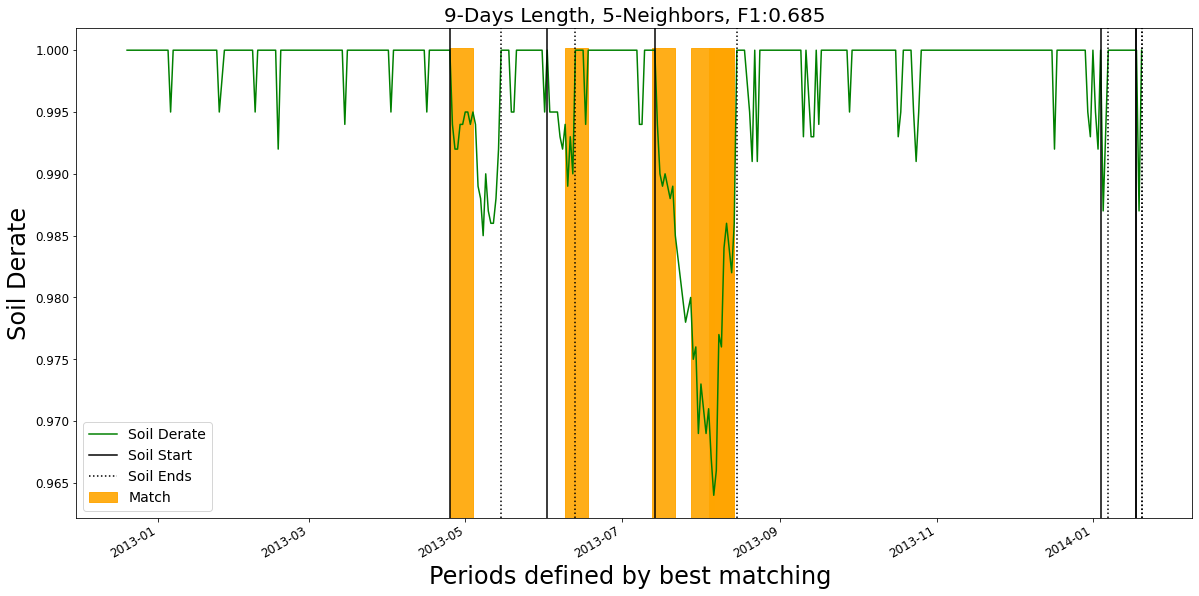

              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       287
         1.0       0.88      0.56      0.68        68

    accuracy                           0.90       355
   macro avg       0.89      0.77      0.81       355
weighted avg       0.90      0.90      0.89       355

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`
2/2
cocoa.csv
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)
We found 2 Soiling Events with decay less than 0.989 


  0%|          | 0/1082 [00:00<?, ?it/s]

  0%|          | 1/1082 [00:00<05:53,  3.06it/s]

  0%|          | 2/1082 [00:00<05:18,  3.39it/s]

  0%|          | 3/1082 [00:00<04:25,  4.06it/s]

  0%|          | 4/1082 [00:01<05:38,  3.19it/s]

  0%|          | 5/1082 [00:01<08:16,  2.17it/s]

  1%|          | 6/1082 [00:02<08:24,  2.13it/s]

  1%|          | 7/1082 [00:03<09:12,  1.95it/s]

  1%|          | 8/1082 [00:03<08:02,  2.23it/s]

  1%|          | 9/1082 [00:04<09:16,  1.93it/s]

  1%|          | 10/1082 [00:04<10:37,  1.68it/s]

  1%|          | 11/1082 [00:05<10:27,  1.71it/s]

  1%|          | 12/1082 [00:05<08:43,  2.04it/s]

  1%|          | 13/1082 [00:06<09:10,  1.94it/s]

  1%|▏         | 14/1082 [00:06<08:01,  2.22it/s]

  1%|▏         | 15/1082 [00:07<09:16,  1.92it/s]

  1%|▏         | 16/1082 [00:08<11:23,  1.56it/s]

  2%|▏         | 17/1082 [00:08<10:48,  1.64it/s]

  2%|▏         | 18/1082 [00:08<08:37,  2.06it/s]

  2%|▏         | 19/1082 [00:09<09:56,  1.78it/s]

  2%|▏         | 20/1082 [00:10<09:28,  1.87it/s]

  2%|▏         | 21/1082 [00:10<08:57,  1.98it/s]

  2%|▏         | 22/1082 [00:10<08:37,  2.05it/s]

  2%|▏         | 23/1082 [00:11<08:31,  2.07it/s]

  2%|▏         | 24/1082 [00:12<09:44,  1.81it/s]

  2%|▏         | 25/1082 [00:12<08:26,  2.09it/s]

  2%|▏         | 26/1082 [00:13<10:24,  1.69it/s]

  2%|▏         | 27/1082 [00:13<10:14,  1.72it/s]

  3%|▎         | 28/1082 [00:15<14:14,  1.23it/s]

  3%|▎         | 29/1082 [00:15<12:24,  1.41it/s]

  3%|▎         | 30/1082 [00:16<10:44,  1.63it/s]

  3%|▎         | 31/1082 [00:16<09:40,  1.81it/s]

  3%|▎         | 32/1082 [00:16<09:00,  1.94it/s]

  3%|▎         | 33/1082 [00:17<10:18,  1.70it/s]

  3%|▎         | 34/1082 [00:18<09:30,  1.84it/s]

  3%|▎         | 35/1082 [00:19<12:56,  1.35it/s]

  3%|▎         | 36/1082 [00:19<10:42,  1.63it/s]

  3%|▎         | 37/1082 [00:20<10:24,  1.67it/s]

  4%|▎         | 38/1082 [00:20<09:57,  1.75it/s]

  4%|▎         | 39/1082 [00:21<10:40,  1.63it/s]

  4%|▎         | 40/1082 [00:21<10:06,  1.72it/s]

  4%|▍         | 41/1082 [00:22<08:42,  1.99it/s]

  4%|▍         | 42/1082 [00:22<07:49,  2.21it/s]

  4%|▍         | 43/1082 [00:23<09:03,  1.91it/s]

  4%|▍         | 44/1082 [00:23<08:06,  2.13it/s]

  4%|▍         | 45/1082 [00:24<10:07,  1.71it/s]

  4%|▍         | 46/1082 [00:25<10:22,  1.66it/s]

  4%|▍         | 47/1082 [00:25<12:01,  1.43it/s]

  4%|▍         | 48/1082 [00:26<12:07,  1.42it/s]

  5%|▍         | 49/1082 [00:27<10:27,  1.65it/s]

  5%|▍         | 50/1082 [00:27<11:20,  1.52it/s]

  5%|▍         | 51/1082 [00:28<09:19,  1.84it/s]

  5%|▍         | 52/1082 [00:28<08:05,  2.12it/s]

  5%|▍         | 53/1082 [00:28<07:51,  2.18it/s]

  5%|▍         | 54/1082 [00:29<08:16,  2.07it/s]

  5%|▌         | 55/1082 [00:29<06:35,  2.60it/s]

  5%|▌         | 56/1082 [00:30<09:39,  1.77it/s]

  5%|▌         | 57/1082 [00:31<09:35,  1.78it/s]

  5%|▌         | 58/1082 [00:31<11:07,  1.54it/s]

  5%|▌         | 59/1082 [00:32<11:19,  1.51it/s]

  6%|▌         | 60/1082 [00:33<10:07,  1.68it/s]

  6%|▌         | 61/1082 [00:33<11:37,  1.46it/s]

  6%|▌         | 62/1082 [00:35<13:34,  1.25it/s]

  6%|▌         | 63/1082 [00:35<13:15,  1.28it/s]

  6%|▌         | 64/1082 [00:36<12:02,  1.41it/s]

  6%|▌         | 65/1082 [00:36<09:29,  1.79it/s]

  6%|▌         | 66/1082 [00:37<09:11,  1.84it/s]

  6%|▌         | 67/1082 [00:37<09:51,  1.72it/s]

  6%|▋         | 68/1082 [00:37<08:18,  2.03it/s]

  6%|▋         | 69/1082 [00:38<07:09,  2.36it/s]

  6%|▋         | 70/1082 [00:38<07:49,  2.16it/s]

  7%|▋         | 71/1082 [00:39<08:00,  2.10it/s]

  7%|▋         | 72/1082 [00:39<07:08,  2.36it/s]

  7%|▋         | 73/1082 [00:40<09:09,  1.84it/s]

  7%|▋         | 74/1082 [00:40<08:20,  2.01it/s]

  7%|▋         | 75/1082 [00:41<09:43,  1.73it/s]

  7%|▋         | 76/1082 [00:41<08:38,  1.94it/s]

  7%|▋         | 77/1082 [00:42<09:26,  1.77it/s]

  7%|▋         | 78/1082 [00:43<10:28,  1.60it/s]

  7%|▋         | 79/1082 [00:44<10:58,  1.52it/s]

  7%|▋         | 80/1082 [00:44<11:42,  1.43it/s]

  7%|▋         | 81/1082 [00:45<09:19,  1.79it/s]

  8%|▊         | 82/1082 [00:45<09:20,  1.78it/s]

  8%|▊         | 83/1082 [00:46<11:07,  1.50it/s]

  8%|▊         | 84/1082 [00:47<12:17,  1.35it/s]

  8%|▊         | 85/1082 [00:47<10:22,  1.60it/s]

  8%|▊         | 86/1082 [00:48<08:08,  2.04it/s]

  8%|▊         | 87/1082 [00:48<10:03,  1.65it/s]

  8%|▊         | 88/1082 [00:49<08:10,  2.02it/s]

  8%|▊         | 89/1082 [00:50<10:21,  1.60it/s]

  8%|▊         | 90/1082 [00:50<09:36,  1.72it/s]

  8%|▊         | 91/1082 [00:51<10:20,  1.60it/s]

  9%|▊         | 92/1082 [00:52<10:45,  1.53it/s]

  9%|▊         | 93/1082 [00:52<11:06,  1.48it/s]

  9%|▊         | 94/1082 [00:53<09:54,  1.66it/s]

  9%|▉         | 95/1082 [00:53<08:30,  1.93it/s]

  9%|▉         | 96/1082 [00:54<08:30,  1.93it/s]

  9%|▉         | 97/1082 [00:54<09:56,  1.65it/s]

  9%|▉         | 98/1082 [00:55<11:50,  1.39it/s]

  9%|▉         | 99/1082 [00:56<12:07,  1.35it/s]

  9%|▉         | 100/1082 [00:57<13:15,  1.23it/s]

  9%|▉         | 101/1082 [00:58<11:20,  1.44it/s]

  9%|▉         | 102/1082 [00:58<10:04,  1.62it/s]

 10%|▉         | 103/1082 [00:59<10:52,  1.50it/s]

 10%|▉         | 104/1082 [00:59<08:55,  1.83it/s]

 10%|▉         | 105/1082 [01:00<10:34,  1.54it/s]

 10%|▉         | 106/1082 [01:00<08:24,  1.94it/s]

 10%|▉         | 107/1082 [01:01<08:43,  1.86it/s]

 10%|▉         | 108/1082 [01:02<10:17,  1.58it/s]

 10%|█         | 109/1082 [01:02<09:34,  1.69it/s]

 10%|█         | 110/1082 [01:03<10:07,  1.60it/s]

 10%|█         | 111/1082 [01:03<10:02,  1.61it/s]

 10%|█         | 112/1082 [01:05<12:54,  1.25it/s]

 10%|█         | 113/1082 [01:05<09:58,  1.62it/s]

 11%|█         | 114/1082 [01:05<08:43,  1.85it/s]

 11%|█         | 115/1082 [01:06<08:37,  1.87it/s]

 11%|█         | 116/1082 [01:06<07:26,  2.16it/s]

 11%|█         | 117/1082 [01:07<09:48,  1.64it/s]

 11%|█         | 118/1082 [01:08<10:40,  1.51it/s]

 11%|█         | 119/1082 [01:08<08:31,  1.88it/s]

 11%|█         | 120/1082 [01:09<09:17,  1.73it/s]

 11%|█         | 121/1082 [01:09<09:47,  1.64it/s]

 11%|█▏        | 122/1082 [01:10<08:32,  1.87it/s]

 11%|█▏        | 123/1082 [01:10<07:45,  2.06it/s]

 11%|█▏        | 124/1082 [01:11<08:28,  1.89it/s]

 12%|█▏        | 125/1082 [01:11<07:28,  2.13it/s]

 12%|█▏        | 126/1082 [01:12<09:13,  1.73it/s]

 12%|█▏        | 127/1082 [01:13<10:30,  1.52it/s]

 12%|█▏        | 128/1082 [01:13<10:44,  1.48it/s]

 12%|█▏        | 129/1082 [01:15<13:28,  1.18it/s]

 12%|█▏        | 130/1082 [01:15<10:52,  1.46it/s]

 12%|█▏        | 131/1082 [01:16<11:02,  1.43it/s]

 12%|█▏        | 132/1082 [01:16<10:30,  1.51it/s]

 12%|█▏        | 133/1082 [01:17<10:05,  1.57it/s]

 12%|█▏        | 134/1082 [01:18<10:20,  1.53it/s]

 12%|█▏        | 135/1082 [01:18<11:16,  1.40it/s]

 13%|█▎        | 136/1082 [01:19<10:34,  1.49it/s]

 13%|█▎        | 137/1082 [01:20<10:45,  1.46it/s]

 13%|█▎        | 138/1082 [01:20<10:56,  1.44it/s]

 13%|█▎        | 139/1082 [01:21<11:26,  1.37it/s]

 13%|█▎        | 140/1082 [01:22<11:54,  1.32it/s]

 13%|█▎        | 141/1082 [01:22<09:59,  1.57it/s]

 13%|█▎        | 142/1082 [01:23<09:42,  1.61it/s]

 13%|█▎        | 143/1082 [01:24<10:32,  1.48it/s]

 13%|█▎        | 144/1082 [01:24<10:02,  1.56it/s]

 13%|█▎        | 145/1082 [01:25<10:16,  1.52it/s]

 13%|█▎        | 146/1082 [01:25<09:27,  1.65it/s]

 14%|█▎        | 147/1082 [01:26<09:49,  1.59it/s]

 14%|█▎        | 148/1082 [01:27<10:24,  1.50it/s]

 14%|█▍        | 149/1082 [01:27<09:21,  1.66it/s]

 14%|█▍        | 150/1082 [01:28<09:43,  1.60it/s]

 14%|█▍        | 151/1082 [01:28<07:50,  1.98it/s]

 14%|█▍        | 152/1082 [01:29<08:36,  1.80it/s]

 14%|█▍        | 153/1082 [01:29<08:25,  1.84it/s]

 14%|█▍        | 154/1082 [01:30<09:41,  1.60it/s]

 14%|█▍        | 155/1082 [01:31<09:50,  1.57it/s]

 14%|█▍        | 156/1082 [01:32<10:57,  1.41it/s]

 15%|█▍        | 157/1082 [01:32<10:21,  1.49it/s]

 15%|█▍        | 158/1082 [01:33<11:56,  1.29it/s]

 15%|█▍        | 159/1082 [01:34<11:42,  1.31it/s]

 15%|█▍        | 160/1082 [01:34<08:55,  1.72it/s]

 15%|█▍        | 161/1082 [01:35<08:44,  1.75it/s]

 15%|█▍        | 162/1082 [01:36<10:29,  1.46it/s]

 15%|█▌        | 163/1082 [01:37<10:26,  1.47it/s]

 15%|█▌        | 164/1082 [01:37<09:26,  1.62it/s]

 15%|█▌        | 165/1082 [01:38<10:15,  1.49it/s]

 15%|█▌        | 166/1082 [01:38<08:28,  1.80it/s]

 15%|█▌        | 167/1082 [01:38<07:34,  2.01it/s]

 16%|█▌        | 168/1082 [01:39<07:35,  2.00it/s]

 16%|█▌        | 169/1082 [01:39<07:44,  1.97it/s]

 16%|█▌        | 170/1082 [01:40<06:41,  2.27it/s]

 16%|█▌        | 171/1082 [01:40<07:03,  2.15it/s]

 16%|█▌        | 172/1082 [01:41<07:52,  1.93it/s]

 16%|█▌        | 173/1082 [01:41<07:22,  2.05it/s]

 16%|█▌        | 174/1082 [01:42<06:29,  2.33it/s]

 16%|█▌        | 175/1082 [01:43<08:51,  1.71it/s]

 16%|█▋        | 176/1082 [01:43<06:59,  2.16it/s]

 16%|█▋        | 177/1082 [01:43<07:19,  2.06it/s]

 16%|█▋        | 178/1082 [01:45<11:15,  1.34it/s]

 17%|█▋        | 179/1082 [01:45<11:44,  1.28it/s]

 17%|█▋        | 180/1082 [01:46<09:29,  1.58it/s]

 17%|█▋        | 181/1082 [01:46<08:48,  1.71it/s]

 17%|█▋        | 182/1082 [01:47<08:18,  1.81it/s]

 17%|█▋        | 183/1082 [01:47<08:45,  1.71it/s]

 17%|█▋        | 184/1082 [01:48<09:54,  1.51it/s]

 17%|█▋        | 185/1082 [01:49<10:52,  1.38it/s]

 17%|█▋        | 186/1082 [01:50<10:09,  1.47it/s]

 17%|█▋        | 187/1082 [01:50<09:15,  1.61it/s]

 17%|█▋        | 188/1082 [01:51<09:47,  1.52it/s]

 17%|█▋        | 189/1082 [01:52<11:16,  1.32it/s]

 18%|█▊        | 190/1082 [01:53<10:43,  1.39it/s]

 18%|█▊        | 191/1082 [01:53<10:30,  1.41it/s]

 18%|█▊        | 192/1082 [01:55<13:37,  1.09it/s]

 18%|█▊        | 193/1082 [01:55<10:32,  1.41it/s]

 18%|█▊        | 194/1082 [01:55<09:53,  1.50it/s]

 18%|█▊        | 195/1082 [01:56<07:26,  1.99it/s]

 18%|█▊        | 196/1082 [01:56<09:00,  1.64it/s]

 18%|█▊        | 197/1082 [01:57<08:07,  1.81it/s]

 18%|█▊        | 198/1082 [01:57<08:09,  1.81it/s]

 18%|█▊        | 199/1082 [01:58<08:24,  1.75it/s]

 18%|█▊        | 200/1082 [01:59<08:52,  1.66it/s]

 19%|█▊        | 201/1082 [01:59<08:07,  1.81it/s]

 19%|█▊        | 202/1082 [01:59<06:30,  2.26it/s]

 19%|█▉        | 203/1082 [02:00<06:21,  2.30it/s]

 19%|█▉        | 204/1082 [02:00<06:22,  2.29it/s]

 19%|█▉        | 205/1082 [02:01<06:50,  2.14it/s]

 19%|█▉        | 206/1082 [02:02<08:41,  1.68it/s]

 19%|█▉        | 207/1082 [02:02<07:01,  2.08it/s]

 19%|█▉        | 208/1082 [02:03<08:32,  1.71it/s]

 19%|█▉        | 209/1082 [02:03<07:47,  1.87it/s]

 19%|█▉        | 210/1082 [02:04<09:10,  1.59it/s]

 20%|█▉        | 211/1082 [02:04<07:51,  1.85it/s]

 20%|█▉        | 212/1082 [02:05<08:11,  1.77it/s]

 20%|█▉        | 213/1082 [02:05<07:37,  1.90it/s]

 20%|█▉        | 214/1082 [02:06<08:27,  1.71it/s]

 20%|█▉        | 215/1082 [02:06<07:11,  2.01it/s]

 20%|█▉        | 216/1082 [02:07<07:32,  1.91it/s]

 20%|██        | 217/1082 [02:08<08:04,  1.78it/s]

 20%|██        | 218/1082 [02:08<07:57,  1.81it/s]

 20%|██        | 219/1082 [02:09<07:34,  1.90it/s]

 20%|██        | 220/1082 [02:09<07:32,  1.90it/s]

 20%|██        | 221/1082 [02:10<08:51,  1.62it/s]

 21%|██        | 222/1082 [02:11<09:37,  1.49it/s]

 21%|██        | 223/1082 [02:11<09:01,  1.59it/s]

 21%|██        | 224/1082 [02:12<09:03,  1.58it/s]

 21%|██        | 225/1082 [02:13<09:31,  1.50it/s]

 21%|██        | 226/1082 [02:13<09:45,  1.46it/s]

 21%|██        | 227/1082 [02:15<12:10,  1.17it/s]

 21%|██        | 228/1082 [02:15<09:16,  1.53it/s]

 21%|██        | 229/1082 [02:15<07:57,  1.79it/s]

 21%|██▏       | 230/1082 [02:16<08:30,  1.67it/s]

 21%|██▏       | 231/1082 [02:16<08:50,  1.60it/s]

 21%|██▏       | 232/1082 [02:17<09:28,  1.50it/s]

 22%|██▏       | 233/1082 [02:18<10:09,  1.39it/s]

 22%|██▏       | 234/1082 [02:18<08:48,  1.60it/s]

 22%|██▏       | 235/1082 [02:19<08:19,  1.69it/s]

 22%|██▏       | 236/1082 [02:19<07:16,  1.94it/s]

 22%|██▏       | 237/1082 [02:20<07:15,  1.94it/s]

 22%|██▏       | 238/1082 [02:20<07:33,  1.86it/s]

 22%|██▏       | 239/1082 [02:21<07:57,  1.77it/s]

 22%|██▏       | 240/1082 [02:22<07:56,  1.77it/s]

 22%|██▏       | 241/1082 [02:22<06:55,  2.02it/s]

 22%|██▏       | 242/1082 [02:22<05:33,  2.52it/s]

 22%|██▏       | 243/1082 [02:23<07:43,  1.81it/s]

 23%|██▎       | 244/1082 [02:24<07:32,  1.85it/s]

 23%|██▎       | 245/1082 [02:24<09:01,  1.55it/s]

 23%|██▎       | 246/1082 [02:25<07:43,  1.80it/s]

 23%|██▎       | 247/1082 [02:25<08:07,  1.71it/s]

 23%|██▎       | 248/1082 [02:26<06:20,  2.19it/s]

 23%|██▎       | 249/1082 [02:26<07:39,  1.81it/s]

 23%|██▎       | 250/1082 [02:27<08:19,  1.67it/s]

 23%|██▎       | 251/1082 [02:28<08:14,  1.68it/s]

 23%|██▎       | 252/1082 [02:28<08:35,  1.61it/s]

 23%|██▎       | 253/1082 [02:29<06:44,  2.05it/s]

 23%|██▎       | 254/1082 [02:29<07:35,  1.82it/s]

 24%|██▎       | 255/1082 [02:30<08:30,  1.62it/s]

 24%|██▎       | 256/1082 [02:31<09:10,  1.50it/s]

 24%|██▍       | 257/1082 [02:31<09:14,  1.49it/s]

 24%|██▍       | 258/1082 [02:32<09:42,  1.41it/s]

 24%|██▍       | 259/1082 [02:33<08:41,  1.58it/s]

 24%|██▍       | 260/1082 [02:33<07:13,  1.90it/s]

 24%|██▍       | 261/1082 [02:33<06:20,  2.16it/s]

 24%|██▍       | 262/1082 [02:35<10:30,  1.30it/s]

 24%|██▍       | 263/1082 [02:36<11:12,  1.22it/s]

 24%|██▍       | 264/1082 [02:36<10:26,  1.31it/s]

 24%|██▍       | 265/1082 [02:37<08:01,  1.70it/s]

 25%|██▍       | 266/1082 [02:37<08:28,  1.60it/s]

 25%|██▍       | 267/1082 [02:38<08:46,  1.55it/s]

 25%|██▍       | 268/1082 [02:38<08:16,  1.64it/s]

 25%|██▍       | 269/1082 [02:39<07:31,  1.80it/s]

 25%|██▍       | 270/1082 [02:39<07:22,  1.84it/s]

 25%|██▌       | 271/1082 [02:40<08:14,  1.64it/s]

 25%|██▌       | 272/1082 [02:41<08:48,  1.53it/s]

 25%|██▌       | 273/1082 [02:41<07:29,  1.80it/s]

 25%|██▌       | 274/1082 [02:42<07:55,  1.70it/s]

 25%|██▌       | 275/1082 [02:42<07:29,  1.79it/s]

 26%|██▌       | 276/1082 [02:43<07:31,  1.79it/s]

 26%|██▌       | 277/1082 [02:43<07:10,  1.87it/s]

 26%|██▌       | 278/1082 [02:45<10:20,  1.30it/s]

 26%|██▌       | 279/1082 [02:45<09:55,  1.35it/s]

 26%|██▌       | 280/1082 [02:46<09:24,  1.42it/s]

 26%|██▌       | 281/1082 [02:47<08:58,  1.49it/s]

 26%|██▌       | 282/1082 [02:47<09:20,  1.43it/s]

 26%|██▌       | 283/1082 [02:48<08:16,  1.61it/s]

 26%|██▌       | 284/1082 [02:48<07:26,  1.79it/s]

 26%|██▋       | 285/1082 [02:49<07:06,  1.87it/s]

 26%|██▋       | 286/1082 [02:50<07:55,  1.68it/s]

 27%|██▋       | 287/1082 [02:50<08:37,  1.54it/s]

 27%|██▋       | 288/1082 [02:51<09:52,  1.34it/s]

 27%|██▋       | 289/1082 [02:52<09:24,  1.40it/s]

 27%|██▋       | 290/1082 [02:52<08:40,  1.52it/s]

 27%|██▋       | 291/1082 [02:53<07:11,  1.83it/s]

 27%|██▋       | 292/1082 [02:53<06:13,  2.11it/s]

 27%|██▋       | 293/1082 [02:54<07:07,  1.85it/s]

 27%|██▋       | 294/1082 [02:55<10:01,  1.31it/s]

 27%|██▋       | 295/1082 [02:55<08:18,  1.58it/s]

 27%|██▋       | 296/1082 [02:56<07:42,  1.70it/s]

 27%|██▋       | 297/1082 [02:57<08:44,  1.50it/s]

 28%|██▊       | 298/1082 [02:57<07:14,  1.80it/s]

 28%|██▊       | 299/1082 [02:58<08:07,  1.61it/s]

 28%|██▊       | 300/1082 [02:59<09:23,  1.39it/s]

 28%|██▊       | 301/1082 [02:59<08:04,  1.61it/s]

 28%|██▊       | 302/1082 [02:59<07:17,  1.78it/s]

 28%|██▊       | 303/1082 [03:00<08:04,  1.61it/s]

 28%|██▊       | 304/1082 [03:00<06:15,  2.07it/s]

 28%|██▊       | 305/1082 [03:01<07:10,  1.81it/s]

 28%|██▊       | 306/1082 [03:02<07:59,  1.62it/s]

 28%|██▊       | 307/1082 [03:02<07:24,  1.74it/s]

 28%|██▊       | 308/1082 [03:03<07:24,  1.74it/s]

 29%|██▊       | 309/1082 [03:03<06:45,  1.90it/s]

 29%|██▊       | 310/1082 [03:04<09:06,  1.41it/s]

 29%|██▊       | 311/1082 [03:05<08:29,  1.51it/s]

 29%|██▉       | 312/1082 [03:06<08:26,  1.52it/s]

 29%|██▉       | 313/1082 [03:06<08:05,  1.58it/s]

 29%|██▉       | 314/1082 [03:07<07:46,  1.65it/s]

 29%|██▉       | 315/1082 [03:07<07:40,  1.66it/s]

 29%|██▉       | 316/1082 [03:08<07:55,  1.61it/s]

 29%|██▉       | 317/1082 [03:08<06:47,  1.88it/s]

 29%|██▉       | 318/1082 [03:09<06:44,  1.89it/s]

 29%|██▉       | 319/1082 [03:09<06:58,  1.83it/s]

 30%|██▉       | 320/1082 [03:10<07:41,  1.65it/s]

 30%|██▉       | 321/1082 [03:11<07:18,  1.73it/s]

 30%|██▉       | 322/1082 [03:11<06:22,  1.99it/s]

 30%|██▉       | 323/1082 [03:12<06:50,  1.85it/s]

 30%|██▉       | 324/1082 [03:12<07:28,  1.69it/s]

 30%|███       | 325/1082 [03:13<06:13,  2.03it/s]

 30%|███       | 326/1082 [03:13<06:06,  2.07it/s]

 30%|███       | 327/1082 [03:14<06:22,  1.97it/s]

 30%|███       | 328/1082 [03:14<06:32,  1.92it/s]

 30%|███       | 329/1082 [03:15<07:06,  1.77it/s]

 30%|███       | 330/1082 [03:16<08:38,  1.45it/s]

 31%|███       | 331/1082 [03:16<07:58,  1.57it/s]

 31%|███       | 332/1082 [03:17<08:05,  1.55it/s]

 31%|███       | 333/1082 [03:17<06:23,  1.95it/s]

 31%|███       | 334/1082 [03:18<06:50,  1.82it/s]

 31%|███       | 335/1082 [03:18<06:34,  1.89it/s]

 31%|███       | 336/1082 [03:19<07:06,  1.75it/s]

 31%|███       | 337/1082 [03:20<07:48,  1.59it/s]

 31%|███       | 338/1082 [03:20<07:40,  1.61it/s]

 31%|███▏      | 339/1082 [03:21<07:27,  1.66it/s]

 31%|███▏      | 340/1082 [03:22<08:23,  1.47it/s]

 32%|███▏      | 341/1082 [03:23<08:29,  1.45it/s]

 32%|███▏      | 342/1082 [03:23<08:19,  1.48it/s]

 32%|███▏      | 343/1082 [03:24<10:18,  1.20it/s]

 32%|███▏      | 344/1082 [03:25<08:42,  1.41it/s]

 32%|███▏      | 345/1082 [03:25<08:06,  1.51it/s]

 32%|███▏      | 346/1082 [03:26<07:17,  1.68it/s]

 32%|███▏      | 347/1082 [03:26<06:46,  1.81it/s]

 32%|███▏      | 348/1082 [03:27<07:12,  1.70it/s]

 32%|███▏      | 349/1082 [03:28<07:07,  1.71it/s]

 32%|███▏      | 350/1082 [03:28<07:03,  1.73it/s]

 32%|███▏      | 351/1082 [03:29<07:32,  1.62it/s]

 33%|███▎      | 352/1082 [03:30<08:22,  1.45it/s]

 33%|███▎      | 353/1082 [03:30<08:56,  1.36it/s]

 33%|███▎      | 354/1082 [03:31<07:50,  1.55it/s]

 33%|███▎      | 355/1082 [03:32<08:25,  1.44it/s]

 33%|███▎      | 356/1082 [03:32<07:26,  1.63it/s]

 33%|███▎      | 357/1082 [03:33<07:35,  1.59it/s]

 33%|███▎      | 358/1082 [03:34<08:36,  1.40it/s]

 33%|███▎      | 359/1082 [03:35<08:45,  1.37it/s]

 33%|███▎      | 360/1082 [03:35<09:09,  1.31it/s]

 33%|███▎      | 361/1082 [03:36<08:18,  1.45it/s]

 33%|███▎      | 362/1082 [03:36<07:48,  1.54it/s]

 34%|███▎      | 363/1082 [03:37<08:28,  1.41it/s]

 34%|███▎      | 364/1082 [03:38<08:04,  1.48it/s]

 34%|███▎      | 365/1082 [03:38<06:07,  1.95it/s]

 34%|███▍      | 366/1082 [03:39<07:23,  1.61it/s]

 34%|███▍      | 367/1082 [03:40<08:41,  1.37it/s]

 34%|███▍      | 368/1082 [03:41<08:38,  1.38it/s]

 34%|███▍      | 369/1082 [03:41<08:41,  1.37it/s]

 34%|███▍      | 370/1082 [03:42<08:16,  1.44it/s]

 34%|███▍      | 371/1082 [03:43<08:19,  1.42it/s]

 34%|███▍      | 372/1082 [03:43<08:38,  1.37it/s]

 34%|███▍      | 373/1082 [03:45<09:52,  1.20it/s]

 35%|███▍      | 374/1082 [03:45<10:15,  1.15it/s]

 35%|███▍      | 375/1082 [03:46<09:11,  1.28it/s]

 35%|███▍      | 376/1082 [03:47<08:32,  1.38it/s]

 35%|███▍      | 377/1082 [03:47<08:54,  1.32it/s]

 35%|███▍      | 378/1082 [03:48<07:50,  1.50it/s]

 35%|███▌      | 379/1082 [03:48<07:03,  1.66it/s]

 35%|███▌      | 380/1082 [03:49<06:10,  1.89it/s]

 35%|███▌      | 381/1082 [03:49<05:54,  1.98it/s]

 35%|███▌      | 382/1082 [03:50<05:38,  2.07it/s]

 35%|███▌      | 383/1082 [03:50<05:09,  2.26it/s]

 35%|███▌      | 384/1082 [03:51<06:59,  1.67it/s]

 36%|███▌      | 385/1082 [03:51<06:26,  1.80it/s]

 36%|███▌      | 386/1082 [03:52<06:39,  1.74it/s]

 36%|███▌      | 387/1082 [03:53<07:07,  1.62it/s]

 36%|███▌      | 388/1082 [03:54<07:57,  1.45it/s]

 36%|███▌      | 389/1082 [03:54<07:16,  1.59it/s]

 36%|███▌      | 390/1082 [03:55<06:49,  1.69it/s]

 36%|███▌      | 391/1082 [03:55<07:05,  1.62it/s]

 36%|███▌      | 392/1082 [03:56<06:46,  1.70it/s]

 36%|███▋      | 393/1082 [03:56<07:05,  1.62it/s]

 36%|███▋      | 394/1082 [03:57<07:35,  1.51it/s]

 37%|███▋      | 395/1082 [03:58<06:58,  1.64it/s]

 37%|███▋      | 396/1082 [03:59<07:50,  1.46it/s]

 37%|███▋      | 397/1082 [03:59<06:42,  1.70it/s]

 37%|███▋      | 398/1082 [03:59<05:39,  2.02it/s]

 37%|███▋      | 399/1082 [04:00<05:32,  2.05it/s]

 37%|███▋      | 400/1082 [04:00<05:36,  2.03it/s]

 37%|███▋      | 401/1082 [04:01<06:16,  1.81it/s]

 37%|███▋      | 402/1082 [04:01<05:46,  1.96it/s]

 37%|███▋      | 403/1082 [04:02<05:49,  1.95it/s]

 37%|███▋      | 404/1082 [04:02<05:34,  2.03it/s]

 37%|███▋      | 405/1082 [04:03<05:37,  2.01it/s]

 38%|███▊      | 406/1082 [04:04<06:46,  1.66it/s]

 38%|███▊      | 407/1082 [04:05<08:15,  1.36it/s]

 38%|███▊      | 408/1082 [04:05<07:37,  1.47it/s]

 38%|███▊      | 409/1082 [04:06<06:47,  1.65it/s]

 38%|███▊      | 410/1082 [04:07<07:48,  1.43it/s]

 38%|███▊      | 411/1082 [04:07<07:20,  1.52it/s]

 38%|███▊      | 412/1082 [04:07<06:03,  1.84it/s]

 38%|███▊      | 413/1082 [04:08<06:55,  1.61it/s]

 38%|███▊      | 414/1082 [04:09<07:39,  1.45it/s]

 38%|███▊      | 415/1082 [04:10<06:59,  1.59it/s]

 38%|███▊      | 416/1082 [04:10<06:14,  1.78it/s]

 39%|███▊      | 417/1082 [04:10<05:30,  2.01it/s]

 39%|███▊      | 418/1082 [04:11<06:27,  1.71it/s]

 39%|███▊      | 419/1082 [04:12<07:33,  1.46it/s]

 39%|███▉      | 420/1082 [04:13<08:02,  1.37it/s]

 39%|███▉      | 421/1082 [04:13<07:27,  1.48it/s]

 39%|███▉      | 422/1082 [04:14<07:56,  1.38it/s]

 39%|███▉      | 423/1082 [04:15<07:16,  1.51it/s]

 39%|███▉      | 424/1082 [04:16<08:18,  1.32it/s]

 39%|███▉      | 425/1082 [04:16<07:08,  1.53it/s]

 39%|███▉      | 426/1082 [04:17<07:01,  1.56it/s]

 39%|███▉      | 427/1082 [04:18<07:31,  1.45it/s]

 40%|███▉      | 428/1082 [04:18<06:16,  1.74it/s]

 40%|███▉      | 429/1082 [04:19<06:40,  1.63it/s]

 40%|███▉      | 430/1082 [04:19<06:58,  1.56it/s]

 40%|███▉      | 431/1082 [04:20<07:58,  1.36it/s]

 40%|███▉      | 432/1082 [04:21<08:02,  1.35it/s]

 40%|████      | 433/1082 [04:21<06:50,  1.58it/s]

 40%|████      | 434/1082 [04:22<07:06,  1.52it/s]

 40%|████      | 435/1082 [04:23<06:37,  1.63it/s]

 40%|████      | 436/1082 [04:23<06:33,  1.64it/s]

 40%|████      | 437/1082 [04:24<08:47,  1.22it/s]

 40%|████      | 438/1082 [04:25<08:07,  1.32it/s]

 41%|████      | 439/1082 [04:26<07:11,  1.49it/s]

 41%|████      | 440/1082 [04:26<05:53,  1.82it/s]

 41%|████      | 441/1082 [04:26<04:56,  2.16it/s]

 41%|████      | 442/1082 [04:27<05:17,  2.01it/s]

 41%|████      | 443/1082 [04:27<04:35,  2.32it/s]

 41%|████      | 444/1082 [04:28<05:21,  1.98it/s]

 41%|████      | 445/1082 [04:28<05:23,  1.97it/s]

 41%|████      | 446/1082 [04:29<06:09,  1.72it/s]

 41%|████▏     | 447/1082 [04:30<06:25,  1.65it/s]

 41%|████▏     | 448/1082 [04:30<07:05,  1.49it/s]

 41%|████▏     | 449/1082 [04:31<07:16,  1.45it/s]

 42%|████▏     | 450/1082 [04:31<05:58,  1.76it/s]

 42%|████▏     | 451/1082 [04:32<06:49,  1.54it/s]

 42%|████▏     | 452/1082 [04:33<06:01,  1.74it/s]

 42%|████▏     | 453/1082 [04:33<05:23,  1.95it/s]

 42%|████▏     | 454/1082 [04:34<05:46,  1.81it/s]

 42%|████▏     | 455/1082 [04:35<07:26,  1.40it/s]

 42%|████▏     | 456/1082 [04:35<06:07,  1.70it/s]

 42%|████▏     | 457/1082 [04:36<07:17,  1.43it/s]

 42%|████▏     | 458/1082 [04:37<07:33,  1.38it/s]

 42%|████▏     | 459/1082 [04:37<06:27,  1.61it/s]

 43%|████▎     | 460/1082 [04:38<06:09,  1.68it/s]

 43%|████▎     | 461/1082 [04:38<06:05,  1.70it/s]

 43%|████▎     | 462/1082 [04:39<06:05,  1.69it/s]

 43%|████▎     | 463/1082 [04:39<05:17,  1.95it/s]

 43%|████▎     | 464/1082 [04:40<05:44,  1.79it/s]

 43%|████▎     | 465/1082 [04:41<06:32,  1.57it/s]

 43%|████▎     | 466/1082 [04:41<06:21,  1.61it/s]

 43%|████▎     | 467/1082 [04:42<06:49,  1.50it/s]

 43%|████▎     | 468/1082 [04:43<06:22,  1.60it/s]

 43%|████▎     | 469/1082 [04:43<05:34,  1.83it/s]

 43%|████▎     | 470/1082 [04:43<05:29,  1.86it/s]

 44%|████▎     | 471/1082 [04:45<07:37,  1.34it/s]

 44%|████▎     | 472/1082 [04:46<08:51,  1.15it/s]

 44%|████▎     | 473/1082 [04:47<08:27,  1.20it/s]

 44%|████▍     | 474/1082 [04:47<07:22,  1.37it/s]

 44%|████▍     | 475/1082 [04:47<06:22,  1.59it/s]

 44%|████▍     | 476/1082 [04:48<06:07,  1.65it/s]

 44%|████▍     | 477/1082 [04:48<05:49,  1.73it/s]

 44%|████▍     | 478/1082 [04:49<05:52,  1.71it/s]

 44%|████▍     | 479/1082 [04:50<05:38,  1.78it/s]

 44%|████▍     | 480/1082 [04:50<04:31,  2.22it/s]

 44%|████▍     | 481/1082 [04:50<03:47,  2.65it/s]

 45%|████▍     | 482/1082 [04:51<05:22,  1.86it/s]

 45%|████▍     | 483/1082 [04:52<06:06,  1.63it/s]

 45%|████▍     | 484/1082 [04:52<06:00,  1.66it/s]

 45%|████▍     | 485/1082 [04:53<06:16,  1.59it/s]

 45%|████▍     | 486/1082 [04:54<06:33,  1.52it/s]

 45%|████▌     | 487/1082 [04:54<06:42,  1.48it/s]

 45%|████▌     | 488/1082 [04:55<07:03,  1.40it/s]

 45%|████▌     | 489/1082 [04:56<07:00,  1.41it/s]

 45%|████▌     | 490/1082 [04:56<05:50,  1.69it/s]

 45%|████▌     | 491/1082 [04:57<05:39,  1.74it/s]

 45%|████▌     | 492/1082 [04:57<05:01,  1.96it/s]

 46%|████▌     | 493/1082 [04:57<04:30,  2.18it/s]

 46%|████▌     | 494/1082 [04:58<04:36,  2.13it/s]

 46%|████▌     | 495/1082 [04:58<04:03,  2.41it/s]

 46%|████▌     | 496/1082 [04:59<04:56,  1.97it/s]

 46%|████▌     | 497/1082 [04:59<04:58,  1.96it/s]

 46%|████▌     | 498/1082 [05:00<04:28,  2.18it/s]

 46%|████▌     | 499/1082 [05:01<05:14,  1.86it/s]

 46%|████▌     | 500/1082 [05:01<05:29,  1.77it/s]

 46%|████▋     | 501/1082 [05:02<05:47,  1.67it/s]

 46%|████▋     | 502/1082 [05:02<05:43,  1.69it/s]

 46%|████▋     | 503/1082 [05:03<05:58,  1.62it/s]

 47%|████▋     | 504/1082 [05:04<07:27,  1.29it/s]

 47%|████▋     | 505/1082 [05:05<06:58,  1.38it/s]

 47%|████▋     | 506/1082 [05:06<06:57,  1.38it/s]

 47%|████▋     | 507/1082 [05:06<07:19,  1.31it/s]

 47%|████▋     | 508/1082 [05:07<07:02,  1.36it/s]

 47%|████▋     | 509/1082 [05:08<06:24,  1.49it/s]

 47%|████▋     | 510/1082 [05:08<06:31,  1.46it/s]

 47%|████▋     | 511/1082 [05:09<05:47,  1.65it/s]

 47%|████▋     | 512/1082 [05:09<05:24,  1.76it/s]

 47%|████▋     | 513/1082 [05:10<04:40,  2.03it/s]

 48%|████▊     | 514/1082 [05:10<04:47,  1.98it/s]

 48%|████▊     | 515/1082 [05:10<04:13,  2.24it/s]

 48%|████▊     | 516/1082 [05:11<04:54,  1.93it/s]

 48%|████▊     | 517/1082 [05:12<05:52,  1.60it/s]

 48%|████▊     | 518/1082 [05:13<05:59,  1.57it/s]

 48%|████▊     | 519/1082 [05:13<05:21,  1.75it/s]

 48%|████▊     | 520/1082 [05:14<05:27,  1.72it/s]

 48%|████▊     | 521/1082 [05:15<06:56,  1.35it/s]

 48%|████▊     | 522/1082 [05:15<06:37,  1.41it/s]

 48%|████▊     | 523/1082 [05:16<07:31,  1.24it/s]

 48%|████▊     | 524/1082 [05:17<07:14,  1.28it/s]

 49%|████▊     | 525/1082 [05:18<07:37,  1.22it/s]

 49%|████▊     | 526/1082 [05:19<06:42,  1.38it/s]

 49%|████▊     | 527/1082 [05:19<06:09,  1.50it/s]

 49%|████▉     | 528/1082 [05:20<06:02,  1.53it/s]

 49%|████▉     | 529/1082 [05:20<05:54,  1.56it/s]

 49%|████▉     | 530/1082 [05:21<06:27,  1.43it/s]

 49%|████▉     | 531/1082 [05:22<06:24,  1.43it/s]

 49%|████▉     | 532/1082 [05:22<05:42,  1.60it/s]

 49%|████▉     | 533/1082 [05:23<06:11,  1.48it/s]

 49%|████▉     | 534/1082 [05:24<07:31,  1.21it/s]

 49%|████▉     | 535/1082 [05:25<07:06,  1.28it/s]

 50%|████▉     | 536/1082 [05:26<07:26,  1.22it/s]

 50%|████▉     | 537/1082 [05:26<06:40,  1.36it/s]

 50%|████▉     | 538/1082 [05:27<05:31,  1.64it/s]

 50%|████▉     | 539/1082 [05:27<05:14,  1.73it/s]

 50%|████▉     | 540/1082 [05:28<05:18,  1.70it/s]

 50%|█████     | 541/1082 [05:28<04:54,  1.84it/s]

 50%|█████     | 542/1082 [05:29<04:32,  1.98it/s]

 50%|█████     | 543/1082 [05:29<04:06,  2.19it/s]

 50%|█████     | 544/1082 [05:30<05:21,  1.67it/s]

 50%|█████     | 545/1082 [05:31<05:29,  1.63it/s]

 50%|█████     | 546/1082 [05:31<05:28,  1.63it/s]

 51%|█████     | 547/1082 [05:32<05:01,  1.77it/s]

 51%|█████     | 548/1082 [05:33<05:40,  1.57it/s]

 51%|█████     | 549/1082 [05:33<04:45,  1.87it/s]

 51%|█████     | 550/1082 [05:33<04:50,  1.83it/s]

 51%|█████     | 551/1082 [05:35<07:54,  1.12it/s]

 51%|█████     | 552/1082 [05:36<07:28,  1.18it/s]

 51%|█████     | 553/1082 [05:37<07:03,  1.25it/s]

 51%|█████     | 554/1082 [05:38<07:44,  1.14it/s]

 51%|█████▏    | 555/1082 [05:38<06:38,  1.32it/s]

 51%|█████▏    | 556/1082 [05:39<06:41,  1.31it/s]

 51%|█████▏    | 557/1082 [05:39<05:38,  1.55it/s]

 52%|█████▏    | 558/1082 [05:40<06:14,  1.40it/s]

 52%|█████▏    | 559/1082 [05:41<05:44,  1.52it/s]

 52%|█████▏    | 560/1082 [05:42<06:36,  1.32it/s]

 52%|█████▏    | 561/1082 [05:42<06:39,  1.30it/s]

 52%|█████▏    | 562/1082 [05:43<06:19,  1.37it/s]

 52%|█████▏    | 563/1082 [05:43<05:07,  1.69it/s]

 52%|█████▏    | 564/1082 [05:45<06:49,  1.26it/s]

 52%|█████▏    | 565/1082 [05:45<06:44,  1.28it/s]

 52%|█████▏    | 566/1082 [05:46<06:33,  1.31it/s]

 52%|█████▏    | 567/1082 [05:47<06:06,  1.41it/s]

 52%|█████▏    | 568/1082 [05:47<05:35,  1.53it/s]

 53%|█████▎    | 569/1082 [05:48<05:38,  1.52it/s]

 53%|█████▎    | 570/1082 [05:48<04:12,  2.02it/s]

 53%|█████▎    | 571/1082 [05:49<05:40,  1.50it/s]

 53%|█████▎    | 572/1082 [05:50<05:41,  1.49it/s]

 53%|█████▎    | 573/1082 [05:50<04:48,  1.76it/s]

 53%|█████▎    | 574/1082 [05:51<05:45,  1.47it/s]

 53%|█████▎    | 575/1082 [05:51<05:17,  1.59it/s]

 53%|█████▎    | 576/1082 [05:52<05:39,  1.49it/s]

 53%|█████▎    | 577/1082 [05:53<05:12,  1.61it/s]

 53%|█████▎    | 578/1082 [05:54<05:39,  1.48it/s]

 54%|█████▎    | 579/1082 [05:54<06:11,  1.35it/s]

 54%|█████▎    | 580/1082 [05:55<06:24,  1.30it/s]

 54%|█████▎    | 581/1082 [05:56<06:38,  1.26it/s]

 54%|█████▍    | 582/1082 [05:57<06:34,  1.27it/s]

 54%|█████▍    | 583/1082 [05:57<05:47,  1.44it/s]

 54%|█████▍    | 584/1082 [05:58<05:17,  1.57it/s]

 54%|█████▍    | 585/1082 [05:58<04:52,  1.70it/s]

 54%|█████▍    | 586/1082 [05:59<03:59,  2.07it/s]

 54%|█████▍    | 587/1082 [05:59<03:28,  2.37it/s]

 54%|█████▍    | 588/1082 [05:59<03:41,  2.23it/s]

 54%|█████▍    | 589/1082 [06:00<04:03,  2.03it/s]

 55%|█████▍    | 590/1082 [06:01<04:47,  1.71it/s]

 55%|█████▍    | 591/1082 [06:01<04:56,  1.66it/s]

 55%|█████▍    | 592/1082 [06:02<04:15,  1.92it/s]

 55%|█████▍    | 593/1082 [06:03<05:33,  1.47it/s]

 55%|█████▍    | 594/1082 [06:04<05:39,  1.44it/s]

 55%|█████▍    | 595/1082 [06:04<04:59,  1.63it/s]

 55%|█████▌    | 596/1082 [06:04<04:28,  1.81it/s]

 55%|█████▌    | 597/1082 [06:05<04:02,  2.00it/s]

 55%|█████▌    | 598/1082 [06:05<04:21,  1.85it/s]

 55%|█████▌    | 599/1082 [06:06<05:24,  1.49it/s]

 55%|█████▌    | 600/1082 [06:07<05:55,  1.36it/s]

 56%|█████▌    | 601/1082 [06:08<05:52,  1.36it/s]

 56%|█████▌    | 602/1082 [06:09<05:55,  1.35it/s]

 56%|█████▌    | 603/1082 [06:09<05:48,  1.37it/s]

 56%|█████▌    | 604/1082 [06:10<06:09,  1.29it/s]

 56%|█████▌    | 605/1082 [06:11<05:39,  1.41it/s]

 56%|█████▌    | 606/1082 [06:11<05:20,  1.49it/s]

 56%|█████▌    | 607/1082 [06:12<05:00,  1.58it/s]

 56%|█████▌    | 608/1082 [06:13<04:47,  1.65it/s]

 56%|█████▋    | 609/1082 [06:13<04:31,  1.74it/s]

 56%|█████▋    | 610/1082 [06:14<04:41,  1.68it/s]

 56%|█████▋    | 611/1082 [06:14<04:38,  1.69it/s]

 57%|█████▋    | 612/1082 [06:15<04:14,  1.84it/s]

 57%|█████▋    | 613/1082 [06:15<04:48,  1.63it/s]

 57%|█████▋    | 614/1082 [06:16<04:17,  1.82it/s]

 57%|█████▋    | 615/1082 [06:17<05:04,  1.53it/s]

 57%|█████▋    | 616/1082 [06:18<05:48,  1.34it/s]

 57%|█████▋    | 617/1082 [06:18<05:10,  1.50it/s]

 57%|█████▋    | 618/1082 [06:18<04:13,  1.83it/s]

 57%|█████▋    | 619/1082 [06:19<04:09,  1.86it/s]

 57%|█████▋    | 620/1082 [06:20<05:27,  1.41it/s]

 57%|█████▋    | 621/1082 [06:21<05:54,  1.30it/s]

 57%|█████▋    | 622/1082 [06:22<05:19,  1.44it/s]

 58%|█████▊    | 623/1082 [06:22<05:15,  1.45it/s]

 58%|█████▊    | 624/1082 [06:22<04:19,  1.76it/s]

 58%|█████▊    | 625/1082 [06:23<04:37,  1.65it/s]

 58%|█████▊    | 626/1082 [06:24<05:56,  1.28it/s]

 58%|█████▊    | 627/1082 [06:25<05:24,  1.40it/s]

 58%|█████▊    | 628/1082 [06:25<04:52,  1.55it/s]

 58%|█████▊    | 629/1082 [06:26<04:05,  1.84it/s]

 58%|█████▊    | 630/1082 [06:27<04:46,  1.58it/s]

 58%|█████▊    | 631/1082 [06:27<04:03,  1.85it/s]

 58%|█████▊    | 632/1082 [06:27<04:09,  1.80it/s]

 59%|█████▊    | 633/1082 [06:28<04:10,  1.79it/s]

 59%|█████▊    | 634/1082 [06:29<04:06,  1.81it/s]

 59%|█████▊    | 635/1082 [06:29<04:17,  1.73it/s]

 59%|█████▉    | 636/1082 [06:30<04:31,  1.64it/s]

 59%|█████▉    | 637/1082 [06:30<04:23,  1.69it/s]

 59%|█████▉    | 638/1082 [06:31<03:55,  1.88it/s]

 59%|█████▉    | 639/1082 [06:31<03:52,  1.90it/s]

 59%|█████▉    | 640/1082 [06:32<04:17,  1.71it/s]

 59%|█████▉    | 641/1082 [06:33<03:59,  1.84it/s]

 59%|█████▉    | 642/1082 [06:34<05:02,  1.46it/s]

 59%|█████▉    | 643/1082 [06:34<05:26,  1.34it/s]

 60%|█████▉    | 644/1082 [06:35<04:41,  1.56it/s]

 60%|█████▉    | 645/1082 [06:35<03:56,  1.85it/s]

 60%|█████▉    | 646/1082 [06:36<04:29,  1.62it/s]

 60%|█████▉    | 647/1082 [06:36<04:00,  1.81it/s]

 60%|█████▉    | 648/1082 [06:37<04:18,  1.68it/s]

 60%|█████▉    | 649/1082 [06:38<04:40,  1.54it/s]

 60%|██████    | 650/1082 [06:38<04:05,  1.76it/s]

 60%|██████    | 651/1082 [06:38<03:10,  2.26it/s]

 60%|██████    | 652/1082 [06:39<03:07,  2.30it/s]

 60%|██████    | 653/1082 [06:39<03:36,  1.98it/s]

 60%|██████    | 654/1082 [06:40<03:39,  1.95it/s]

 61%|██████    | 655/1082 [06:40<03:34,  1.99it/s]

 61%|██████    | 656/1082 [06:41<03:47,  1.87it/s]

 61%|██████    | 657/1082 [06:41<03:32,  2.00it/s]

 61%|██████    | 658/1082 [06:42<04:00,  1.76it/s]

 61%|██████    | 659/1082 [06:43<03:47,  1.86it/s]

 61%|██████    | 660/1082 [06:44<04:45,  1.48it/s]

 61%|██████    | 661/1082 [06:44<04:54,  1.43it/s]

 61%|██████    | 662/1082 [06:45<05:01,  1.39it/s]

 61%|██████▏   | 663/1082 [06:45<04:10,  1.68it/s]

 61%|██████▏   | 664/1082 [06:46<05:05,  1.37it/s]

 61%|██████▏   | 665/1082 [06:47<04:40,  1.49it/s]

 62%|██████▏   | 666/1082 [06:48<04:17,  1.62it/s]

 62%|██████▏   | 667/1082 [06:48<03:18,  2.09it/s]

 62%|██████▏   | 668/1082 [06:48<03:44,  1.85it/s]

 62%|██████▏   | 669/1082 [06:49<03:57,  1.74it/s]

 62%|██████▏   | 670/1082 [06:49<03:40,  1.87it/s]

 62%|██████▏   | 671/1082 [06:50<03:22,  2.03it/s]

 62%|██████▏   | 672/1082 [06:50<03:22,  2.02it/s]

 62%|██████▏   | 673/1082 [06:51<04:07,  1.65it/s]

 62%|██████▏   | 674/1082 [06:52<04:35,  1.48it/s]

 62%|██████▏   | 675/1082 [06:53<04:49,  1.41it/s]

 62%|██████▏   | 676/1082 [06:54<04:59,  1.36it/s]

 63%|██████▎   | 677/1082 [06:55<05:38,  1.20it/s]

 63%|██████▎   | 678/1082 [06:55<05:06,  1.32it/s]

 63%|██████▎   | 679/1082 [06:56<05:17,  1.27it/s]

 63%|██████▎   | 680/1082 [06:57<04:52,  1.37it/s]

 63%|██████▎   | 681/1082 [06:57<04:44,  1.41it/s]

 63%|██████▎   | 682/1082 [06:58<04:57,  1.34it/s]

 63%|██████▎   | 683/1082 [06:59<04:28,  1.49it/s]

 63%|██████▎   | 684/1082 [06:59<04:35,  1.45it/s]

 63%|██████▎   | 685/1082 [07:00<04:33,  1.45it/s]

 63%|██████▎   | 686/1082 [07:01<04:40,  1.41it/s]

 63%|██████▎   | 687/1082 [07:01<04:23,  1.50it/s]

 64%|██████▎   | 688/1082 [07:02<03:40,  1.78it/s]

 64%|██████▎   | 689/1082 [07:03<04:00,  1.63it/s]

 64%|██████▍   | 690/1082 [07:03<03:55,  1.67it/s]

 64%|██████▍   | 691/1082 [07:03<03:20,  1.95it/s]

 64%|██████▍   | 692/1082 [07:04<04:11,  1.55it/s]

 64%|██████▍   | 693/1082 [07:05<04:42,  1.38it/s]

 64%|██████▍   | 694/1082 [07:06<03:52,  1.67it/s]

 64%|██████▍   | 695/1082 [07:06<04:14,  1.52it/s]

 64%|██████▍   | 696/1082 [07:07<04:25,  1.45it/s]

 64%|██████▍   | 697/1082 [07:07<03:29,  1.83it/s]

 65%|██████▍   | 698/1082 [07:09<04:41,  1.37it/s]

 65%|██████▍   | 699/1082 [07:09<05:03,  1.26it/s]

 65%|██████▍   | 700/1082 [07:10<04:54,  1.30it/s]

 65%|██████▍   | 701/1082 [07:11<05:00,  1.27it/s]

 65%|██████▍   | 702/1082 [07:12<05:14,  1.21it/s]

 65%|██████▍   | 703/1082 [07:12<04:43,  1.34it/s]

 65%|██████▌   | 704/1082 [07:13<04:19,  1.46it/s]

 65%|██████▌   | 705/1082 [07:13<03:47,  1.65it/s]

 65%|██████▌   | 706/1082 [07:14<03:58,  1.58it/s]

 65%|██████▌   | 707/1082 [07:15<03:47,  1.64it/s]

 65%|██████▌   | 708/1082 [07:15<03:21,  1.85it/s]

 66%|██████▌   | 709/1082 [07:15<02:56,  2.11it/s]

 66%|██████▌   | 710/1082 [07:16<03:48,  1.63it/s]

 66%|██████▌   | 711/1082 [07:17<03:09,  1.96it/s]

 66%|██████▌   | 712/1082 [07:17<03:28,  1.77it/s]

 66%|██████▌   | 713/1082 [07:18<03:12,  1.92it/s]

 66%|██████▌   | 714/1082 [07:18<03:09,  1.94it/s]

 66%|██████▌   | 715/1082 [07:19<04:09,  1.47it/s]

 66%|██████▌   | 716/1082 [07:20<03:43,  1.64it/s]

 66%|██████▋   | 717/1082 [07:20<03:20,  1.82it/s]

 66%|██████▋   | 718/1082 [07:20<02:59,  2.03it/s]

 66%|██████▋   | 719/1082 [07:21<02:43,  2.22it/s]

 67%|██████▋   | 720/1082 [07:21<02:30,  2.40it/s]

 67%|██████▋   | 721/1082 [07:22<03:21,  1.79it/s]

 67%|██████▋   | 722/1082 [07:22<03:01,  1.99it/s]

 67%|██████▋   | 723/1082 [07:23<03:28,  1.72it/s]

 67%|██████▋   | 724/1082 [07:24<04:41,  1.27it/s]

 67%|██████▋   | 725/1082 [07:25<04:45,  1.25it/s]

 67%|██████▋   | 726/1082 [07:26<03:58,  1.49it/s]

 67%|██████▋   | 727/1082 [07:26<03:56,  1.50it/s]

 67%|██████▋   | 728/1082 [07:27<03:24,  1.73it/s]

 67%|██████▋   | 729/1082 [07:27<03:08,  1.87it/s]

 67%|██████▋   | 730/1082 [07:28<02:58,  1.97it/s]

 68%|██████▊   | 731/1082 [07:28<03:15,  1.80it/s]

 68%|██████▊   | 732/1082 [07:29<02:55,  1.99it/s]

 68%|██████▊   | 733/1082 [07:29<03:14,  1.80it/s]

 68%|██████▊   | 734/1082 [07:30<03:22,  1.72it/s]

 68%|██████▊   | 735/1082 [07:31<03:24,  1.69it/s]

 68%|██████▊   | 736/1082 [07:31<03:07,  1.85it/s]

 68%|██████▊   | 737/1082 [07:31<02:34,  2.24it/s]

 68%|██████▊   | 738/1082 [07:31<02:15,  2.53it/s]

 68%|██████▊   | 739/1082 [07:32<02:34,  2.22it/s]

 68%|██████▊   | 740/1082 [07:32<02:22,  2.40it/s]

 68%|██████▊   | 741/1082 [07:33<02:51,  1.99it/s]

 69%|██████▊   | 742/1082 [07:34<02:57,  1.91it/s]

 69%|██████▊   | 743/1082 [07:35<03:59,  1.41it/s]

 69%|██████▉   | 744/1082 [07:35<03:22,  1.67it/s]

 69%|██████▉   | 745/1082 [07:35<02:35,  2.16it/s]

 69%|██████▉   | 746/1082 [07:36<03:30,  1.60it/s]

 69%|██████▉   | 747/1082 [07:37<03:07,  1.79it/s]

 69%|██████▉   | 748/1082 [07:38<03:48,  1.46it/s]

 69%|██████▉   | 749/1082 [07:38<03:23,  1.64it/s]

 69%|██████▉   | 750/1082 [07:39<03:14,  1.70it/s]

 69%|██████▉   | 751/1082 [07:39<03:03,  1.80it/s]

 70%|██████▉   | 752/1082 [07:39<02:36,  2.10it/s]

 70%|██████▉   | 753/1082 [07:40<02:52,  1.91it/s]

 70%|██████▉   | 754/1082 [07:41<02:58,  1.84it/s]

 70%|██████▉   | 755/1082 [07:41<03:17,  1.66it/s]

 70%|██████▉   | 756/1082 [07:42<03:47,  1.43it/s]

 70%|██████▉   | 757/1082 [07:43<03:33,  1.52it/s]

 70%|███████   | 758/1082 [07:44<03:49,  1.41it/s]

 70%|███████   | 759/1082 [07:45<04:06,  1.31it/s]

 70%|███████   | 760/1082 [07:45<03:40,  1.46it/s]

 70%|███████   | 761/1082 [07:46<03:54,  1.37it/s]

 70%|███████   | 762/1082 [07:46<03:31,  1.51it/s]

 71%|███████   | 763/1082 [07:47<04:02,  1.31it/s]

 71%|███████   | 764/1082 [07:48<03:40,  1.44it/s]

 71%|███████   | 765/1082 [07:48<03:03,  1.73it/s]

 71%|███████   | 766/1082 [07:49<02:50,  1.85it/s]

 71%|███████   | 767/1082 [07:50<03:30,  1.50it/s]

 71%|███████   | 768/1082 [07:50<03:01,  1.73it/s]

 71%|███████   | 769/1082 [07:51<02:54,  1.79it/s]

 71%|███████   | 770/1082 [07:52<03:34,  1.46it/s]

 71%|███████▏  | 771/1082 [07:52<03:19,  1.56it/s]

 71%|███████▏  | 772/1082 [07:52<02:48,  1.84it/s]

 71%|███████▏  | 773/1082 [07:53<03:11,  1.62it/s]

 72%|███████▏  | 774/1082 [07:55<04:46,  1.08it/s]

 72%|███████▏  | 775/1082 [07:55<04:13,  1.21it/s]

 72%|███████▏  | 776/1082 [07:56<03:46,  1.35it/s]

 72%|███████▏  | 777/1082 [07:57<03:44,  1.36it/s]

 72%|███████▏  | 778/1082 [07:58<03:52,  1.31it/s]

 72%|███████▏  | 779/1082 [07:58<03:36,  1.40it/s]

 72%|███████▏  | 780/1082 [07:59<03:42,  1.36it/s]

 72%|███████▏  | 781/1082 [08:00<03:41,  1.36it/s]

 72%|███████▏  | 782/1082 [08:01<03:56,  1.27it/s]

 72%|███████▏  | 783/1082 [08:01<03:12,  1.55it/s]

 72%|███████▏  | 784/1082 [08:02<03:18,  1.50it/s]

 73%|███████▎  | 785/1082 [08:02<03:09,  1.57it/s]

 73%|███████▎  | 786/1082 [08:03<03:02,  1.62it/s]

 73%|███████▎  | 787/1082 [08:03<03:10,  1.54it/s]

 73%|███████▎  | 788/1082 [08:05<03:51,  1.27it/s]

 73%|███████▎  | 789/1082 [08:05<03:48,  1.28it/s]

 73%|███████▎  | 790/1082 [08:06<03:32,  1.37it/s]

 73%|███████▎  | 791/1082 [08:06<03:10,  1.53it/s]

 73%|███████▎  | 792/1082 [08:07<03:28,  1.39it/s]

 73%|███████▎  | 793/1082 [08:08<03:23,  1.42it/s]

 73%|███████▎  | 794/1082 [08:09<03:15,  1.47it/s]

 73%|███████▎  | 795/1082 [08:09<03:31,  1.35it/s]

 74%|███████▎  | 796/1082 [08:10<03:28,  1.37it/s]

 74%|███████▎  | 797/1082 [08:11<03:26,  1.38it/s]

 74%|███████▍  | 798/1082 [08:11<03:13,  1.47it/s]

 74%|███████▍  | 799/1082 [08:12<03:18,  1.42it/s]

 74%|███████▍  | 800/1082 [08:12<02:32,  1.85it/s]

 74%|███████▍  | 801/1082 [08:13<02:40,  1.75it/s]

 74%|███████▍  | 802/1082 [08:13<02:30,  1.86it/s]

 74%|███████▍  | 803/1082 [08:14<03:08,  1.48it/s]

 74%|███████▍  | 804/1082 [08:15<03:16,  1.42it/s]

 74%|███████▍  | 805/1082 [08:16<02:55,  1.58it/s]

 74%|███████▍  | 806/1082 [08:16<03:00,  1.53it/s]

 75%|███████▍  | 807/1082 [08:17<02:33,  1.79it/s]

 75%|███████▍  | 808/1082 [08:17<02:43,  1.68it/s]

 75%|███████▍  | 809/1082 [08:18<02:56,  1.55it/s]

 75%|███████▍  | 810/1082 [08:19<03:02,  1.49it/s]

 75%|███████▍  | 811/1082 [08:19<02:19,  1.95it/s]

 75%|███████▌  | 812/1082 [08:19<02:00,  2.25it/s]

 75%|███████▌  | 813/1082 [08:20<01:47,  2.50it/s]

 75%|███████▌  | 814/1082 [08:20<02:11,  2.04it/s]

 75%|███████▌  | 815/1082 [08:21<02:29,  1.78it/s]

 75%|███████▌  | 816/1082 [08:22<02:49,  1.57it/s]

 76%|███████▌  | 817/1082 [08:22<02:27,  1.80it/s]

 76%|███████▌  | 818/1082 [08:23<02:32,  1.73it/s]

 76%|███████▌  | 819/1082 [08:24<02:42,  1.62it/s]

 76%|███████▌  | 820/1082 [08:24<02:56,  1.48it/s]

 76%|███████▌  | 821/1082 [08:25<03:17,  1.32it/s]

 76%|███████▌  | 822/1082 [08:26<03:23,  1.28it/s]

 76%|███████▌  | 823/1082 [08:27<03:05,  1.40it/s]

 76%|███████▌  | 824/1082 [08:27<02:21,  1.83it/s]

 76%|███████▌  | 825/1082 [08:28<02:29,  1.72it/s]

 76%|███████▋  | 826/1082 [08:28<01:53,  2.26it/s]

 76%|███████▋  | 827/1082 [08:28<01:42,  2.50it/s]

 77%|███████▋  | 828/1082 [08:29<01:52,  2.25it/s]

 77%|███████▋  | 829/1082 [08:29<01:49,  2.30it/s]

 77%|███████▋  | 830/1082 [08:29<01:51,  2.25it/s]

 77%|███████▋  | 831/1082 [08:30<01:41,  2.48it/s]

 77%|███████▋  | 832/1082 [08:30<01:46,  2.35it/s]

 77%|███████▋  | 833/1082 [08:31<02:00,  2.07it/s]

 77%|███████▋  | 834/1082 [08:32<02:38,  1.57it/s]

 77%|███████▋  | 835/1082 [08:32<02:23,  1.72it/s]

 77%|███████▋  | 836/1082 [08:33<02:05,  1.96it/s]

 77%|███████▋  | 837/1082 [08:33<02:18,  1.76it/s]

 77%|███████▋  | 838/1082 [08:34<03:01,  1.34it/s]

 78%|███████▊  | 839/1082 [08:35<02:33,  1.58it/s]

 78%|███████▊  | 840/1082 [08:36<02:43,  1.48it/s]

 78%|███████▊  | 841/1082 [08:36<02:56,  1.37it/s]

 78%|███████▊  | 842/1082 [08:37<02:45,  1.45it/s]

 78%|███████▊  | 843/1082 [08:37<02:25,  1.64it/s]

 78%|███████▊  | 844/1082 [08:38<02:23,  1.66it/s]

 78%|███████▊  | 845/1082 [08:39<02:41,  1.46it/s]

 78%|███████▊  | 846/1082 [08:40<03:02,  1.29it/s]

 78%|███████▊  | 847/1082 [08:40<02:28,  1.58it/s]

 78%|███████▊  | 848/1082 [08:41<02:19,  1.67it/s]

 78%|███████▊  | 849/1082 [08:41<02:13,  1.75it/s]

 79%|███████▊  | 850/1082 [08:42<01:53,  2.04it/s]

 79%|███████▊  | 851/1082 [08:42<02:02,  1.88it/s]

 79%|███████▊  | 852/1082 [08:43<02:11,  1.75it/s]

 79%|███████▉  | 853/1082 [08:43<01:59,  1.92it/s]

 79%|███████▉  | 854/1082 [08:44<02:41,  1.41it/s]

 79%|███████▉  | 855/1082 [08:45<02:56,  1.29it/s]

 79%|███████▉  | 856/1082 [08:46<03:02,  1.24it/s]

 79%|███████▉  | 857/1082 [08:47<02:42,  1.39it/s]

 79%|███████▉  | 858/1082 [08:47<02:29,  1.50it/s]

 79%|███████▉  | 859/1082 [08:48<02:24,  1.55it/s]

 79%|███████▉  | 860/1082 [08:49<02:25,  1.53it/s]

 80%|███████▉  | 861/1082 [08:49<02:30,  1.46it/s]

 80%|███████▉  | 862/1082 [08:50<02:31,  1.45it/s]

 80%|███████▉  | 863/1082 [08:50<02:13,  1.64it/s]

 80%|███████▉  | 864/1082 [08:51<02:14,  1.62it/s]

 80%|███████▉  | 865/1082 [08:52<02:27,  1.47it/s]

 80%|████████  | 866/1082 [08:53<02:39,  1.36it/s]

 80%|████████  | 867/1082 [08:54<02:44,  1.30it/s]

 80%|████████  | 868/1082 [08:54<02:47,  1.28it/s]

 80%|████████  | 869/1082 [08:55<02:38,  1.34it/s]

 80%|████████  | 870/1082 [08:56<02:31,  1.40it/s]

 80%|████████  | 871/1082 [08:56<02:10,  1.62it/s]

 81%|████████  | 872/1082 [08:57<02:20,  1.49it/s]

 81%|████████  | 873/1082 [08:58<02:24,  1.45it/s]

 81%|████████  | 874/1082 [08:58<02:06,  1.65it/s]

 81%|████████  | 875/1082 [08:58<01:55,  1.79it/s]

 81%|████████  | 876/1082 [08:59<01:30,  2.27it/s]

 81%|████████  | 877/1082 [08:59<01:28,  2.31it/s]

 81%|████████  | 878/1082 [09:00<01:37,  2.10it/s]

 81%|████████  | 879/1082 [09:00<01:24,  2.40it/s]

 81%|████████▏ | 880/1082 [09:00<01:28,  2.28it/s]

 81%|████████▏ | 881/1082 [09:01<01:50,  1.81it/s]

 82%|████████▏ | 882/1082 [09:02<02:00,  1.65it/s]

 82%|████████▏ | 883/1082 [09:03<02:12,  1.50it/s]

 82%|████████▏ | 884/1082 [09:03<01:53,  1.74it/s]

 82%|████████▏ | 885/1082 [09:04<01:45,  1.86it/s]

 82%|████████▏ | 886/1082 [09:04<01:53,  1.73it/s]

 82%|████████▏ | 887/1082 [09:05<01:40,  1.94it/s]

 82%|████████▏ | 888/1082 [09:05<01:35,  2.03it/s]

 82%|████████▏ | 889/1082 [09:05<01:22,  2.34it/s]

 82%|████████▏ | 890/1082 [09:06<01:33,  2.05it/s]

 82%|████████▏ | 891/1082 [09:06<01:15,  2.53it/s]

 82%|████████▏ | 892/1082 [09:07<01:37,  1.95it/s]

 83%|████████▎ | 893/1082 [09:08<02:00,  1.56it/s]

 83%|████████▎ | 894/1082 [09:08<01:52,  1.67it/s]

 83%|████████▎ | 895/1082 [09:09<01:42,  1.82it/s]

 83%|████████▎ | 896/1082 [09:09<01:39,  1.88it/s]

 83%|████████▎ | 897/1082 [09:10<01:36,  1.92it/s]

 83%|████████▎ | 898/1082 [09:10<01:38,  1.88it/s]

 83%|████████▎ | 899/1082 [09:11<01:59,  1.54it/s]

 83%|████████▎ | 900/1082 [09:12<02:10,  1.40it/s]

 83%|████████▎ | 901/1082 [09:13<01:57,  1.54it/s]

 83%|████████▎ | 902/1082 [09:13<01:49,  1.64it/s]

 83%|████████▎ | 903/1082 [09:15<02:32,  1.17it/s]

 84%|████████▎ | 904/1082 [09:15<02:21,  1.25it/s]

 84%|████████▎ | 905/1082 [09:16<01:53,  1.56it/s]

 84%|████████▎ | 906/1082 [09:16<02:07,  1.38it/s]

 84%|████████▍ | 907/1082 [09:17<01:43,  1.70it/s]

 84%|████████▍ | 908/1082 [09:17<01:47,  1.62it/s]

 84%|████████▍ | 909/1082 [09:18<01:29,  1.94it/s]

 84%|████████▍ | 910/1082 [09:18<01:39,  1.72it/s]

 84%|████████▍ | 911/1082 [09:19<01:51,  1.54it/s]

 84%|████████▍ | 912/1082 [09:20<02:04,  1.37it/s]

 84%|████████▍ | 913/1082 [09:20<01:43,  1.63it/s]

 84%|████████▍ | 914/1082 [09:21<01:52,  1.50it/s]

 85%|████████▍ | 915/1082 [09:22<01:57,  1.42it/s]

 85%|████████▍ | 916/1082 [09:23<01:51,  1.49it/s]

 85%|████████▍ | 917/1082 [09:23<01:43,  1.59it/s]

 85%|████████▍ | 918/1082 [09:25<02:42,  1.01it/s]

 85%|████████▍ | 919/1082 [09:26<02:38,  1.03it/s]

 85%|████████▌ | 920/1082 [09:27<02:17,  1.18it/s]

 85%|████████▌ | 921/1082 [09:27<01:59,  1.35it/s]

 85%|████████▌ | 922/1082 [09:28<01:58,  1.36it/s]

 85%|████████▌ | 923/1082 [09:28<01:38,  1.61it/s]

 85%|████████▌ | 924/1082 [09:28<01:23,  1.90it/s]

 85%|████████▌ | 925/1082 [09:29<01:12,  2.16it/s]

 86%|████████▌ | 926/1082 [09:29<01:12,  2.15it/s]

 86%|████████▌ | 927/1082 [09:29<01:04,  2.41it/s]

 86%|████████▌ | 928/1082 [09:30<00:59,  2.60it/s]

 86%|████████▌ | 929/1082 [09:30<00:48,  3.17it/s]

 86%|████████▌ | 930/1082 [09:31<01:19,  1.92it/s]

 86%|████████▌ | 931/1082 [09:32<01:25,  1.76it/s]

 86%|████████▌ | 932/1082 [09:32<01:32,  1.63it/s]

 86%|████████▌ | 933/1082 [09:33<01:16,  1.96it/s]

 86%|████████▋ | 934/1082 [09:33<01:12,  2.05it/s]

 86%|████████▋ | 935/1082 [09:34<01:16,  1.93it/s]

 87%|████████▋ | 936/1082 [09:35<01:32,  1.57it/s]

 87%|████████▋ | 937/1082 [09:35<01:42,  1.42it/s]

 87%|████████▋ | 938/1082 [09:36<01:42,  1.41it/s]

 87%|████████▋ | 939/1082 [09:36<01:23,  1.72it/s]

 87%|████████▋ | 940/1082 [09:37<01:24,  1.68it/s]

 87%|████████▋ | 941/1082 [09:38<01:23,  1.68it/s]

 87%|████████▋ | 942/1082 [09:38<01:24,  1.66it/s]

 87%|████████▋ | 943/1082 [09:39<01:26,  1.60it/s]

 87%|████████▋ | 944/1082 [09:40<01:36,  1.44it/s]

 87%|████████▋ | 945/1082 [09:40<01:35,  1.44it/s]

 87%|████████▋ | 946/1082 [09:41<01:39,  1.37it/s]

 88%|████████▊ | 947/1082 [09:42<01:36,  1.40it/s]

 88%|████████▊ | 948/1082 [09:43<01:39,  1.35it/s]

 88%|████████▊ | 949/1082 [09:43<01:18,  1.69it/s]

 88%|████████▊ | 950/1082 [09:43<01:11,  1.84it/s]

 88%|████████▊ | 951/1082 [09:44<01:22,  1.59it/s]

 88%|████████▊ | 952/1082 [09:45<01:19,  1.64it/s]

 88%|████████▊ | 953/1082 [09:45<01:16,  1.68it/s]

 88%|████████▊ | 954/1082 [09:46<01:04,  1.99it/s]

 88%|████████▊ | 955/1082 [09:46<00:55,  2.29it/s]

 88%|████████▊ | 956/1082 [09:47<01:01,  2.06it/s]

 88%|████████▊ | 957/1082 [09:47<01:11,  1.76it/s]

 89%|████████▊ | 958/1082 [09:48<01:16,  1.62it/s]

 89%|████████▊ | 959/1082 [09:49<01:29,  1.37it/s]

 89%|████████▊ | 960/1082 [09:50<01:19,  1.54it/s]

 89%|████████▉ | 961/1082 [09:50<01:03,  1.90it/s]

 89%|████████▉ | 962/1082 [09:50<00:48,  2.46it/s]

 89%|████████▉ | 963/1082 [09:51<01:01,  1.94it/s]

 89%|████████▉ | 964/1082 [09:51<01:07,  1.74it/s]

 89%|████████▉ | 965/1082 [09:52<01:06,  1.77it/s]

 89%|████████▉ | 966/1082 [09:52<00:56,  2.05it/s]

 89%|████████▉ | 967/1082 [09:53<00:50,  2.28it/s]

 89%|████████▉ | 968/1082 [09:54<01:16,  1.49it/s]

 90%|████████▉ | 969/1082 [09:55<01:18,  1.44it/s]

 90%|████████▉ | 970/1082 [09:55<01:05,  1.71it/s]

 90%|████████▉ | 971/1082 [09:55<01:01,  1.80it/s]

 90%|████████▉ | 972/1082 [09:56<01:01,  1.79it/s]

 90%|████████▉ | 973/1082 [09:56<00:57,  1.91it/s]

 90%|█████████ | 974/1082 [09:57<00:49,  2.18it/s]

 90%|█████████ | 975/1082 [09:57<01:00,  1.78it/s]

 90%|█████████ | 976/1082 [09:58<00:57,  1.84it/s]

 90%|█████████ | 977/1082 [09:59<01:01,  1.71it/s]

 90%|█████████ | 978/1082 [09:59<01:02,  1.67it/s]

 90%|█████████ | 979/1082 [10:00<01:09,  1.47it/s]

 91%|█████████ | 980/1082 [10:00<00:59,  1.72it/s]

 91%|█████████ | 981/1082 [10:01<00:55,  1.82it/s]

 91%|█████████ | 982/1082 [10:01<00:52,  1.92it/s]

 91%|█████████ | 983/1082 [10:02<00:49,  1.99it/s]

 91%|█████████ | 984/1082 [10:02<00:45,  2.14it/s]

 91%|█████████ | 985/1082 [10:02<00:36,  2.63it/s]

 91%|█████████ | 986/1082 [10:03<00:39,  2.44it/s]

 91%|█████████ | 987/1082 [10:03<00:41,  2.29it/s]

 91%|█████████▏| 988/1082 [10:04<00:49,  1.90it/s]

 91%|█████████▏| 989/1082 [10:04<00:42,  2.18it/s]

 91%|█████████▏| 990/1082 [10:05<00:47,  1.94it/s]

 92%|█████████▏| 991/1082 [10:06<00:51,  1.77it/s]

 92%|█████████▏| 992/1082 [10:06<00:52,  1.73it/s]

 92%|█████████▏| 993/1082 [10:07<00:46,  1.89it/s]

 92%|█████████▏| 994/1082 [10:08<00:51,  1.70it/s]

 92%|█████████▏| 995/1082 [10:08<00:51,  1.68it/s]

 92%|█████████▏| 996/1082 [10:08<00:39,  2.15it/s]

 92%|█████████▏| 997/1082 [10:09<00:45,  1.87it/s]

 92%|█████████▏| 998/1082 [10:10<00:48,  1.74it/s]

 92%|█████████▏| 999/1082 [10:10<00:43,  1.91it/s]

 92%|█████████▏| 1000/1082 [10:11<00:41,  1.96it/s]

 93%|█████████▎| 1001/1082 [10:11<00:45,  1.78it/s]

 93%|█████████▎| 1002/1082 [10:12<00:41,  1.92it/s]

 93%|█████████▎| 1003/1082 [10:12<00:44,  1.76it/s]

 93%|█████████▎| 1004/1082 [10:13<00:50,  1.55it/s]

 93%|█████████▎| 1005/1082 [10:14<00:44,  1.72it/s]

 93%|█████████▎| 1006/1082 [10:15<00:52,  1.44it/s]

 93%|█████████▎| 1007/1082 [10:15<00:44,  1.67it/s]

 93%|█████████▎| 1008/1082 [10:15<00:42,  1.74it/s]

 93%|█████████▎| 1009/1082 [10:16<00:35,  2.07it/s]

 93%|█████████▎| 1010/1082 [10:16<00:36,  1.98it/s]

 93%|█████████▎| 1011/1082 [10:17<00:35,  2.01it/s]

 94%|█████████▎| 1012/1082 [10:17<00:36,  1.94it/s]

 94%|█████████▎| 1013/1082 [10:18<00:35,  1.95it/s]

 94%|█████████▎| 1014/1082 [10:18<00:37,  1.80it/s]

 94%|█████████▍| 1015/1082 [10:19<00:41,  1.62it/s]

 94%|█████████▍| 1016/1082 [10:20<00:37,  1.78it/s]

 94%|█████████▍| 1017/1082 [10:20<00:36,  1.79it/s]

 94%|█████████▍| 1018/1082 [10:21<00:36,  1.78it/s]

 94%|█████████▍| 1019/1082 [10:21<00:29,  2.11it/s]

 94%|█████████▍| 1020/1082 [10:21<00:28,  2.15it/s]

 94%|█████████▍| 1021/1082 [10:22<00:33,  1.85it/s]

 94%|█████████▍| 1022/1082 [10:23<00:35,  1.67it/s]

 95%|█████████▍| 1023/1082 [10:24<00:40,  1.44it/s]

 95%|█████████▍| 1024/1082 [10:25<00:40,  1.43it/s]

 95%|█████████▍| 1025/1082 [10:25<00:41,  1.37it/s]

 95%|█████████▍| 1026/1082 [10:26<00:33,  1.69it/s]

 95%|█████████▍| 1027/1082 [10:26<00:34,  1.57it/s]

 95%|█████████▌| 1028/1082 [10:27<00:35,  1.54it/s]

 95%|█████████▌| 1029/1082 [10:28<00:32,  1.63it/s]

 95%|█████████▌| 1030/1082 [10:28<00:26,  1.94it/s]

 95%|█████████▌| 1031/1082 [10:28<00:22,  2.27it/s]

 95%|█████████▌| 1032/1082 [10:28<00:20,  2.44it/s]

 95%|█████████▌| 1033/1082 [10:29<00:20,  2.40it/s]

 96%|█████████▌| 1034/1082 [10:29<00:22,  2.11it/s]

 96%|█████████▌| 1035/1082 [10:30<00:23,  2.02it/s]

 96%|█████████▌| 1036/1082 [10:30<00:21,  2.16it/s]

 96%|█████████▌| 1037/1082 [10:31<00:20,  2.17it/s]

 96%|█████████▌| 1038/1082 [10:31<00:21,  2.09it/s]

 96%|█████████▌| 1039/1082 [10:32<00:17,  2.42it/s]

 96%|█████████▌| 1040/1082 [10:32<00:20,  2.03it/s]

 96%|█████████▌| 1041/1082 [10:33<00:18,  2.24it/s]

 96%|█████████▋| 1042/1082 [10:33<00:17,  2.27it/s]

 96%|█████████▋| 1043/1082 [10:34<00:27,  1.41it/s]

 96%|█████████▋| 1044/1082 [10:35<00:24,  1.54it/s]

 97%|█████████▋| 1045/1082 [10:36<00:24,  1.54it/s]

 97%|█████████▋| 1046/1082 [10:36<00:18,  1.95it/s]

 97%|█████████▋| 1047/1082 [10:36<00:15,  2.25it/s]

 97%|█████████▋| 1048/1082 [10:37<00:15,  2.19it/s]

 97%|█████████▋| 1049/1082 [10:37<00:17,  1.93it/s]

 97%|█████████▋| 1050/1082 [10:38<00:16,  1.98it/s]

 97%|█████████▋| 1051/1082 [10:38<00:14,  2.17it/s]

 97%|█████████▋| 1052/1082 [10:39<00:14,  2.11it/s]

 97%|█████████▋| 1053/1082 [10:39<00:15,  1.93it/s]

 97%|█████████▋| 1054/1082 [10:39<00:11,  2.46it/s]

 98%|█████████▊| 1055/1082 [10:40<00:11,  2.27it/s]

 98%|█████████▊| 1056/1082 [10:40<00:11,  2.17it/s]

 98%|█████████▊| 1057/1082 [10:41<00:11,  2.22it/s]

 98%|█████████▊| 1058/1082 [10:41<00:08,  2.69it/s]

 98%|█████████▊| 1059/1082 [10:42<00:12,  1.86it/s]

 98%|█████████▊| 1060/1082 [10:42<00:09,  2.23it/s]

 98%|█████████▊| 1061/1082 [10:43<00:08,  2.37it/s]

 98%|█████████▊| 1062/1082 [10:43<00:08,  2.49it/s]

 98%|█████████▊| 1063/1082 [10:44<00:09,  2.09it/s]

 98%|█████████▊| 1064/1082 [10:45<00:12,  1.44it/s]

 98%|█████████▊| 1065/1082 [10:46<00:12,  1.36it/s]

 99%|█████████▊| 1066/1082 [10:46<00:12,  1.26it/s]

 99%|█████████▊| 1067/1082 [10:47<00:12,  1.23it/s]

 99%|█████████▊| 1068/1082 [10:48<00:10,  1.36it/s]

 99%|█████████▉| 1069/1082 [10:49<00:09,  1.39it/s]

 99%|█████████▉| 1070/1082 [10:49<00:07,  1.68it/s]

 99%|█████████▉| 1071/1082 [10:49<00:06,  1.67it/s]

 99%|█████████▉| 1072/1082 [10:50<00:05,  1.85it/s]

 99%|█████████▉| 1073/1082 [10:50<00:04,  2.11it/s]

 99%|█████████▉| 1074/1082 [10:51<00:03,  2.05it/s]

 99%|█████████▉| 1075/1082 [10:51<00:02,  2.47it/s]

 99%|█████████▉| 1076/1082 [10:52<00:03,  1.67it/s]

100%|█████████▉| 1077/1082 [10:53<00:03,  1.42it/s]

100%|█████████▉| 1078/1082 [10:53<00:02,  1.89it/s]

100%|█████████▉| 1079/1082 [10:53<00:01,  2.19it/s]

100%|█████████▉| 1080/1082 [10:54<00:01,  1.56it/s]

100%|█████████▉| 1081/1082 [10:55<00:00,  1.51it/s]

100%|██████████| 1082/1082 [10:56<00:00,  1.67it/s]

100%|██████████| 1082/1082 [10:56<00:00,  1.65it/s]

   profile_wind  exclusion_zone  motif_index  motif_type  actual_nei  \
0            13            10.0          127           4           2   
1             8             6.0          185           9           2   
2            13            10.0           47           7           2   
3            13             7.0          129           4           2   
4            11             4.0           48           2           2   
5            12             6.0           48           3           2   

   actual_motif   recall       f1  precision  hamming  jaccard    cohen  \
0            10  0.85714  0.76596    0.69231  0.03323  0.62069  0.74829   
1            10  0.61905  0.70270    0.81250  0.03323  0.54167  0.68544   
2            10  0.66667  0.68293    0.70000  0.03927  0.51852  0.66201   
3            10  0.76190  0.68085    0.61538  0.04532  0.51613  0.65676   
4             6  0.61905  0.66667    0.72222  0.03927  0.50000  0.64593   
5             3  0.61905  0.65000    0.68421 

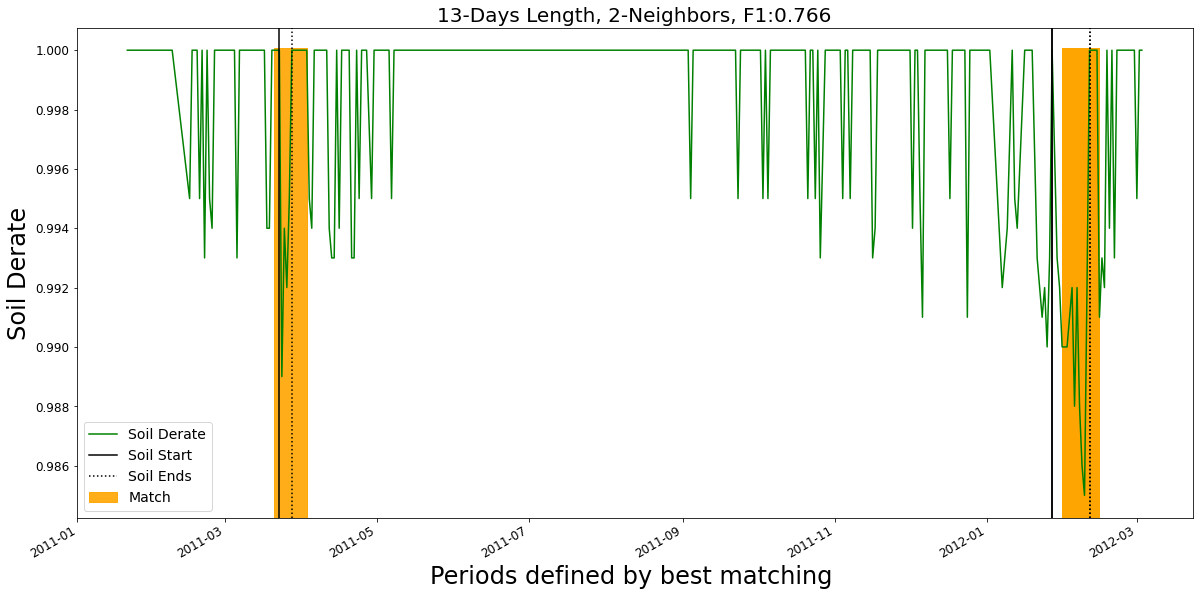

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       310
         1.0       0.69      0.86      0.77        21

    accuracy                           0.97       331
   macro avg       0.84      0.92      0.87       331
weighted avg       0.97      0.97      0.97       331



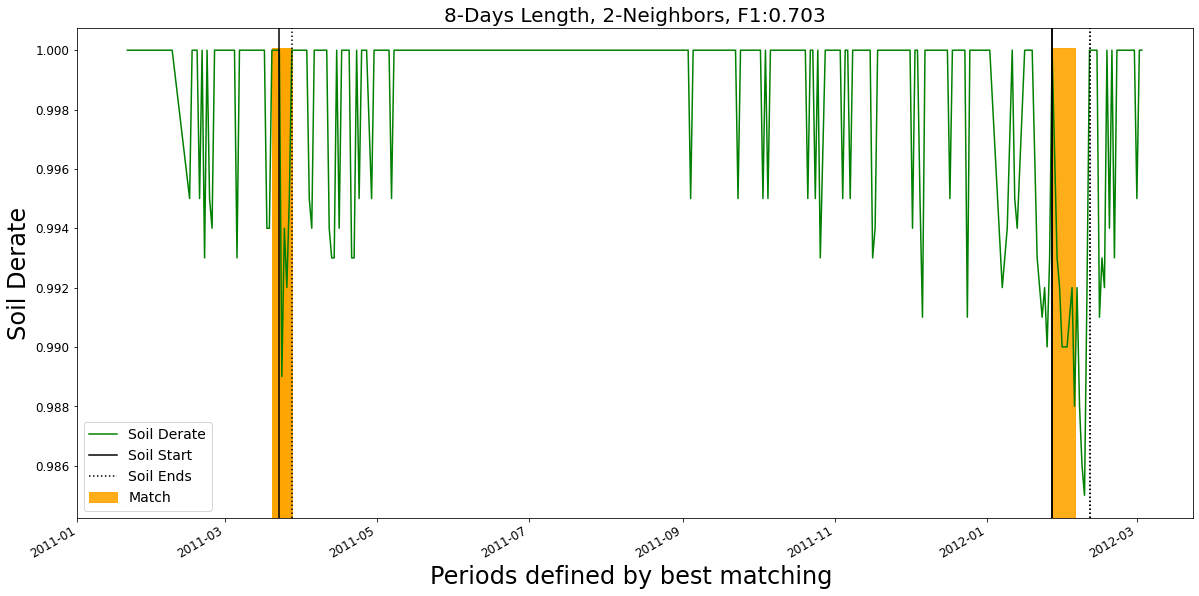

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       310
         1.0       0.81      0.62      0.70        21

    accuracy                           0.97       331
   macro avg       0.89      0.80      0.84       331
weighted avg       0.96      0.97      0.96       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`


In [9]:
files=['eugene.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")
    print(f'{count}/{len(files)}')
    print(file)
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file=='golden.csv':
      # df=df.loc[:'2013-06-24']

      df.soiling_derate[0]=1
      df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    df_new=df
    out,df_last=matching_eval(col,df_old,df_new,alles_df=end_df[end_df.f1>0.3],
                              events=len(df_soil_output),df_soil_output=df_soil_output,
                              n=len(end_df[end_df.f1>0.3]),plot=False)
    # df_last.to_csv(f'/home/pgidarakos/Genetic/Eugene/indirect_eval_{i}_deliv.csv',columns=df_last.columns,index=False)
    print(df_last.head(6))
    match_graph_multi_dim_eval(col,df_new,df_old,df_soil_output=df_soil_output,alles_df=df_last,n=2,plot=True)

    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~`")

### MP based pattern discovery 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
eugene.csv
1/2
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (370, 7)
We found 5 Soiling Events with decay less than 0.989 


   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0        0   2.64    3.74     16         10            13             1.0   
1        0   2.64    3.74     16         10            13             2.0   
2        0   3.41    5.77     13          9            12             2.0   
3        0   3.35    4.18     14         10            12             2.0   
4        0   3.83    4.30     14         10            12             inf   

         f1   jaccard    recall   hamming      pres  motif_type  
0  0.730769  0.575758  0.584615  0.075676  0.974359           3  
1  0.717949  0.560000  0.646154  0.089189  0.807692           3  
2  0.694444  0.531915  0.769231  0.118919  0.632911           4  
3  0.666667  0.500000  0.676923  0.118919  0.656716           4  
4  0.651852  0.483516  0.676923  0.127027  0.628571           6  


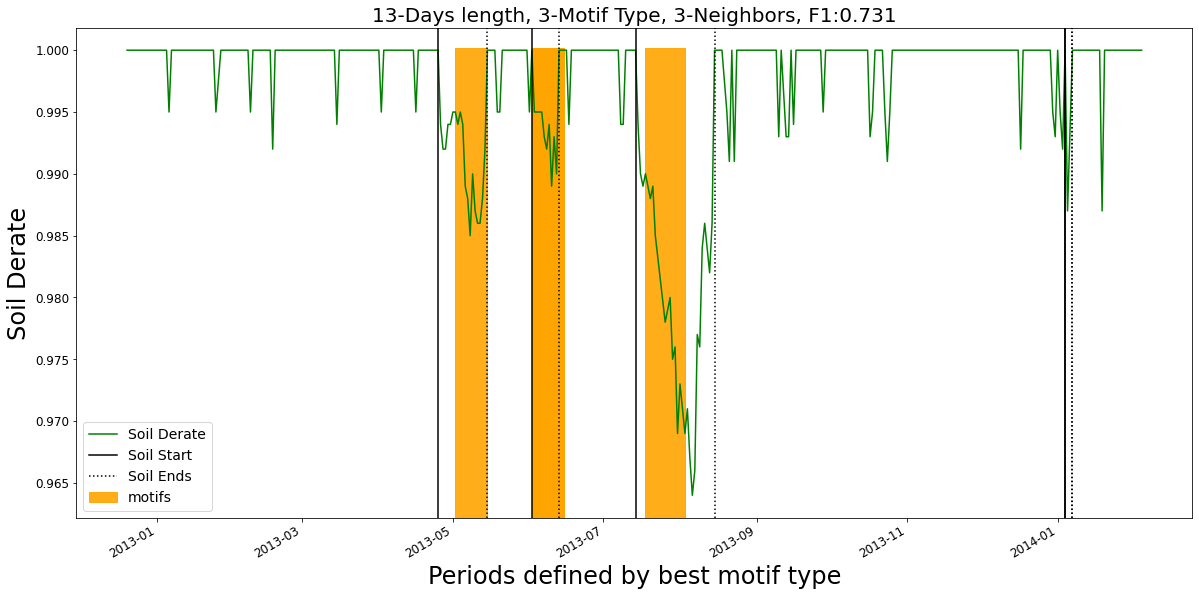

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       305
         1.0       0.97      0.58      0.73        65

    accuracy                           0.92       370
   macro avg       0.95      0.79      0.84       370
weighted avg       0.93      0.92      0.92       370



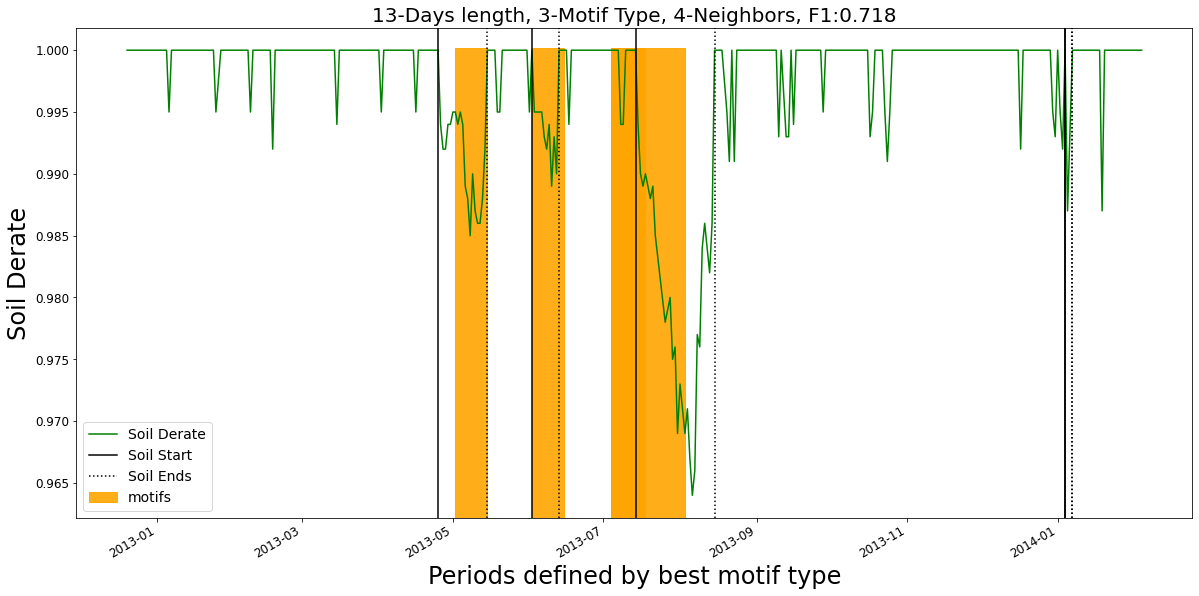

              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95       305
         1.0       0.81      0.65      0.72        65

    accuracy                           0.91       370
   macro avg       0.87      0.81      0.83       370
weighted avg       0.91      0.91      0.91       370

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cocoa.csv
2/2
We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event
Shape of our Timeseries: (331, 7)
We found 2 Soiling Events with decay less than 0.989 


   min_nei  max_d  cutoff  max_m  max_motif  profile_wind  exclusion_zone  \
0        1   0.74    1.45      9          9             7             8.0   
1        1   0.64    1.05     10          9             6             7.0   
2        1   0.40    0.92     10          9             5             inf   
3        0   1.88    1.75     14          9             9             8.0   
4        0   1.14    2.63     11         10             7             2.0   

         f1   jaccard    recall   hamming      pres  motif_type  
0  0.600000  0.428571  1.000000  0.024169  0.428571           2  
1  0.555556  0.384615  0.833333  0.024169  0.416667           2  
2  0.500000  0.333333  0.666667  0.024169  0.400000           3  
3  0.363636  0.222222  1.000000  0.063444  0.222222           4  
4  0.352941  0.214286  1.000000  0.066465  0.214286           2  


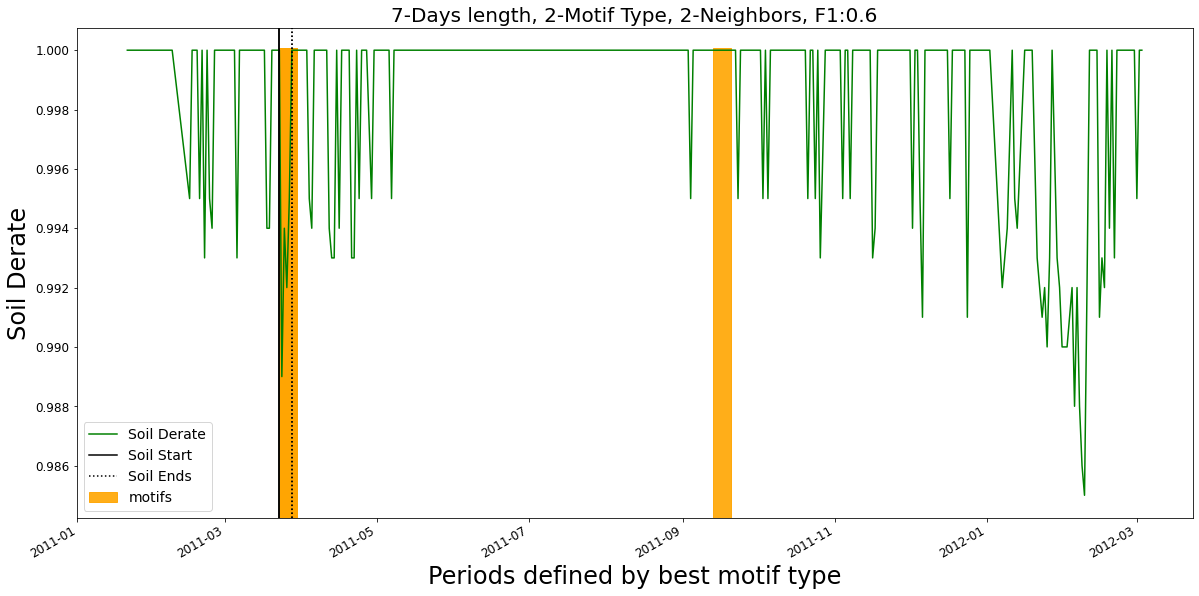

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       325
         1.0       0.43      1.00      0.60         6

    accuracy                           0.98       331
   macro avg       0.71      0.99      0.79       331
weighted avg       0.99      0.98      0.98       331



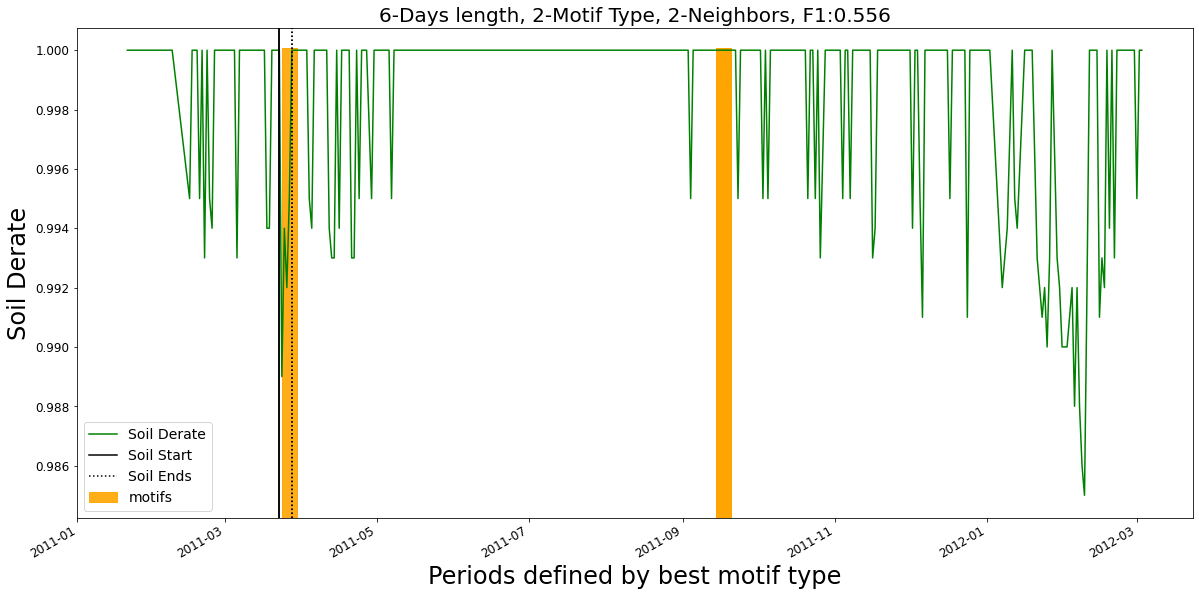

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       325
         1.0       0.42      0.83      0.56         6

    accuracy                           0.98       331
   macro avg       0.71      0.91      0.77       331
weighted avg       0.99      0.98      0.98       331

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
files=['eugene.csv',
       'cocoa.csv']
count=1
for i,file in enumerate(files):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(file)
    print(f'{count}/{len(files)}')
    count=count+1
    filename = file
    df=pd.read_csv(filename)
    df['timestamp']=pd.to_datetime(df['timestamp'])
    df=df.set_index('timestamp')
    #testing step
    if file == 'eugene.csv':
      df2 = pd.DataFrame(index = pd.date_range('2014-01-21','2014-02-4', freq='D'))
# df=pd.concat([df,df[:15].reset_index(drop=True).set_index(df2.index)])
      df=pd.concat([df,df2])
      df.soiling_derate=df.soiling_derate.fillna(1)
      df=df.interpolate(method='linear')
    if file=='golden.csv':
        df=df.loc[:'2013-06-24']

        df.soiling_derate[0]=1
        df.soiling_derate[1]=1

    df.soiling_derate[-1]=1
    ##testing step
    print('We reshape our dataset to 24h per point. As we observe soiling procedure is a slow in time event')
    print(f'Shape of our Timeseries: {df.shape}')
    df_soil_output=soiling_dates(df,y=x,plot=False)
    df_soil_output=df_soil_output[:-1]
#     print(f'Here we observe the exact dates which a soiling interval starts and stops')
#     print(df_soil_output)
    events=len(df_soil_output)
    eval_df,_,_=evaluate_motifs(col,df,df_soil_output,alles_df=end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']])
    eval_df=pd.concat([end_df[['min_nei', 'max_d', 'cutoff', 'max_m', 'max_motif', 'profile_wind','exclusion_zone']],eval_df],axis=1)
    eval_df=eval_df.loc[eval_df[['f1']].drop_duplicates(['f1']).index]
    eval_df=eval_df.sort_values(by='f1',ascending=False)
    eval_df=eval_df.reset_index(drop=True)
    print(eval_df.head())
    # eval_df.to_csv(f'/home/pgidarakos/Genetic/Eugene/direct_eval_{i}_deliv.csv',columns=eval_df.columns,index=False)

    motif_graph_multi_dim_eval(col=col,df=df,
                      df_soil_output=df_soil_output,
                      alles_df=eval_df,n=2,plot=True)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")